# 0 - Library Preprarations

## Installation

In [ ]:
# Memastikan reproduktifitas dan menghindari masalah kompatibilitas di masa mendatang
!pip install numpy==1.23.5, tensorflow==2.12.0, keras==2.12.0, keras-tuner==1.3.5, pmdarima==2.0.3, statsmodels==0.14.0, openpyxl==3.1.2


## Importing and Stuff

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# import library
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import tensorflow as tf
import math
from sklearn import __version__ as sklearn_version

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistic
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

# Machine learning metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning (LSTM model)
import keras
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import RandomSearch

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn import __version__ as sklearn_version

# Data handling
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"openpyxl version: {openpyxl.__version__}")
print(f"math module version: {math.__version__ if hasattr(math, '__version__') else 'builtin module, no version'}")

# Visualization
print(f"seaborn version: {sns.__version__}")

# Machine learning metrics
print(f"scikit-learn version: {sklearn_version}")

# Deep learning (LSTM model)
print(f"tensorflow version: {tf.__version__}")

pandas version: 2.2.2
numpy version: 1.23.5
openpyxl version: 3.1.2
math module version: builtin module, no version
seaborn version: 0.13.2
scikit-learn version: 1.6.1
tensorflow version: 2.12.0


# 1 - Initial Data Preparation

In [ ]:
# Download data dari sumber

!wget "https://www.energyinst.org/__data/assets/excel_doc/0020/1540550/EI-Stats-Review-All-Data.xlsx"

--2025-04-26 03:40:24--  https://www.energyinst.org/__data/assets/excel_doc/0020/1540550/EI-Stats-Review-All-Data.xlsx
Resolving www.energyinst.org (www.energyinst.org)... 103.15.170.110
Connecting to www.energyinst.org (www.energyinst.org)|103.15.170.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3714369 (3.5M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘EI-Stats-Review-All-Data.xlsx’

EI-Stats-Review-All 100%[===================>]   3.54M  4.71MB/s    in 0.8s    

2025-04-26 03:40:25 (4.71 MB/s) - ‘EI-Stats-Review-All-Data.xlsx’ saved [3714369/3714369]



In [ ]:
# Load data
file_path = "/content/EI-Stats-Review-All-Data.xlsx"

# Read the excel file
xls = pd.ExcelFile(file_path)

In [ ]:
# menampilkan nama sheet pada data
xls.sheet_names

['Contents',
 'Primary energy cons - EJ',
 'PE Cons by fuel EJ',
 'PE cons per capita GJ',
 'Carbon Dioxide from Energy',
 'CO2 From Flaring',
 'Natural Gas Flaring',
 'CO2-Process Emissions, Methane',
 'CO2e Emissions ',
 'CCUS Capture Capacity',
 'Carbon Prices',
 'Oil - Proved reserves',
 'Oil - Proved reserves history',
 'Oil Production - barrels',
 'Oil Production - tonnes',
 'Crude+cond production - barrels',
 'NGLs production - barrels',
 'Liquids Consumption - barrels',
 'Oil Consumption - barrels',
 'Oil Consumption - Tonnes',
 'Oil Consumption - EJ',
 'Oil - Regional Consumption',
 'Spot crude prices',
 'Oil crude prices since 1861',
 'Oil refinery - throughput',
 'Oil refinery - capacity',
 'Oil - Regional refining margins',
 'Oil trade movements',
 'Oil - Inter-area movements',
 'Oil - Trade movements in 22-23',
 'Gas - Proved reserves',
 'Gas - Proved reserves history ',
 'Gas Production - Bcm',
 'Gas Production - Bcf',
 'Gas Production - EJ',
 'Gas Consumption - Bcm',
 'G

In [ ]:
# memilih data
df = pd.read_excel(xls, sheet_name="Spot crude prices")

In [ ]:
# menampilkan 5 baris data pertama
print("First 5 rows of data:")
df.head()

First 5 rows of data:


Oil: Spot crude prices Unnamed: 1 Unnamed: 2 Unnamed: 3    Unnamed: 4
0                    NaN      Dubai      Brent   Nigerian    West Texas
1                    NaN        NaN        NaN   Forcados  Intermediate
2  US dollars per barrel     $/bbl1     $/bbl2     $/bbl3        $/bbl4
3                   1972        1.9          -          -             -
4                   1973   2.833333          -          -             -

In [ ]:
# mengabaikan baris pertama yang bukan data utama
df_crude_cleaned = pd.read_excel(xls, sheet_name="Spot crude prices", skiprows=3)

# mengubah nama kolom sesuai deskriptif
df_crude_cleaned.columns = ["Year", "Dubai", "Brent", "Nigerian", "WTI"]

# Menghapus baris yang berisi nilai yang tidak valid
df_crude_cleaned = df_crude_cleaned.dropna()

# Mengonversi kolom numerik ke tipe data numerik
df_crude_cleaned["Year"] = pd.to_numeric(df_crude_cleaned["Year"], errors="coerce")
df_crude_cleaned["Dubai"] = pd.to_numeric(df_crude_cleaned["Dubai"], errors="coerce")
df_crude_cleaned["Brent"] = pd.to_numeric(df_crude_cleaned["Brent"], errors="coerce")
df_crude_cleaned["Nigerian"] = pd.to_numeric(df_crude_cleaned["Nigerian"], errors="coerce")
df_crude_cleaned["WTI"] = pd.to_numeric(df_crude_cleaned["WTI"], errors="coerce")

# Menampilkan data yang telah dibersihkan
df_crude_cleaned.head()

Year      Dubai  Brent  Nigerian    WTI
0  1972   1.900000    NaN       NaN    NaN
1  1973   2.833333    NaN       NaN    NaN
2  1974  10.412500    NaN       NaN    NaN
3  1975  10.702500    NaN       NaN    NaN
4  1976  11.625000   12.8     12.87  12.23

In [ ]:
df = df_crude_cleaned

In [ ]:
# Mengonversi 'Tahun' ke format datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [ ]:
# Tetapkan sebagai indeks
df.set_index('Year', inplace=True)

In [ ]:
# memeriksa data
print("\nData dimensions:", df.shape)
print("\nData types and non-null counts:")
print(df.info())


Data dimensions: (52, 4)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 1972-01-01 to 2023-01-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Dubai     52 non-null     float64
 1   Brent     48 non-null     float64
 2   Nigerian  48 non-null     float64
 3   WTI       48 non-null     float64
dtypes: float64(4)
memory usage: 2.0 KB
None


In [ ]:
# melihat statitik data
print("\nDescriptive statistics:")
print(df.describe())


Descriptive statistics:
            Dubai       Brent    Nigerian         WTI
count   52.000000   48.000000   48.000000   48.000000
mean    39.094404   43.789521   44.376717   42.626001
std     30.300237   30.506938   31.321304   27.439806
min      1.900000   12.715661   12.626284   12.230000
25%     15.960342   18.928201   19.095763   20.345429
50%     27.795000   30.580000   29.395000   30.714413
75%     61.227224   64.443945   65.476762   62.743170
max    109.057022  111.669702  114.212083  100.062410


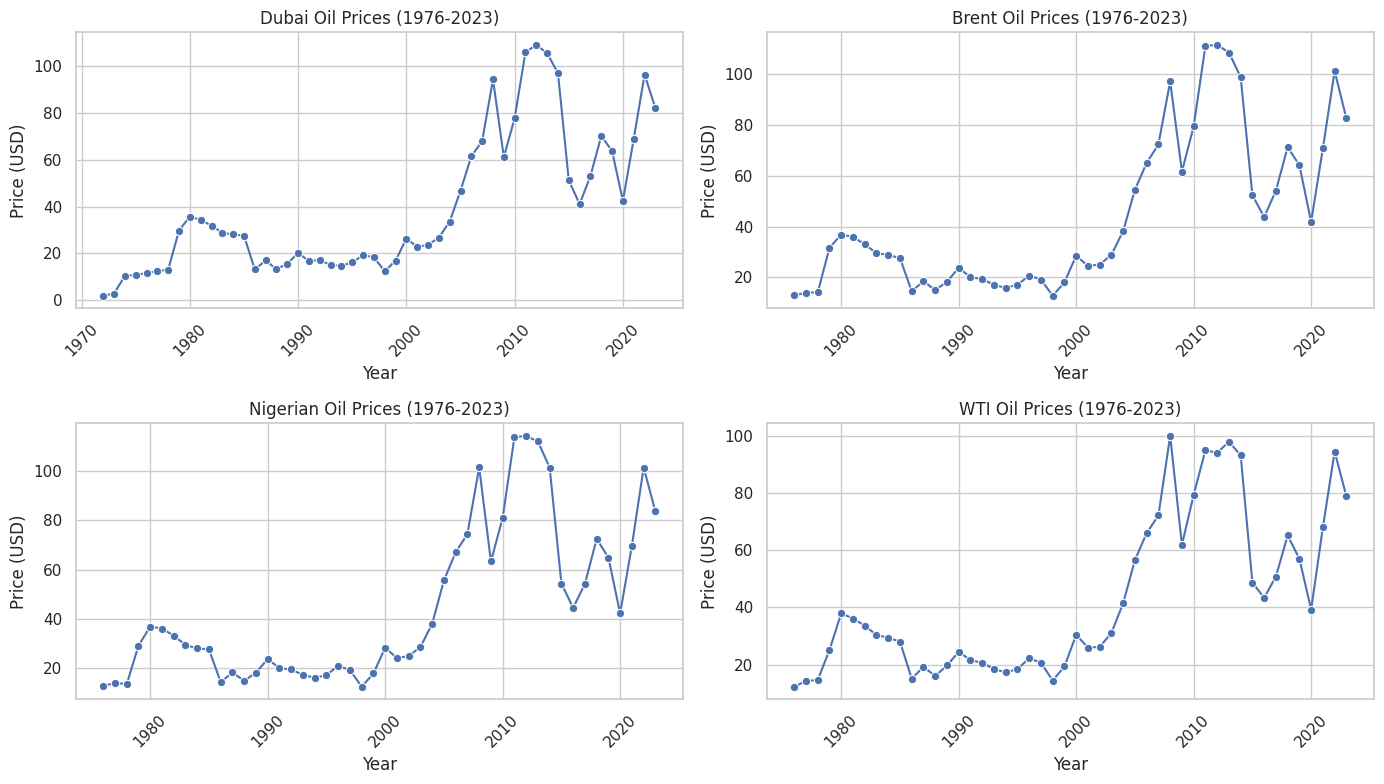

In [ ]:
# gaya plot
sns.set(style="whitegrid")

# membuat plot tiap negara
plt.figure(figsize=(14, 8))
regions = ["Dubai", "Brent", "Nigerian", "WTI"]

for i, region in enumerate(regions, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(x='Year', y=region, data=df, marker='o')
    plt.title(f'{region} Oil Prices (1976-2023)')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2 - Data Preprocessing

## a. Data Cleaning (Imputation)

In [ ]:
# check missing values
missing_before = df.isnull().sum().sum()
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
Dubai       0
Brent       4
Nigerian    4
WTI         4
dtype: int64


In [ ]:
if missing_before > 0:
    # Menerapkan interpolasi linier untuk nilai yang hilang (jika ada)
    df_clean = df.interpolate(method='linear', limit_direction='both')

    # Verifikasi
    missing_after = df_clean.isnull().sum().sum()
    print("\nMissing values setelah imputasi:")
    print(df_clean.isnull().sum())

    if missing_after == 0:
        print("\nSemua nilai yang hilang telah berhasil diperhitungkan.")
    else:
        print("\nBeberapa nilai yang hilang tetap ada setelah imputasi.")
else:
    print("\nTidak ada nilai yang hilang yang ditemukan. Melewatkan imputasi.")
    df_clean = df.copy()


Missing values setelah imputasi:
Dubai       0
Brent       0
Nigerian    0
WTI         0
dtype: int64

Semua nilai yang hilang telah berhasil diperhitungkan.


In [ ]:
df_clean.head(10)

Dubai  Brent  Nigerian    WTI
Year                                         
1972-01-01   1.900000  12.80     12.87  12.23
1973-01-01   2.833333  12.80     12.87  12.23
1974-01-01  10.412500  12.80     12.87  12.23
1975-01-01  10.702500  12.80     12.87  12.23
1976-01-01  11.625000  12.80     12.87  12.23
1977-01-01  12.375000  13.92     14.21  14.22
1978-01-01  13.025833  14.02     13.65  14.55
1979-01-01  29.754167  31.61     29.25  25.08
1980-01-01  35.691667  36.83     36.98  37.96
1981-01-01  34.320833  35.93     36.18  36.08

## b. Outlier Identification (Z-Score)

In [ ]:
# menghitung z-score
z_scores = df_clean[["Dubai", "Brent", "Nigerian", "WTI"]].apply(zscore)

In [ ]:
# menentukan ambang batas (umumnya |z| > 3)
outliers = (z_scores.abs() > 3).any(axis=1)

In [ ]:
print(f"\nOutliers detected: {outliers.sum()} rows")
print("Sample outlier rows:")
print(df_clean[outliers])


Outliers detected: 0 rows
Sample outlier rows:
Empty DataFrame
Columns: [Dubai, Brent, Nigerian, WTI]
Index: []


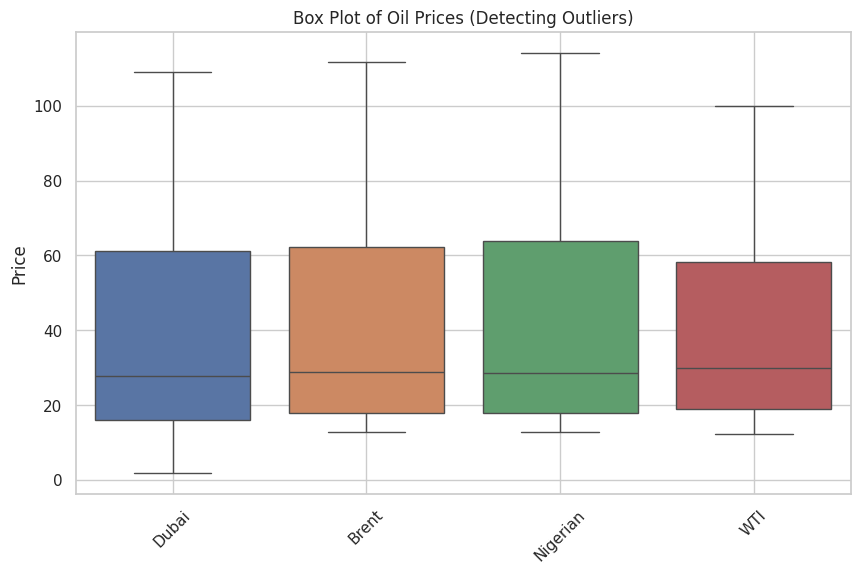

In [ ]:
# visualisasi outliers dengan box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean[["Dubai", "Brent", "Nigerian", "WTI"]])
plt.title("Box Plot of Oil Prices (Detecting Outliers)")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## c. Sattionarity Check (ADF Test)

In [ ]:
def check_stationarity(region):
    result = adfuller(df_clean[region])
    print(f"\n=== {region} Stationarity Test ===")
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

In [ ]:
# Check seluruh negara
for region in ["Dubai", "Brent", "Nigerian", "WTI"]:
    check_stationarity(region)


=== Dubai Stationarity Test ===
ADF Statistic: -1.5142
p-value: 0.5265
Non-stationary

=== Brent Stationarity Test ===
ADF Statistic: -1.5183
p-value: 0.5245
Non-stationary

=== Nigerian Stationarity Test ===
ADF Statistic: -1.5174
p-value: 0.5249
Non-stationary

=== WTI Stationarity Test ===
ADF Statistic: -1.5611
p-value: 0.5031
Non-stationary


In [ ]:
# memastikan data
def check_stationarity_actual(series, name):
    result = adfuller(series.dropna())
    print(f"\n=== {name} Stationarity Test ===")
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

In [ ]:
df_stationary = df_clean.copy()

for region in ["Dubai", "Brent", "Nigerian", "WTI"]:
    # Diferensiasi pertama (d = 1)
    df_stationary[f'{region}_diff'] = df_stationary[region].diff()

    # memeriksa ulang dengan yang sudah dikoreksi
    print(f"\n=== {region} After Differencing ===")
    check_stationarity_actual(
        series=df_stationary[f'{region}_diff'],
        name=f'{region}_diff'
    )


=== Dubai After Differencing ===

=== Dubai_diff Stationarity Test ===
ADF Statistic: -6.2448
p-value: 0.0000
Stationary

=== Brent After Differencing ===

=== Brent_diff Stationarity Test ===
ADF Statistic: -6.5444
p-value: 0.0000
Stationary

=== Nigerian After Differencing ===

=== Nigerian_diff Stationarity Test ===
ADF Statistic: -6.4762
p-value: 0.0000
Stationary

=== WTI After Differencing ===

=== WTI_diff Stationarity Test ===
ADF Statistic: -6.3630
p-value: 0.0000
Stationary


## d. Trend Analysis

Data tidak memiliki musim

In [ ]:
def analyze_trends(region):
    result = seasonal_decompose(
        df_clean[region],
        model='additive',
        period=1  # Data tahunan (tidak ada musim)
    )

    # Buat figure dan atur ukuran
    fig = result.plot()
    fig.set_size_inches(10, 8)

    # Tambahkan judul utama dengan jarak dari plot
    plt.suptitle(f'{region} Trend/Seasonality Analysis', fontsize=16, y=1.02)

    # Atur layout agar tidak tumpang tindih
    plt.tight_layout()

    # Tampilkan plot
    plt.show()

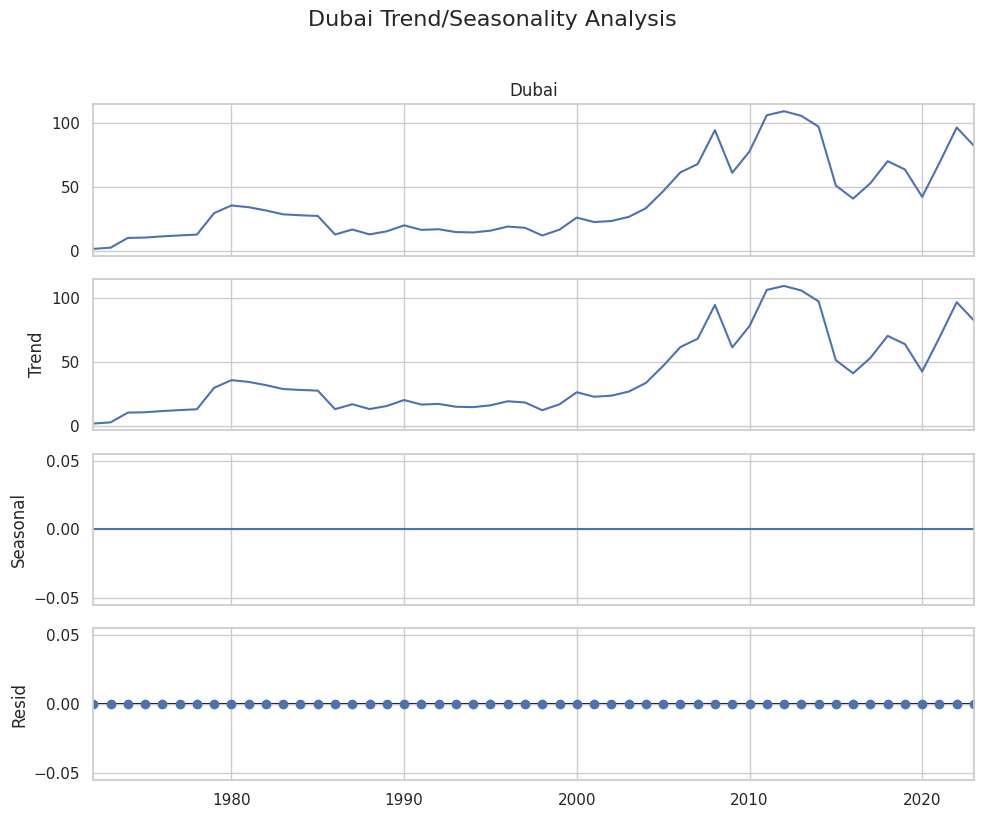

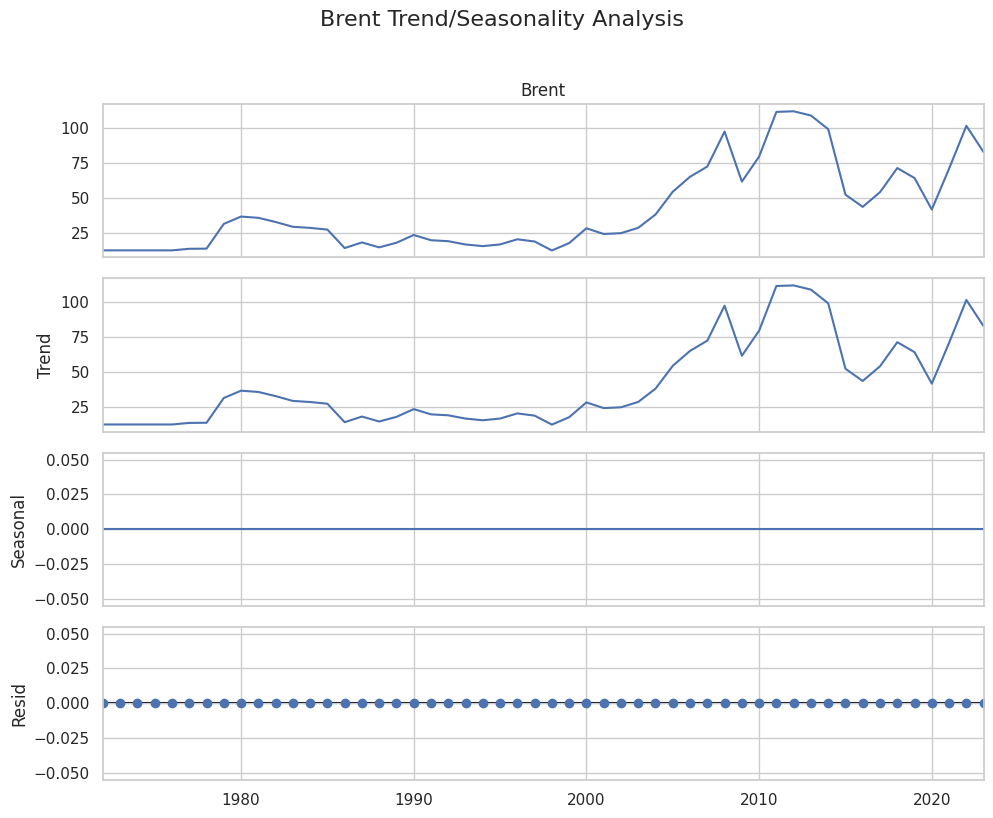

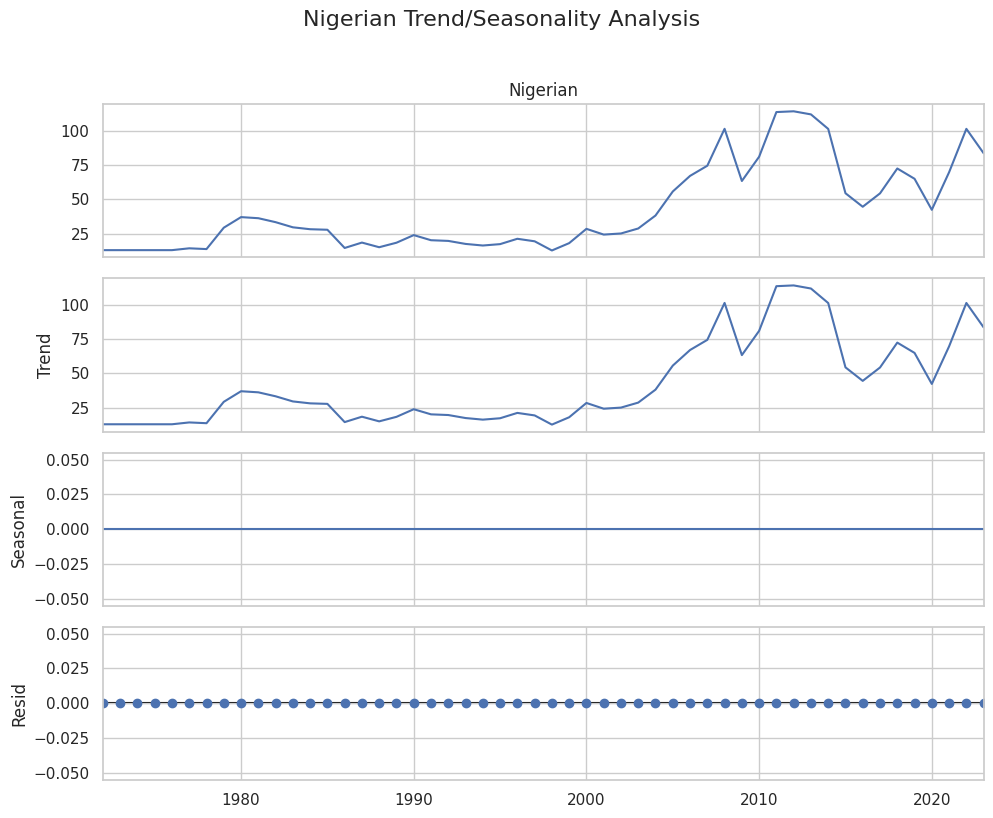

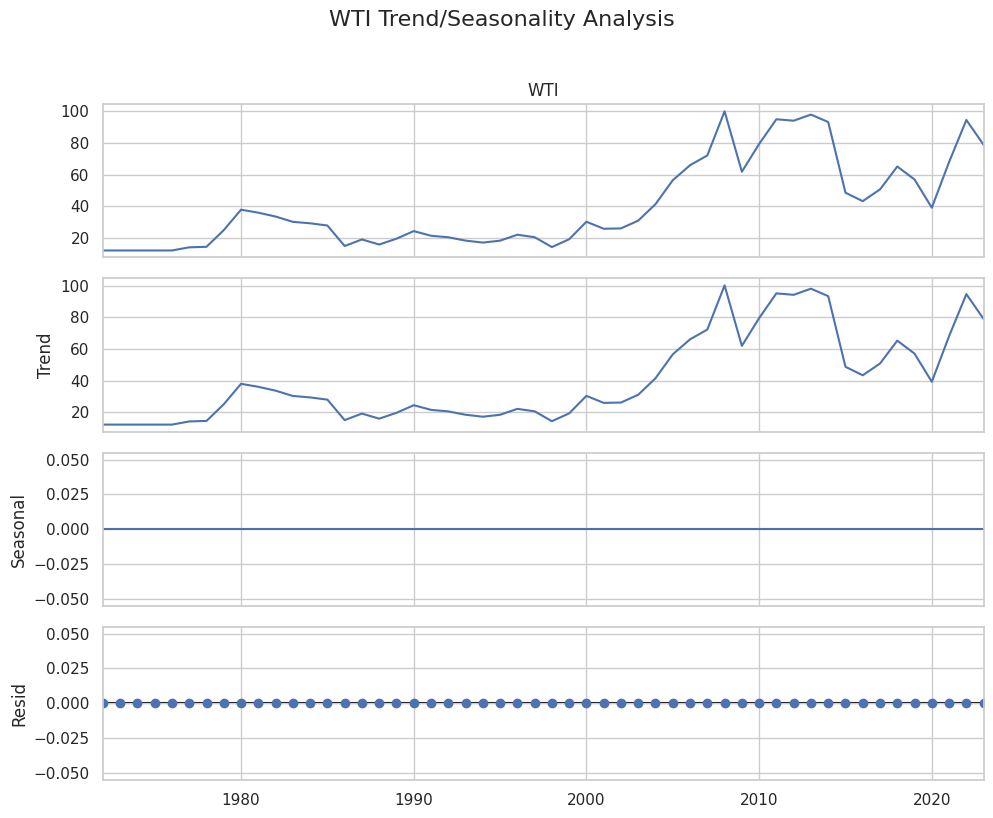

In [ ]:
for region in ["Dubai", "Brent", "Nigerian", "WTI"]:
    analyze_trends(region)

## e. Data Splitting (80-20)

In [ ]:
train_size = int(len(df_clean) * 0.8)
train, test = df_clean[:train_size], df_clean[train_size:]

print(f"\nTraining set: {train.shape[0]} rows ({train.index[0]}-{train.index[-1]})")
print(f"Test set: {test.shape[0]} rows ({test.index[0]}-{test.index[-1]})")


Training set: 41 rows (1972-01-01 00:00:00-2012-01-01 00:00:00)
Test set: 11 rows (2013-01-01 00:00:00-2023-01-01 00:00:00)


# 3 - Model Implementations

## a. ARIMA Implementation

In [ ]:
def train_arima(df, region):
    # auto ARIMA model
    model = auto_arima(
        df[region],
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        test='adf',
        seasonal=False,
        trace=False
    )

    # Split data
    train_size_arima = int(len(df) * 0.8)
    train_arima = df[region][:train_size_arima]
    test_arima = df[region][train_size_arima:]

    # final model
    model.fit(train_arima)

    # Forecast
    forecast = model.predict(n_periods=len(test_arima))
    forecast_train = model.predict_in_sample()

    # Metrics
    train_metrics = {
        'MAE': mean_absolute_error(train_arima, forecast_train),
        'MSE': mean_squared_error(train_arima, forecast_train),
        'RMSE': np.sqrt(mean_squared_error(train_arima, forecast_train)),
        'R2': r2_score(train_arima, forecast_train)
    }

    test_metrics = {
        'MAE': mean_absolute_error(test_arima, forecast),
        'MSE': mean_squared_error(test_arima, forecast),
        'RMSE': np.sqrt(mean_squared_error(test_arima, forecast)),
        'R2': r2_score(test_arima, forecast)
    }

    return {
        'model': model,
        'train_predict': forecast_train,
        'test_predict': forecast,
        'train_actual': train_arima.values,
        'test_actual': test_arima.values,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'train_indices': df.index[:train_size_arima],
        'test_indices': df.index[train_size_arima:train_size_arima+len(forecast)]
    }

## b. LSTM Implementation

In [ ]:
window_size = 5

In [ ]:
def train_lstm_simple(df, region, feature_cols=None, size_window=window_size, test_size=0.2):
    # Jika tidak ada kolom fitur yang ditentukan, gunakan hanya kolom target
    if feature_cols is None:
        feature_cols = [region]

    # memilih data yang relevan
    data = df[feature_cols].values

    # membuat skala data
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler_x.fit_transform(data)

    # memisahkan scaler untuk variabel target untuk memudahkan transformasi inversi
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(df[[region]].values)

    # membuat urutan LSTM
    X, y = [], []
    for i in range(len(data_scaled) - size_window):
        X.append(data_scaled[i:(i + size_window)])
        y.append(y_scaled[i + size_window, 0])

    X, y = np.array(X), np.array(y)

    # menghitung data train/test
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # membuat LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Kompilasi model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stop
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )

    # Membuat prediksi
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # prediksi perubahan terbalik
    train_predict_reshaped = np.zeros((len(train_predict), len(feature_cols)))
    train_predict_reshaped[:, 0] = train_predict.flatten()

    test_predict_reshaped = np.zeros((len(test_predict), len(feature_cols)))
    test_predict_reshaped[:, 0] = test_predict.flatten()

    # perubahan terbalik
    y_train_inv = scaler_y.inverse_transform(train_predict.reshape(-1, 1))
    y_test_inv = scaler_y.inverse_transform(test_predict.reshape(-1, 1))

    # Actual values (inverse yang diubah)
    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    # menghitung matrix
    train_mae = mean_absolute_error(y_train_actual, y_train_inv)
    train_mse = mean_squared_error(y_train_actual, y_train_inv)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_actual, y_train_inv)

    test_mae = mean_absolute_error(y_test_actual, y_test_inv)
    test_mse = mean_squared_error(y_test_actual, y_test_inv)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_actual, y_test_inv)

    # menyiapkan hasil
    results = {
        'model': model,
        'history': history,
        'scaler_x': scaler_x,
        'scaler_y': scaler_y,
        'train_predict': y_train_inv,
        'test_predict': y_test_inv,
        'train_actual': y_train_actual,
        'test_actual': y_test_actual,
        'train_metrics': {
            'MAE': train_mae,
            'MSE': train_mse,
            'RMSE': train_rmse,
            'R2': train_r2
        },
        'test_metrics': {
            'MAE': test_mae,
            'MSE': test_mse,
            'RMSE': test_rmse,
            'R2': test_r2
        },
        'train_indices': df.index[size_window:size_window+len(y_train)],
        'test_indices': df.index[size_window+len(y_train):size_window+len(y_train)+len(y_test)]
    }

    return results

In [ ]:
def build_model(hp, input_shape):
    model = Sequential()

    # First LSTM layer
    lstm_units = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(
        units=lstm_units,
        return_sequences=True,
        input_shape=input_shape
    ))

    # Dropout rate
    dropout_rate = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))

    # Second LSTM layer
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)
    model.add(LSTM(
        units=lstm_units_2,
        return_sequences=False
    ))

    # Dropout rate
    dropout_rate_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate_2))

    # Output layer
    model.add(Dense(units=1))

    # Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

    # Optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error'
    )

    return model

In [ ]:
def train_lstm_hyper(df, region, feature_cols=None, size_window=window_size, test_size=0.2):
    # Jika tidak ada kolom fitur yang ditentukan, gunakan hanya kolom target
    if feature_cols is None:
        feature_cols = [region]

    # memilih data yang relevan
    data = df[feature_cols].values

    # skala data
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler_x.fit_transform(data)

    # memisahkan scaler untuk variabel target untuk mempermudah perubahan inversi
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(df[[region]].values)

    # membuat urutan LSTM
    X, y = [], []
    for i in range(len(data_scaled) - size_window):
        X.append(data_scaled[i:(i + size_window)])
        y.append(y_scaled[i + size_window, 0])

    X, y = np.array(X), np.array(y)

    # menghitung train/test
    train_size_samples = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size_samples], X[train_size_samples:]
    y_train, y_test = y[:train_size_samples], y[train_size_samples:]

    # menentukan bentuk model
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Hyperparameter
    tuner = RandomSearch(
        lambda hp: build_model(hp, input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='keras_tuner',
        project_name=f'lstm_tuner_{region}'
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # mencari hyperparameter terbaik
    tuner.search(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # mendapatkan hyperparameter terbaik
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for {region}:")
    for param in best_hps.values:
        print(f"- {param}: {best_hps.values[param]}")

    # membuat model dengan hyperparameter terbaik
    best_model = tuner.hypermodel.build(best_hps)

    # melatih model akhir
    history = best_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # membuat prediksi
    train_predict = best_model.predict(X_train)
    test_predict = best_model.predict(X_test)

    # prediksi perubahan terbalik
    y_train_inv = scaler_y.inverse_transform(train_predict)
    y_test_inv = scaler_y.inverse_transform(test_predict)

    # Actual values (memebalikan perubahan)
    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    # menghitung metrics
    train_mae = mean_absolute_error(y_train_actual, y_train_inv)
    train_mse = mean_squared_error(y_train_actual, y_train_inv)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_actual, y_train_inv)

    test_mae = mean_absolute_error(y_test_actual, y_test_inv)
    test_mse = mean_squared_error(y_test_actual, y_test_inv)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_actual, y_test_inv)

    # hasil
    results = {
        'model': best_model,
        'history': history,
        'scaler_x': scaler_x,
        'scaler_y': scaler_y,
        'train_predict': y_train_inv,
        'test_predict': y_test_inv,
        'train_actual': y_train_actual,
        'test_actual': y_test_actual,
        'train_metrics': {
            'MAE': train_mae,
            'MSE': train_mse,
            'RMSE': train_rmse,
            'R2': train_r2
        },
        'test_metrics': {
            'MAE': test_mae,
            'MSE': test_mse,
            'RMSE': test_rmse,
            'R2': test_r2
        },
        'best_params': best_hps.values,
        'train_indices': df.index[size_window:size_window+len(y_train)],
        'test_indices': df.index[size_window+len(y_train):size_window+len(y_train)+len(y_test)]
    }

    return results

## c. GRU

In [ ]:
def build_gru_model(hp, input_shape):
    model = Sequential()

    # First GRU layer
    gru_units_1 = hp.Int('gru_units_1', min_value=32, max_value=128, step=32)
    model.add(GRU(units=gru_units_1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(rate=hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Second GRU layer
    gru_units_2 = hp.Int('gru_units_2', min_value=32, max_value=128, step=32)
    model.add(GRU(units=gru_units_2, return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # Output
    model.add(Dense(1))

    # Optimizer
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    optimizer = {'adam': Adam(lr), 'rmsprop': RMSprop(lr), 'sgd': SGD(lr)}[optimizer_choice]

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [ ]:
def train_gru_simple(df, region, feature_cols=None, size_window=5, test_size=0.2):
    if feature_cols is None:
        feature_cols = [region]

    data = df[feature_cols].values

    scaler_x = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler_x.fit_transform(data)

    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(df[[region]].values)

    X, y = [], []
    for i in range(len(data_scaled) - size_window):
        X.append(data_scaled[i:(i + size_window)])
        y.append(y_scaled[i + size_window, 0])

    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    y_train_inv = scaler_y.inverse_transform(train_predict)
    y_test_inv = scaler_y.inverse_transform(test_predict)

    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    results = {
        'model': model,
        'history': history,
        'scaler_x': scaler_x,
        'scaler_y': scaler_y,
        'train_predict': y_train_inv,
        'test_predict': y_test_inv,
        'train_actual': y_train_actual,
        'test_actual': y_test_actual,
        'train_metrics': {
            'MAE': mean_absolute_error(y_train_actual, y_train_inv),
            'MSE': mean_squared_error(y_train_actual, y_train_inv),
            'RMSE': np.sqrt(mean_squared_error(y_train_actual, y_train_inv)),
            'R2': r2_score(y_train_actual, y_train_inv)
        },
        'test_metrics': {
            'MAE': mean_absolute_error(y_test_actual, y_test_inv),
            'MSE': mean_squared_error(y_test_actual, y_test_inv),
            'RMSE': np.sqrt(mean_squared_error(y_test_actual, y_test_inv)),
            'R2': r2_score(y_test_actual, y_test_inv)
        },
        'train_indices': df.index[size_window:size_window+len(y_train)],
        'test_indices': df.index[size_window+len(y_train):size_window+len(y_train)+len(y_test)]
    }

    return results

In [ ]:
def train_gru_hyper(df, region, feature_cols=None, size_window=5, test_size=0.2):
    if feature_cols is None:
        feature_cols = [region]

    data = df[feature_cols].values

    scaler_x = MinMaxScaler()
    data_scaled = scaler_x.fit_transform(data)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(df[[region]].values)

    X, y = [], []
    for i in range(len(data_scaled) - size_window):
        X.append(data_scaled[i:i+size_window])
        y.append(y_scaled[i+size_window, 0])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    input_shape = (X_train.shape[1], X_train.shape[2])
    tuner = RandomSearch(
        lambda hp: build_gru_model(hp, input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='keras_tuner',
        project_name=f'gru_tuner_{region}'
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    tuner.search(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(1)[0]
    model = tuner.hypermodel.build(best_hps)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    y_train_inv = scaler_y.inverse_transform(train_predict)
    y_test_inv = scaler_y.inverse_transform(test_predict)

    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    results = {
        'model': model,
        'history': history,
        'scaler_x': scaler_x,
        'scaler_y': scaler_y,
        'train_predict': y_train_inv,
        'test_predict': y_test_inv,
        'train_actual': y_train_actual,
        'test_actual': y_test_actual,
        'train_metrics': {
            'MAE': mean_absolute_error(y_train_actual, y_train_inv),
            'MSE': mean_squared_error(y_train_actual, y_train_inv),
            'RMSE': np.sqrt(mean_squared_error(y_train_actual, y_train_inv)),
            'R2': r2_score(y_train_actual, y_train_inv)
        },
        'test_metrics': {
            'MAE': mean_absolute_error(y_test_actual, y_test_inv),
            'MSE': mean_squared_error(y_test_actual, y_test_inv),
            'RMSE': np.sqrt(mean_squared_error(y_test_actual, y_test_inv)),
            'R2': r2_score(y_test_actual, y_test_inv)
        },
        'best_params': best_hps.values,
        'train_indices': df.index[size_window:size_window+len(y_train)],
        'test_indices': df.index[size_window+len(y_train):size_window+len(y_train)+len(y_test)]
    }

    return results


## d. Training the Models and Analyse the train result

### ⦿ Training Process

In [ ]:
def train_and_analyze_models(df, region, size_window=window_size):
    print(f"\n{'='*50}")
    print(f"Training models for {region}")
    print(f"{'='*50}")

    # menentukan kolom fitur (optional correlation analysis)
    # menggunakan variabel target
    feature_cols = [region]

    # Train ARIMA model
    print(f"Training ARIMA model for {region}...")
    arima_results = train_arima(df, region)

    # Train simple LSTM model
    print(f"\nTraining simple LSTM model for {region}...")
    simple_lstm_results = train_lstm_simple(df, region, feature_cols, size_window)

    # Train LSTM with hyperparameter tuning
    print(f"\nTraining LSTM model with hyperparameter tuning for {region}...")
    tuned_lstm_results = train_lstm_hyper(df, region, feature_cols, size_window)

    # Train Simple GRU
    print(f"\nTraining Simple GRU for {region}...")
    simple_gru_results = train_gru_simple(df, region, feature_cols, size_window)

    # Train GRU with hyperparameter tuning
    print(f"\nTraining Tuned GRU for {region}...")
    tuned_gru_results = train_gru_hyper(df, region, feature_cols, size_window)

    # Plot predictions vs actual
    plt.figure(figsize=(14, 7))

    # Training data visualization
    plt.subplot(2, 1, 1)
    plt.plot(arima_results['train_indices'], arima_results['train_actual'], label='Actual', color='blue')
    plt.plot(arima_results['train_indices'], arima_results['train_predict'], label='ARIMA', linestyle='-.')
    plt.plot(simple_lstm_results['train_indices'], simple_lstm_results['train_predict'], label='Simple LSTM', linestyle='--')
    plt.plot(tuned_lstm_results['train_indices'], tuned_lstm_results['train_predict'], label='Tuned LSTM', linestyle=':')
    plt.plot(simple_gru_results['train_indices'], simple_gru_results['train_predict'], label='Simple GRU', linestyle='--', color='darkorange')
    plt.plot(tuned_gru_results['train_indices'], tuned_gru_results['train_predict'], label='Tuned GRU', linestyle=':', color='firebrick')

    plt.title(f'Training Predictions - {region}')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)

    # Test data visualization
    plt.subplot(2, 1, 2)
    plt.plot(arima_results['test_indices'], arima_results['test_actual'], label='Actual', color='blue')
    plt.plot(arima_results['test_indices'], arima_results['test_predict'], label='ARIMA', linestyle='-.')
    plt.plot(simple_lstm_results['test_indices'], simple_lstm_results['test_predict'], label='Simple LSTM', linestyle='--')
    plt.plot(tuned_lstm_results['test_indices'], tuned_lstm_results['test_predict'], label='Tuned LSTM', linestyle=':')
    plt.plot(simple_gru_results['test_indices'], simple_gru_results['test_predict'], label='Simple GRU', linestyle='--', color='darkorange')
    plt.plot(tuned_gru_results['test_indices'], tuned_gru_results['test_predict'], label='Tuned GRU', linestyle=':', color='firebrick')

    plt.title(f'Test Predictions - {region}')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # membuat tabel perbandingan
    comparison_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
        'ARIMA (Train)': [
            arima_results['train_metrics']['MAE'],
            arima_results['train_metrics']['MSE'],
            arima_results['train_metrics']['RMSE'],
            arima_results['train_metrics']['R2']
        ],
        'ARIMA (Test)': [
            arima_results['test_metrics']['MAE'],
            arima_results['test_metrics']['MSE'],
            arima_results['test_metrics']['RMSE'],
            arima_results['test_metrics']['R2']
        ],
        'Simple LSTM (Train)': [
            simple_lstm_results['train_metrics']['MAE'],
            simple_lstm_results['train_metrics']['MSE'],
            simple_lstm_results['train_metrics']['RMSE'],
            simple_lstm_results['train_metrics']['R2']
        ],
        'Simple LSTM (Test)': [
            tuned_lstm_results['test_metrics']['MAE'],
            tuned_lstm_results['test_metrics']['MSE'],
            tuned_lstm_results['test_metrics']['RMSE'],
            tuned_lstm_results['test_metrics']['R2']
        ],
        'Tuned LSTM (Train)': [
            tuned_lstm_results['train_metrics']['MAE'],
            tuned_lstm_results['train_metrics']['MSE'],
            tuned_lstm_results['train_metrics']['RMSE'],
            tuned_lstm_results['train_metrics']['R2']
        ],
        'Tuned LSTM (Test)': [
            tuned_lstm_results['test_metrics']['MAE'],
            tuned_lstm_results['test_metrics']['MSE'],
            tuned_lstm_results['test_metrics']['RMSE'],
            tuned_lstm_results['test_metrics']['R2']
        ],
		    'Simple GRU (Train)': [
            simple_gru_results['train_metrics']['MAE'],
            simple_gru_results['train_metrics']['MSE'],
            simple_gru_results['train_metrics']['RMSE'],
            simple_gru_results['train_metrics']['R2']
        ],
	    	'Simple GRU (Test)': [
            simple_gru_results['test_metrics']['MAE'],
            simple_gru_results['test_metrics']['MSE'],
            simple_gru_results['test_metrics']['RMSE'],
            simple_gru_results['test_metrics']['R2']
        ],
		    'Tuned GRU (Train)': [
            tuned_gru_results['train_metrics']['MAE'],
            tuned_gru_results['train_metrics']['MSE'],
            tuned_gru_results['train_metrics']['RMSE'],
            tuned_gru_results['train_metrics']['R2']
        ],
        'Tuned GRU (Test)': [
            tuned_gru_results['test_metrics']['MAE'],
            tuned_gru_results['test_metrics']['MSE'],
            tuned_gru_results['test_metrics']['RMSE'],
            tuned_gru_results['test_metrics']['R2']
        ]
    })

    print(f"\nPerformance Comparison for {region}:")
    print(comparison_df.to_string(index=False))

    return {
        'arima': arima_results,
        'simple': simple_lstm_results,
        'hyper': tuned_lstm_results,
        'simple_gru': simple_gru_results,
        'tuned_gru': tuned_gru_results,
        'comparison': comparison_df
    }

### ⦿ Region Dubai

Trial 5 Complete [00h 00m 07s]
val_loss: 0.18265382945537567

Best val_loss So Far: 0.18265382945537567
Total elapsed time: 00h 00m 39s
Epoch 1/100
2/2 [==============================] - 4s 808ms/step - loss: 0.0955 - val_loss: 0.5153 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0413 - val_loss: 0.5050 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0418 - val_loss: 0.2229 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0193 - val_loss: 0.2182 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0244 - val_loss: 0.2281 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0258 - val_loss: 0.2490 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0191 - val_loss: 0.2722 - lr: 0.0010
Epoch 8/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0236 - val_l

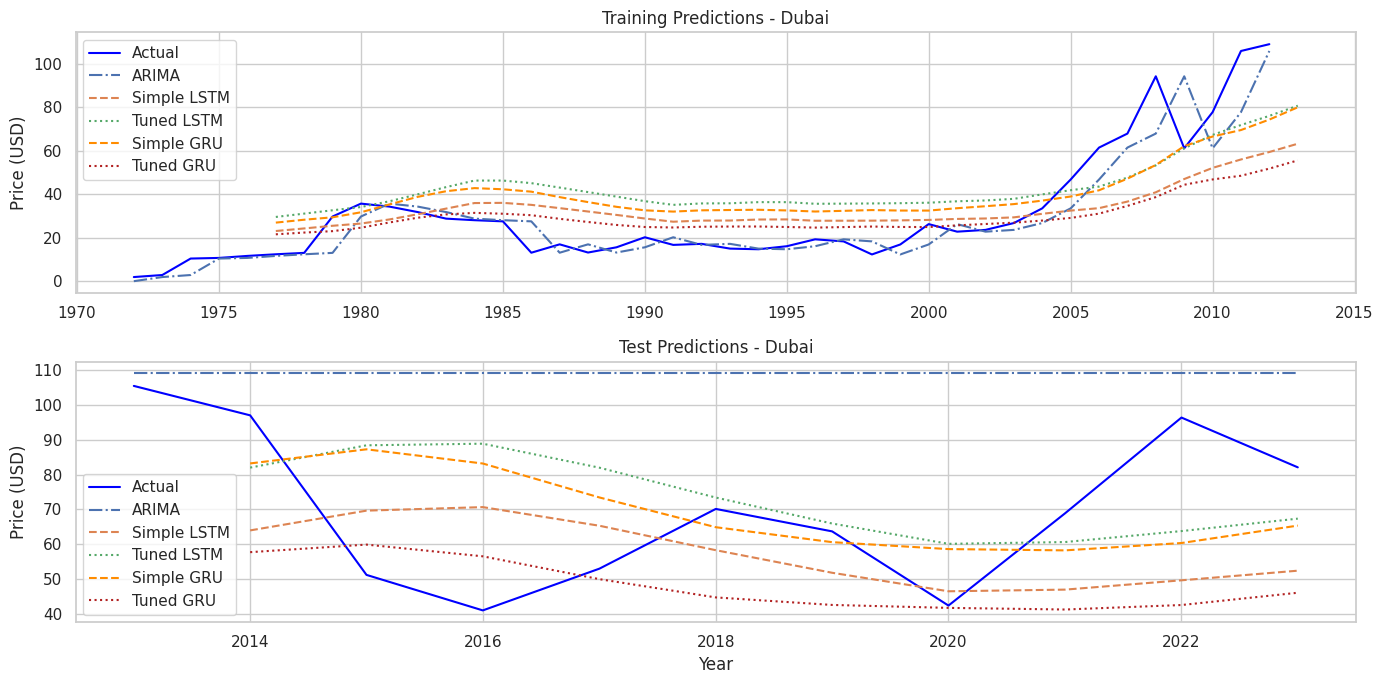


Performance Comparison for Dubai:
Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)
   MAE       6.364212     38.929925            15.566462           20.785470           17.433032          20.785470           15.469457          20.038721          14.956116         23.114296
   MSE     102.689050   1980.292388           424.178971          641.546031          390.007701         641.546031          325.027342         567.538902         478.233057        791.500520
  RMSE      10.133561     44.500476            20.595606           25.328759           19.748613          25.328759           18.028515          23.823075          21.868540         28.133619
    R²       0.851100     -3.260954             0.478089           -0.716029            0.520133          -0.716029            0.600085          -0.518072           0.411580         -1.117132

Comp

Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  \
0    MAE       6.364212     38.929925            15.566462   
1    MSE     102.689050   1980.292388           424.178971   
2   RMSE      10.133561     44.500476            20.595606   
3     R²       0.851100     -3.260954             0.478089   

   Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  \
0           20.785470           17.433032          20.785470   
1          641.546031          390.007701         641.546031   
2           25.328759           19.748613          25.328759   
3           -0.716029            0.520133          -0.716029   

   Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)  
0           15.469457          20.038721          14.956116         23.114296  
1          325.027342         567.538902         478.233057        791.500520  
2           18.028515          23.823075          21.868540         28.133619  
3            0.600085          -0.518072           0.411580         -1.117132

In [ ]:
dubai_results = train_and_analyze_models(df_clean, 'Dubai', window_size)

# membuat tabel perbandingan
print("\nComparison Table for Dubai:")
dubai_results['comparison']

### ⦿ Region Brent

Trial 5 Complete [00h 00m 06s]
val_loss: 0.1577625572681427

Best val_loss So Far: 0.14836016297340393
Total elapsed time: 00h 00m 33s
Epoch 1/100
2/2 [==============================] - 4s 803ms/step - loss: 0.0734 - val_loss: 0.4863 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0406 - val_loss: 0.2526 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0246 - val_loss: 0.1425 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0259 - val_loss: 0.1097 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0219 - val_loss: 0.0984 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0187 - val_loss: 0.0806 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0191 - val_loss: 0.0565 - lr: 0.0010
Epoch 8/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0138 - val_lo

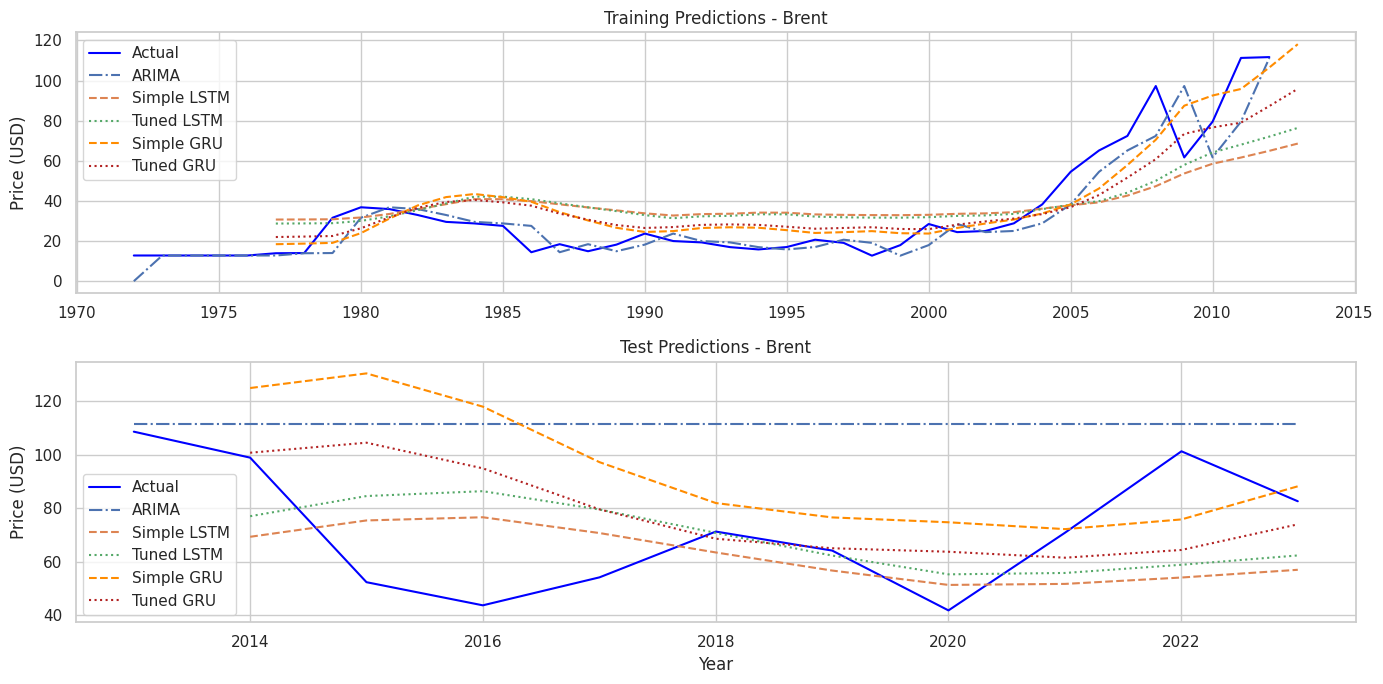


Performance Comparison for Brent:
Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)
   MAE       6.694797     39.837788            17.069102           21.573475           15.812218          21.573475           10.312164          30.979520          11.552369         21.097556
   MSE     115.746178   2088.444803           444.962999          660.386680          370.910935         660.386680          150.449989        1617.621154         196.839967        800.301827
  RMSE      10.758540     45.699506            21.094146           25.697990           19.259048          25.697990           12.265806          40.219661          14.029967         28.289606
    R²       0.835547     -3.165265             0.479034           -0.641311            0.565735          -0.641311            0.823852          -3.020401           0.769538         -0.989053

Comp

Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  \
0    MAE       6.694797     39.837788            17.069102   
1    MSE     115.746178   2088.444803           444.962999   
2   RMSE      10.758540     45.699506            21.094146   
3     R²       0.835547     -3.165265             0.479034   

   Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  \
0           21.573475           15.812218          21.573475   
1          660.386680          370.910935         660.386680   
2           25.697990           19.259048          25.697990   
3           -0.641311            0.565735          -0.641311   

   Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)  
0           10.312164          30.979520          11.552369         21.097556  
1          150.449989        1617.621154         196.839967        800.301827  
2           12.265806          40.219661          14.029967         28.289606  
3            0.823852          -3.020401           0.769538         -0.989053

In [ ]:
brent_results = train_and_analyze_models(df_clean, 'Brent', window_size)

# Display comparison table
print("\nComparison Table for Brent:")
brent_results['comparison']

### ⦿ Region Nigerian

Trial 5 Complete [00h 00m 09s]
val_loss: 0.2563856244087219

Best val_loss So Far: 0.035769350826740265
Total elapsed time: 00h 00m 36s
Epoch 1/100
2/2 [==============================] - 5s 820ms/step - loss: 0.0913 - val_loss: 0.0334 - lr: 0.0100
Epoch 2/100
2/2 [==============================] - 0s 43ms/step - loss: 1.4549 - val_loss: 0.3196 - lr: 0.0100
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6470 - val_loss: 0.0457 - lr: 0.0100
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0583 - val_loss: 0.3440 - lr: 0.0100
Epoch 5/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0620 - val_loss: 0.2563 - lr: 0.0100
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0351 - val_loss: 0.1156 - lr: 0.0100
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0296 - val_loss: 0.0986 - lr: 0.0020
Epoch 8/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0324 - val_l

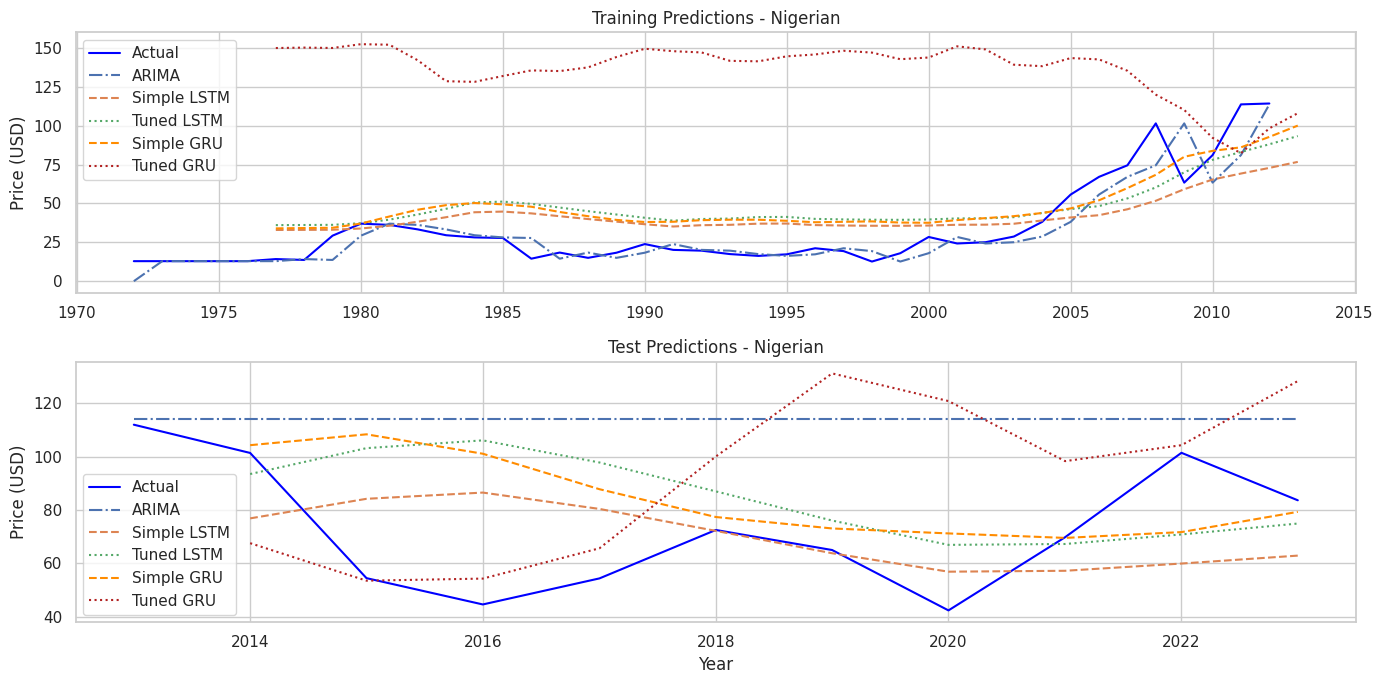


Performance Comparison for Nigerian:
Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)
   MAE       6.926686     41.390680            18.008103           25.361989           18.870194          25.361989           17.410106          22.294594         100.529367         30.412227
   MSE     125.131784   2236.949295           452.076284         1006.820499          438.087974        1006.820499          362.789719         905.379309       11596.572893       1549.339777
  RMSE      11.186232     47.296398            21.262086           31.730435           20.930551          31.730435           19.047040          30.089522         107.687385         39.361654
    R²       0.832987     -3.270936             0.504888           -1.469136            0.520208          -1.469136            0.602674          -1.220360         -11.700525         -2.799615

C

Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  \
0    MAE       6.926686     41.390680            18.008103   
1    MSE     125.131784   2236.949295           452.076284   
2   RMSE      11.186232     47.296398            21.262086   
3     R²       0.832987     -3.270936             0.504888   

   Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  \
0           25.361989           18.870194          25.361989   
1         1006.820499          438.087974        1006.820499   
2           31.730435           20.930551          31.730435   
3           -1.469136            0.520208          -1.469136   

   Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)  
0           17.410106          22.294594         100.529367         30.412227  
1          362.789719         905.379309       11596.572893       1549.339777  
2           19.047040          30.089522         107.687385         39.361654  
3            0.602674          -1.220360         -11.700525         -2.799615

In [ ]:
nigerian_results = train_and_analyze_models(df_clean, 'Nigerian', window_size)

# Display comparison table
print("\nComparison Table for Nigerian_Forcados:")
nigerian_results['comparison']

### ⦿ Region West Texas

Trial 5 Complete [00h 00m 09s]
val_loss: 0.2592703700065613

Best val_loss So Far: 0.2592703700065613
Total elapsed time: 00h 00m 41s
Epoch 1/100
2/2 [==============================] - 5s 793ms/step - loss: 0.1070 - val_loss: 0.8635 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0927 - val_loss: 0.8222 - lr: 1.0000e-04
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0896 - val_loss: 0.7972 - lr: 1.0000e-04
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0829 - val_loss: 0.7753 - lr: 1.0000e-04
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0843 - val_loss: 0.7517 - lr: 1.0000e-04
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0804 - val_loss: 0.7297 - lr: 1.0000e-04
Epoch 7/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0817 - val_loss: 0.6818 - lr: 1.0000e-04
Epoch 8/100
2/2 [==============================] - 0s 39ms/s

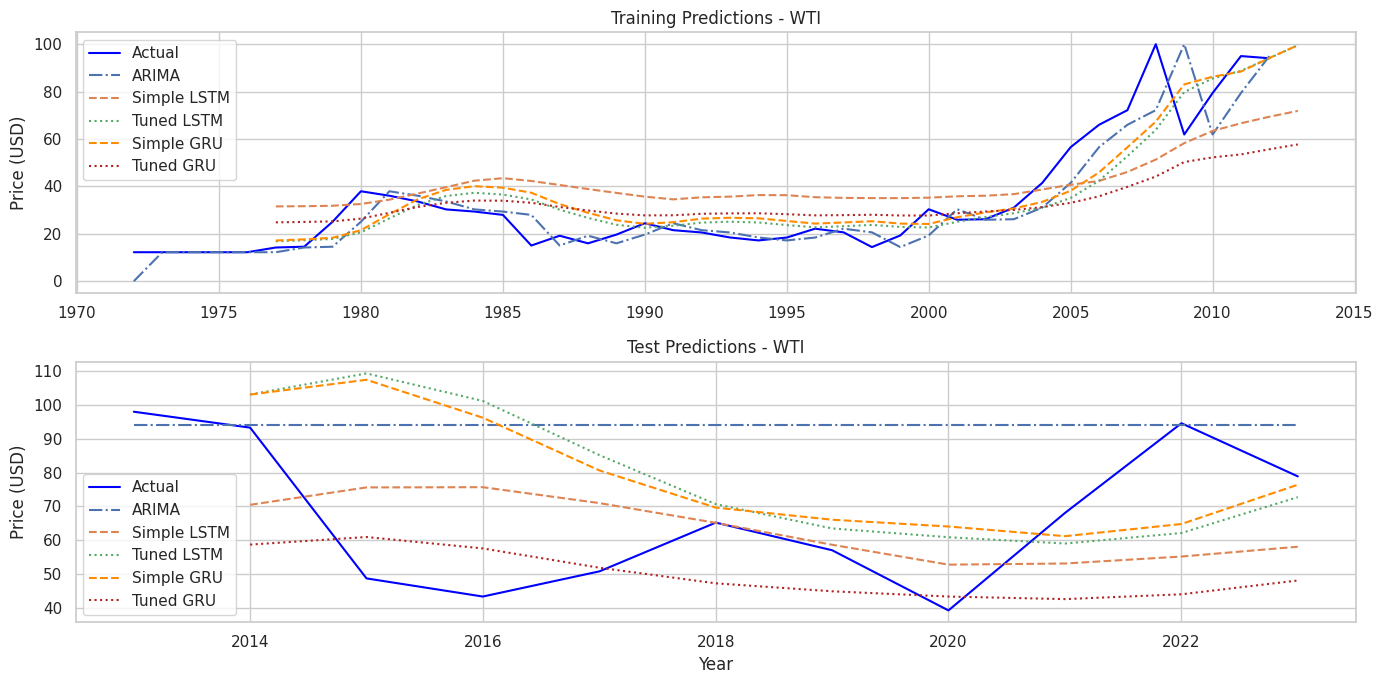


Performance Comparison for WTI:
Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)
   MAE       6.424085     27.897906            15.749498           24.382883            8.294052          24.382883            8.677596          22.866141          13.877319         20.317871
   MSE     102.274084   1151.840780           331.757691         1000.913218          129.862591        1000.913218          127.517955         888.900905         364.055812        619.203643
  RMSE      10.113065     33.938780            18.214217           31.637213           11.395727          31.637213           11.292385          29.814441          19.080247         24.883803
    R²       0.827085     -1.763889             0.518680           -1.836581            0.811593          -1.836581            0.814995          -1.519139           0.471822         -0.754819

Compar

Metric  ARIMA (Train)  ARIMA (Test)  Simple LSTM (Train)  \
0    MAE       6.424085     27.897906            15.749498   
1    MSE     102.274084   1151.840780           331.757691   
2   RMSE      10.113065     33.938780            18.214217   
3     R²       0.827085     -1.763889             0.518680   

   Simple LSTM (Test)  Tuned LSTM (Train)  Tuned LSTM (Test)  \
0           24.382883            8.294052          24.382883   
1         1000.913218          129.862591        1000.913218   
2           31.637213           11.395727          31.637213   
3           -1.836581            0.811593          -1.836581   

   Simple GRU (Train)  Simple GRU (Test)  Tuned GRU (Train)  Tuned GRU (Test)  
0            8.677596          22.866141          13.877319         20.317871  
1          127.517955         888.900905         364.055812        619.203643  
2           11.292385          29.814441          19.080247         24.883803  
3            0.814995          -1.519139           0.471822         -0.754819

In [ ]:
wti_results = train_and_analyze_models(df_clean, 'WTI', window_size)

# Display comparison table
print("\nComparison Table for WTI:")
wti_results['comparison']

### ⦿ Final Comparison

In [ ]:
final_comparison = pd.DataFrame({
    'Region': ['Dubai', 'Brent', 'Nigerian', 'WTI'],

    # ARIMA Metrics
    'ARIMA (Train MAE)': [
        dubai_results['arima']['train_metrics']['MAE'],
        brent_results['arima']['train_metrics']['MAE'],
        nigerian_results['arima']['train_metrics']['MAE'],
        wti_results['arima']['train_metrics']['MAE']
    ],
    'ARIMA (Test MAE)': [
        dubai_results['arima']['test_metrics']['MAE'],
        brent_results['arima']['test_metrics']['MAE'],
        nigerian_results['arima']['test_metrics']['MAE'],
        wti_results['arima']['test_metrics']['MAE']
    ],
    'ARIMA (Train R²)': [
        dubai_results['arima']['train_metrics']['R2'],
        brent_results['arima']['train_metrics']['R2'],
        nigerian_results['arima']['train_metrics']['R2'],
        wti_results['arima']['train_metrics']['R2']
    ],
    'ARIMA (Test R²)': [
        dubai_results['arima']['test_metrics']['R2'],
        brent_results['arima']['test_metrics']['R2'],
        nigerian_results['arima']['test_metrics']['R2'],
        wti_results['arima']['test_metrics']['R2']
    ],
    'ARIMA (Train MSE)': [
        dubai_results['arima']['train_metrics']['MSE'],
        brent_results['arima']['train_metrics']['MSE'],
        nigerian_results['arima']['train_metrics']['MSE'],
        wti_results['arima']['train_metrics']['MSE']
    ],
    'ARIMA (Test MSE)': [
        dubai_results['arima']['test_metrics']['MSE'],
        brent_results['arima']['test_metrics']['MSE'],
        nigerian_results['arima']['test_metrics']['MSE'],
        wti_results['arima']['test_metrics']['MSE']
    ],
    'ARIMA (Train RMSE)': [
        dubai_results['arima']['train_metrics']['RMSE'],
        brent_results['arima']['train_metrics']['RMSE'],
        nigerian_results['arima']['train_metrics']['RMSE'],
        wti_results['arima']['train_metrics']['RMSE']
    ],
    'ARIMA (Test RMSE)': [
        dubai_results['arima']['test_metrics']['RMSE'],
        brent_results['arima']['test_metrics']['RMSE'],
        nigerian_results['arima']['test_metrics']['RMSE'],
        wti_results['arima']['test_metrics']['RMSE']
    ],

    # Simple LSTM Metrics
    'Simple LSTM (Train MAE)': [
        dubai_results['simple']['train_metrics']['MAE'],
        brent_results['simple']['train_metrics']['MAE'],
        nigerian_results['simple']['train_metrics']['MAE'],
        wti_results['simple']['train_metrics']['MAE']
    ],
    'Simple LSTM (Test MAE)': [
        dubai_results['simple']['test_metrics']['MAE'],
        brent_results['simple']['test_metrics']['MAE'],
        nigerian_results['simple']['test_metrics']['MAE'],
        wti_results['simple']['test_metrics']['MAE']
    ],
    'Simple LSTM (Train R²)': [
        dubai_results['simple']['train_metrics']['R2'],
        brent_results['simple']['train_metrics']['R2'],
        nigerian_results['simple']['train_metrics']['R2'],
        wti_results['simple']['train_metrics']['R2']
    ],
    'Simple LSTM (Test R²)': [
        dubai_results['simple']['test_metrics']['R2'],
        brent_results['simple']['test_metrics']['R2'],
        nigerian_results['simple']['test_metrics']['R2'],
        wti_results['simple']['test_metrics']['R2']
    ],
    'Simple LSTM (Train MSE)': [
        dubai_results['simple']['train_metrics']['MSE'],
        brent_results['simple']['train_metrics']['MSE'],
        nigerian_results['simple']['train_metrics']['MSE'],
        wti_results['simple']['train_metrics']['MSE']
    ],
    'Simple LSTM (Test MSE)': [
        dubai_results['simple']['test_metrics']['MSE'],
        brent_results['simple']['test_metrics']['MSE'],
        nigerian_results['simple']['test_metrics']['MSE'],
        wti_results['simple']['test_metrics']['MSE']
    ],
    'Simple LSTM (Train RMSE)': [
        dubai_results['simple']['train_metrics']['RMSE'],
        brent_results['simple']['train_metrics']['RMSE'],
        nigerian_results['simple']['train_metrics']['RMSE'],
        wti_results['simple']['train_metrics']['RMSE']
    ],
    'Simple LSTM (Test RMSE)': [
        dubai_results['simple']['test_metrics']['RMSE'],
        brent_results['simple']['test_metrics']['RMSE'],
        nigerian_results['simple']['test_metrics']['RMSE'],
        wti_results['simple']['test_metrics']['RMSE']
    ],

    # Tuned LSTM Metrics
    'Tuned LSTM (Train MAE)': [
        dubai_results['hyper']['train_metrics']['MAE'],
        brent_results['hyper']['train_metrics']['MAE'],
        nigerian_results['hyper']['train_metrics']['MAE'],
        wti_results['hyper']['train_metrics']['MAE']
    ],
    'Tuned LSTM (Test MAE)': [
        dubai_results['hyper']['test_metrics']['MAE'],
        brent_results['hyper']['test_metrics']['MAE'],
        nigerian_results['hyper']['test_metrics']['MAE'],
        wti_results['hyper']['test_metrics']['MAE']
    ],
    'Tuned LSTM (Train R²)': [
        dubai_results['hyper']['train_metrics']['R2'],
        brent_results['hyper']['train_metrics']['R2'],
        nigerian_results['hyper']['train_metrics']['R2'],
        wti_results['hyper']['train_metrics']['R2']
    ],
    'Tuned LSTM (Test R²)': [
        dubai_results['hyper']['test_metrics']['R2'],
        brent_results['hyper']['test_metrics']['R2'],
        nigerian_results['hyper']['test_metrics']['R2'],
        wti_results['hyper']['test_metrics']['R2']
    ],
    'Tuned LSTM (Train MSE)': [
        dubai_results['hyper']['train_metrics']['MSE'],
        brent_results['hyper']['train_metrics']['MSE'],
        nigerian_results['hyper']['train_metrics']['MSE'],
        wti_results['hyper']['train_metrics']['MSE']
    ],
    'Tuned LSTM (Test MSE)': [
        dubai_results['hyper']['test_metrics']['MSE'],
        brent_results['hyper']['test_metrics']['MSE'],
        nigerian_results['hyper']['test_metrics']['MSE'],
        wti_results['hyper']['test_metrics']['MSE']
    ],
    'Tuned LSTM (Train RMSE)': [
        dubai_results['hyper']['train_metrics']['RMSE'],
        brent_results['hyper']['train_metrics']['RMSE'],
        nigerian_results['hyper']['train_metrics']['RMSE'],
        wti_results['hyper']['train_metrics']['RMSE']
    ],
    'Tuned LSTM (Test RMSE)': [
        dubai_results['hyper']['test_metrics']['RMSE'],
        brent_results['hyper']['test_metrics']['RMSE'],
        nigerian_results['hyper']['test_metrics']['RMSE'],
        wti_results['hyper']['test_metrics']['RMSE']
    ],

    # Simple GRU Metrics
    'Simple GRU (Train MAE)': [
        dubai_results['simple_gru']['train_metrics']['MAE'],
        brent_results['simple_gru']['train_metrics']['MAE'],
        nigerian_results['simple_gru']['train_metrics']['MAE'],
        wti_results['simple_gru']['train_metrics']['MAE']
    ],
    'Simple GRU (Test MAE)': [
        dubai_results['simple_gru']['test_metrics']['MAE'],
        brent_results['simple_gru']['test_metrics']['MAE'],
        nigerian_results['simple_gru']['test_metrics']['MAE'],
        wti_results['simple_gru']['test_metrics']['MAE']
    ],
    'Simple GRU (Train R²)': [
        dubai_results['simple_gru']['train_metrics']['R2'],
        brent_results['simple_gru']['train_metrics']['R2'],
        nigerian_results['simple_gru']['train_metrics']['R2'],
        wti_results['simple_gru']['train_metrics']['R2']
    ],
    'Simple GRU (Test R²)': [
        dubai_results['simple_gru']['test_metrics']['R2'],
        brent_results['simple_gru']['test_metrics']['R2'],
        nigerian_results['simple_gru']['test_metrics']['R2'],
        wti_results['simple_gru']['test_metrics']['R2']
    ],
    'Simple GRU (Train MSE)': [
        dubai_results['simple_gru']['train_metrics']['MSE'],
        brent_results['simple_gru']['train_metrics']['MSE'],
        nigerian_results['simple_gru']['train_metrics']['MSE'],
        wti_results['simple_gru']['train_metrics']['MSE']
    ],
    'Simple GRU (Test MSE)': [
        dubai_results['simple_gru']['test_metrics']['MSE'],
        brent_results['simple_gru']['test_metrics']['MSE'],
        nigerian_results['simple_gru']['test_metrics']['MSE'],
        wti_results['simple_gru']['test_metrics']['MSE']
    ],
    'Simple GRU (Train RMSE)': [
        dubai_results['simple_gru']['train_metrics']['RMSE'],
        brent_results['simple_gru']['train_metrics']['RMSE'],
        nigerian_results['simple_gru']['train_metrics']['RMSE'],
        wti_results['simple_gru']['train_metrics']['RMSE']
    ],
    'Simple GRU (Test RMSE)': [
        dubai_results['simple_gru']['test_metrics']['RMSE'],
        brent_results['simple_gru']['test_metrics']['RMSE'],
        nigerian_results['simple_gru']['test_metrics']['RMSE'],
        wti_results['simple_gru']['test_metrics']['RMSE']
    ],

    # Tuned GRU Metrics
    'Tuned GRU (Train MAE)': [
        dubai_results['tuned_gru']['train_metrics']['MAE'],
        brent_results['tuned_gru']['train_metrics']['MAE'],
        nigerian_results['tuned_gru']['train_metrics']['MAE'],
        wti_results['tuned_gru']['train_metrics']['MAE']
    ],
    'Tuned GRU (Test MAE)': [
        dubai_results['tuned_gru']['test_metrics']['MAE'],
        brent_results['tuned_gru']['test_metrics']['MAE'],
        nigerian_results['tuned_gru']['test_metrics']['MAE'],
        wti_results['tuned_gru']['test_metrics']['MAE']
    ],
    'Tuned GRU (Train R²)': [
        dubai_results['tuned_gru']['train_metrics']['R2'],
        brent_results['tuned_gru']['train_metrics']['R2'],
        nigerian_results['tuned_gru']['train_metrics']['R2'],
        wti_results['tuned_gru']['train_metrics']['R2']
    ],
    'Tuned GRU (Test R²)': [
        dubai_results['tuned_gru']['test_metrics']['R2'],
        brent_results['tuned_gru']['test_metrics']['R2'],
        nigerian_results['tuned_gru']['test_metrics']['R2'],
        wti_results['tuned_gru']['test_metrics']['R2']
    ],
    'Tuned GRU (Train MSE)': [
        dubai_results['tuned_gru']['train_metrics']['MSE'],
        brent_results['tuned_gru']['train_metrics']['MSE'],
        nigerian_results['tuned_gru']['train_metrics']['MSE'],
        wti_results['tuned_gru']['train_metrics']['MSE']
    ],
    'Tuned GRU (Test MSE)': [
        dubai_results['tuned_gru']['test_metrics']['MSE'],
        brent_results['tuned_gru']['test_metrics']['MSE'],
        nigerian_results['tuned_gru']['test_metrics']['MSE'],
        wti_results['tuned_gru']['test_metrics']['MSE']
    ],
    'Tuned GRU (Train RMSE)': [
        dubai_results['tuned_gru']['train_metrics']['RMSE'],
        brent_results['tuned_gru']['train_metrics']['RMSE'],
        nigerian_results['tuned_gru']['train_metrics']['RMSE'],
        wti_results['tuned_gru']['train_metrics']['RMSE']
    ],
    'Tuned GRU (Test RMSE)': [
        dubai_results['tuned_gru']['test_metrics']['RMSE'],
        brent_results['tuned_gru']['test_metrics']['RMSE'],
        nigerian_results['tuned_gru']['test_metrics']['RMSE'],
        wti_results['tuned_gru']['test_metrics']['RMSE']
    ]
})

print("\nFinal Comparison Across All Regions (Including Train Metrics):")
final_comparison


Final Comparison Across All Regions (Including Train Metrics):


Region  ARIMA (Train MAE)  ARIMA (Test MAE)  ARIMA (Train R²)  \
0     Dubai           6.364212         38.929925          0.851100   
1     Brent           6.694797         39.837788          0.835547   
2  Nigerian           6.926686         41.390680          0.832987   
3       WTI           6.424085         27.897906          0.827085   

   ARIMA (Test R²)  ARIMA (Train MSE)  ARIMA (Test MSE)  ARIMA (Train RMSE)  \
0        -3.260954         102.689050       1980.292388           10.133561   
1        -3.165265         115.746178       2088.444803           10.758540   
2        -3.270936         125.131784       2236.949295           11.186232   
3        -1.763889         102.274084       1151.840780           10.113065   

   ARIMA (Test RMSE)  Simple LSTM (Train MAE)  ...  Simple GRU (Train RMSE)  \
0          44.500476                15.566462  ...                18.028515   
1          45.699506                17.069102  ...                12.265806   
2          47.296398                18.008103  ...                19.047040   
3          33.938780                15.749498  ...                11.292385   

   Simple GRU (Test RMSE)  Tuned GRU (Train MAE)  Tuned GRU (Test MAE)  \
0               23.823075              14.956116             23.114296   
1               40.219661              11.552369             21.097556   
2               30.089522             100.529367             30.412227   
3               29.814441              13.877319             20.317871   

   Tuned GRU (Train R²)  Tuned GRU (Test R²)  Tuned GRU (Train MSE)  \
0              0.411580            -1.117132             478.233057   
1              0.769538            -0.989053             196.839967   
2            -11.700525            -2.799615           11596.572893   
3              0.471822            -0.754819             364.055812   

   Tuned GRU (Test MSE)  Tuned GRU (Train RMSE)  Tuned GRU (Test RMSE)  
0            791.500520               21.868540              28.133619  
1            800.301827               14.029967              28.289606  
2           1549.339777              107.687385              39.361654  
3            619.203643               19.080247              24.883803  

[4 rows x 41 columns]

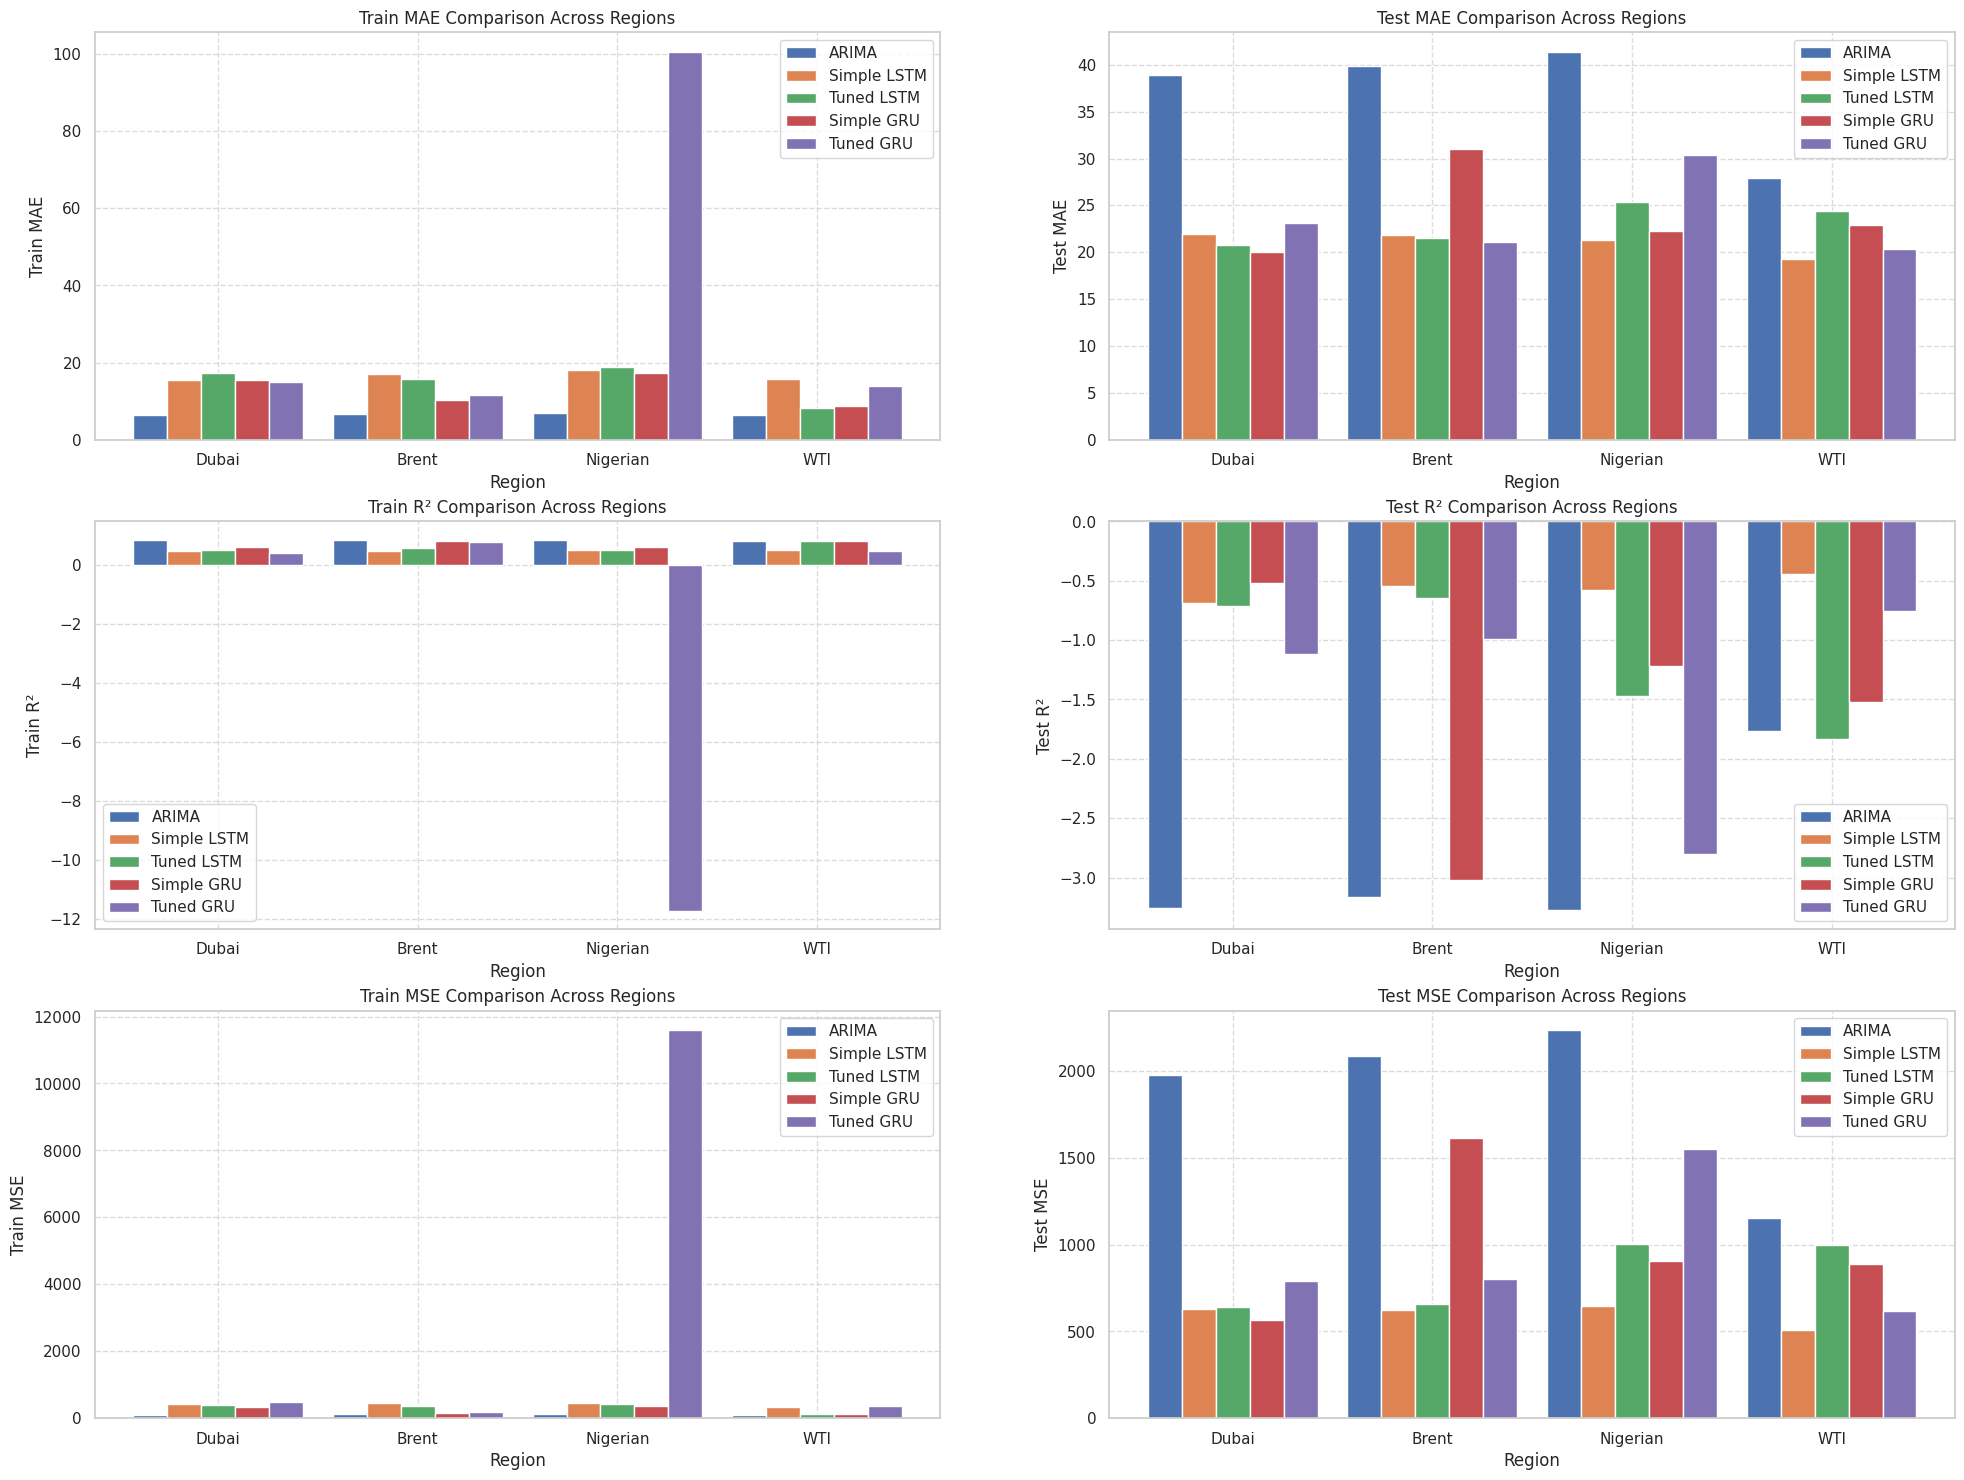

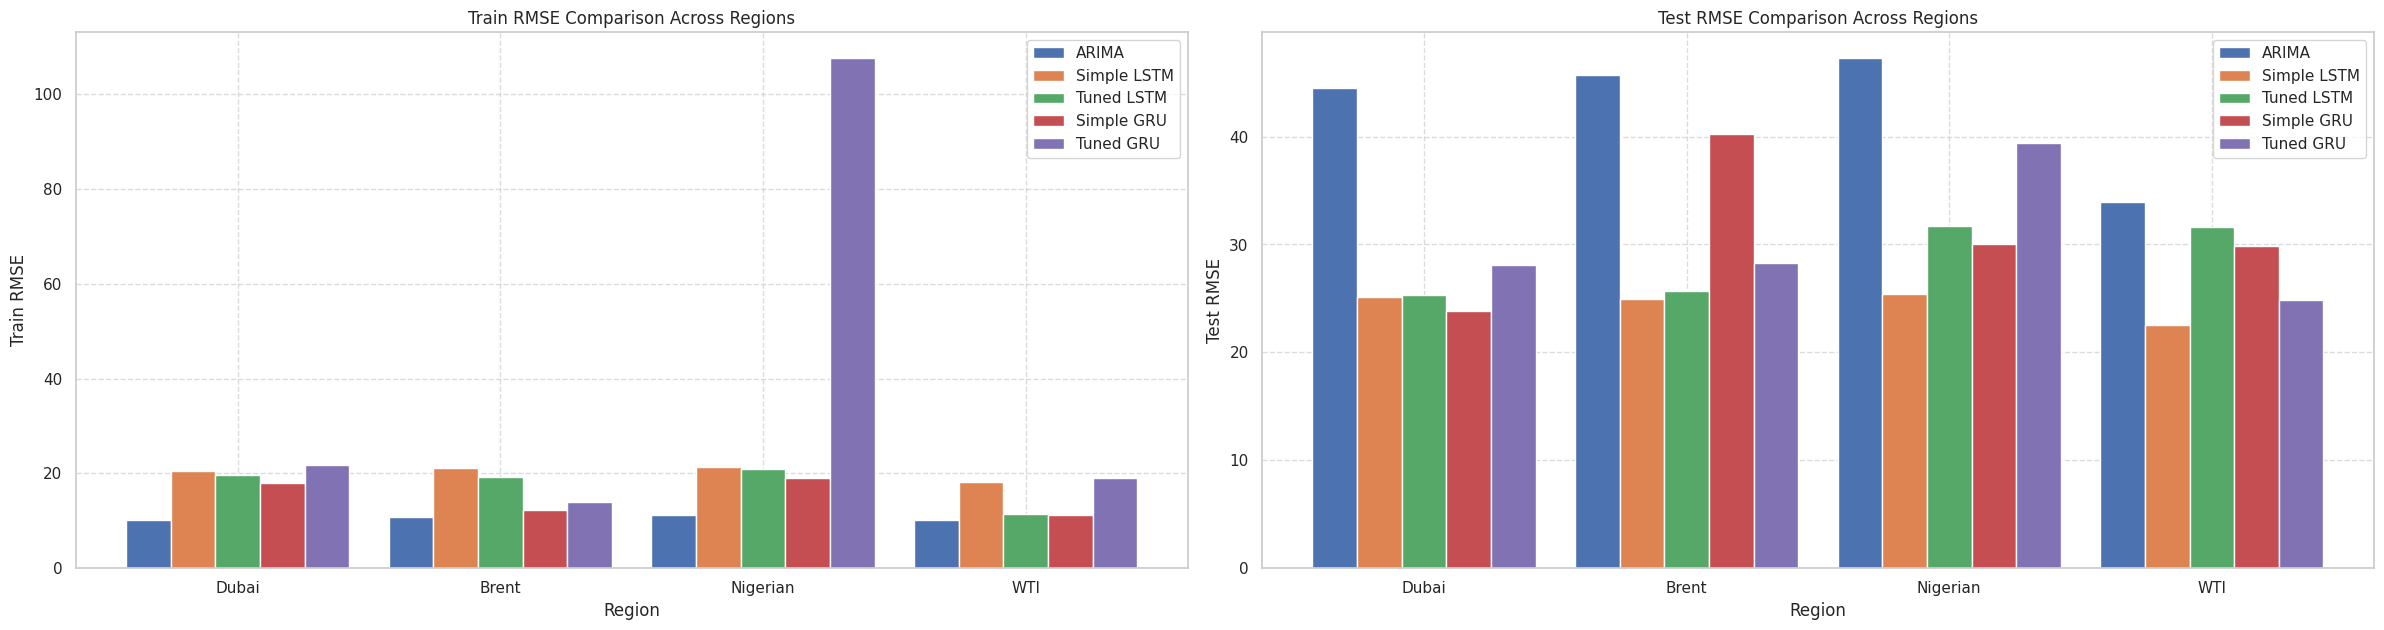

In [ ]:
# Plot perbandingan keseluruhan (Train & Test Metrics) terpisah pisah
plt.figure(figsize=(24, 18))

regions = ['Dubai', 'Brent', 'Nigerian', 'WTI']
x = np.arange(len(regions))
width = 0.17  # Narrower width to accommodate 5 bars

# perbandingan Train MAE
plt.subplot(3, 2, 1)
arima_train_mae = [
    dubai_results['arima']['train_metrics']['MAE'],
    brent_results['arima']['train_metrics']['MAE'],
    nigerian_results['arima']['train_metrics']['MAE'],
    wti_results['arima']['train_metrics']['MAE']
]
simple_train_mae = [
    dubai_results['simple']['train_metrics']['MAE'],
    brent_results['simple']['train_metrics']['MAE'],
    nigerian_results['simple']['train_metrics']['MAE'],
    wti_results['simple']['train_metrics']['MAE']
]
hyper_train_mae = [
    dubai_results['hyper']['train_metrics']['MAE'],
    brent_results['hyper']['train_metrics']['MAE'],
    nigerian_results['hyper']['train_metrics']['MAE'],
    wti_results['hyper']['train_metrics']['MAE']
]
simple_gru_train_mae = [
    dubai_results['simple_gru']['train_metrics']['MAE'],
    brent_results['simple_gru']['train_metrics']['MAE'],
    nigerian_results['simple_gru']['train_metrics']['MAE'],
    wti_results['simple_gru']['train_metrics']['MAE']
]
tuned_gru_train_mae = [
    dubai_results['tuned_gru']['train_metrics']['MAE'],
    brent_results['tuned_gru']['train_metrics']['MAE'],
    nigerian_results['tuned_gru']['train_metrics']['MAE'],
    wti_results['tuned_gru']['train_metrics']['MAE']
]

plt.bar(x - 2*width, arima_train_mae, width, label='ARIMA')
plt.bar(x - width, simple_train_mae, width, label='Simple LSTM')
plt.bar(x, hyper_train_mae, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_train_mae, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_train_mae, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Train MAE')
plt.title('Train MAE Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Test MAE
plt.subplot(3, 2, 2)
arima_test_mae = [
    dubai_results['arima']['test_metrics']['MAE'],
    brent_results['arima']['test_metrics']['MAE'],
    nigerian_results['arima']['test_metrics']['MAE'],
    wti_results['arima']['test_metrics']['MAE']
]
simple_test_mae = [
    dubai_results['simple']['test_metrics']['MAE'],
    brent_results['simple']['test_metrics']['MAE'],
    nigerian_results['simple']['test_metrics']['MAE'],
    wti_results['simple']['test_metrics']['MAE']
]
hyper_test_mae = [
    dubai_results['hyper']['test_metrics']['MAE'],
    brent_results['hyper']['test_metrics']['MAE'],
    nigerian_results['hyper']['test_metrics']['MAE'],
    wti_results['hyper']['test_metrics']['MAE']
]
simple_gru_test_mae = [
    dubai_results['simple_gru']['test_metrics']['MAE'],
    brent_results['simple_gru']['test_metrics']['MAE'],
    nigerian_results['simple_gru']['test_metrics']['MAE'],
    wti_results['simple_gru']['test_metrics']['MAE']
]
tuned_gru_test_mae = [
    dubai_results['tuned_gru']['test_metrics']['MAE'],
    brent_results['tuned_gru']['test_metrics']['MAE'],
    nigerian_results['tuned_gru']['test_metrics']['MAE'],
    wti_results['tuned_gru']['test_metrics']['MAE']
]

plt.bar(x - 2*width, arima_test_mae, width, label='ARIMA')
plt.bar(x - width, simple_test_mae, width, label='Simple LSTM')
plt.bar(x, hyper_test_mae, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_test_mae, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_test_mae, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Test MAE')
plt.title('Test MAE Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Train R²
plt.subplot(3, 2, 3)
arima_train_r2 = [
    dubai_results['arima']['train_metrics']['R2'],
    brent_results['arima']['train_metrics']['R2'],
    nigerian_results['arima']['train_metrics']['R2'],
    wti_results['arima']['train_metrics']['R2']
]
simple_train_r2 = [
    dubai_results['simple']['train_metrics']['R2'],
    brent_results['simple']['train_metrics']['R2'],
    nigerian_results['simple']['train_metrics']['R2'],
    wti_results['simple']['train_metrics']['R2']
]
hyper_train_r2 = [
    dubai_results['hyper']['train_metrics']['R2'],
    brent_results['hyper']['train_metrics']['R2'],
    nigerian_results['hyper']['train_metrics']['R2'],
    wti_results['hyper']['train_metrics']['R2']
]
simple_gru_train_r2 = [
    dubai_results['simple_gru']['train_metrics']['R2'],
    brent_results['simple_gru']['train_metrics']['R2'],
    nigerian_results['simple_gru']['train_metrics']['R2'],
    wti_results['simple_gru']['train_metrics']['R2']
]
tuned_gru_train_r2 = [
    dubai_results['tuned_gru']['train_metrics']['R2'],
    brent_results['tuned_gru']['train_metrics']['R2'],
    nigerian_results['tuned_gru']['train_metrics']['R2'],
    wti_results['tuned_gru']['train_metrics']['R2']
]

plt.bar(x - 2*width, arima_train_r2, width, label='ARIMA')
plt.bar(x - width, simple_train_r2, width, label='Simple LSTM')
plt.bar(x, hyper_train_r2, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_train_r2, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_train_r2, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Train R²')
plt.title('Train R² Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Test R²
plt.subplot(3, 2, 4)
arima_test_r2 = [
    dubai_results['arima']['test_metrics']['R2'],
    brent_results['arima']['test_metrics']['R2'],
    nigerian_results['arima']['test_metrics']['R2'],
    wti_results['arima']['test_metrics']['R2']
]
simple_test_r2 = [
    dubai_results['simple']['test_metrics']['R2'],
    brent_results['simple']['test_metrics']['R2'],
    nigerian_results['simple']['test_metrics']['R2'],
    wti_results['simple']['test_metrics']['R2']
]
hyper_test_r2 = [
    dubai_results['hyper']['test_metrics']['R2'],
    brent_results['hyper']['test_metrics']['R2'],
    nigerian_results['hyper']['test_metrics']['R2'],
    wti_results['hyper']['test_metrics']['R2']
]
simple_gru_test_r2 = [
    dubai_results['simple_gru']['test_metrics']['R2'],
    brent_results['simple_gru']['test_metrics']['R2'],
    nigerian_results['simple_gru']['test_metrics']['R2'],
    wti_results['simple_gru']['test_metrics']['R2']
]
tuned_gru_test_r2 = [
    dubai_results['tuned_gru']['test_metrics']['R2'],
    brent_results['tuned_gru']['test_metrics']['R2'],
    nigerian_results['tuned_gru']['test_metrics']['R2'],
    wti_results['tuned_gru']['test_metrics']['R2']
]

plt.bar(x - 2*width, arima_test_r2, width, label='ARIMA')
plt.bar(x - width, simple_test_r2, width, label='Simple LSTM')
plt.bar(x, hyper_test_r2, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_test_r2, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_test_r2, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Test R²')
plt.title('Test R² Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Train MSE
plt.subplot(3, 2, 5)
arima_train_mse = [
    dubai_results['arima']['train_metrics']['MSE'],
    brent_results['arima']['train_metrics']['MSE'],
    nigerian_results['arima']['train_metrics']['MSE'],
    wti_results['arima']['train_metrics']['MSE']
]
simple_train_mse = [
    dubai_results['simple']['train_metrics']['MSE'],
    brent_results['simple']['train_metrics']['MSE'],
    nigerian_results['simple']['train_metrics']['MSE'],
    wti_results['simple']['train_metrics']['MSE']
]
hyper_train_mse = [
    dubai_results['hyper']['train_metrics']['MSE'],
    brent_results['hyper']['train_metrics']['MSE'],
    nigerian_results['hyper']['train_metrics']['MSE'],
    wti_results['hyper']['train_metrics']['MSE']
]
simple_gru_train_mse = [
    dubai_results['simple_gru']['train_metrics']['MSE'],
    brent_results['simple_gru']['train_metrics']['MSE'],
    nigerian_results['simple_gru']['train_metrics']['MSE'],
    wti_results['simple_gru']['train_metrics']['MSE']
]
tuned_gru_train_mse = [
    dubai_results['tuned_gru']['train_metrics']['MSE'],
    brent_results['tuned_gru']['train_metrics']['MSE'],
    nigerian_results['tuned_gru']['train_metrics']['MSE'],
    wti_results['tuned_gru']['train_metrics']['MSE']
]

plt.bar(x - 2*width, arima_train_mse, width, label='ARIMA')
plt.bar(x - width, simple_train_mse, width, label='Simple LSTM')
plt.bar(x, hyper_train_mse, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_train_mse, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_train_mse, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Train MSE')
plt.title('Train MSE Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Test MSE
plt.subplot(3, 2, 6)
arima_test_mse = [
    dubai_results['arima']['test_metrics']['MSE'],
    brent_results['arima']['test_metrics']['MSE'],
    nigerian_results['arima']['test_metrics']['MSE'],
    wti_results['arima']['test_metrics']['MSE']
]
simple_test_mse = [
    dubai_results['simple']['test_metrics']['MSE'],
    brent_results['simple']['test_metrics']['MSE'],
    nigerian_results['simple']['test_metrics']['MSE'],
    wti_results['simple']['test_metrics']['MSE']
]
hyper_test_mse = [
    dubai_results['hyper']['test_metrics']['MSE'],
    brent_results['hyper']['test_metrics']['MSE'],
    nigerian_results['hyper']['test_metrics']['MSE'],
    wti_results['hyper']['test_metrics']['MSE']
]
simple_gru_test_mse = [
    dubai_results['simple_gru']['test_metrics']['MSE'],
    brent_results['simple_gru']['test_metrics']['MSE'],
    nigerian_results['simple_gru']['test_metrics']['MSE'],
    wti_results['simple_gru']['test_metrics']['MSE']
]
tuned_gru_test_mse = [
    dubai_results['tuned_gru']['test_metrics']['MSE'],
    brent_results['tuned_gru']['test_metrics']['MSE'],
    nigerian_results['tuned_gru']['test_metrics']['MSE'],
    wti_results['tuned_gru']['test_metrics']['MSE']
]

plt.bar(x - 2*width, arima_test_mse, width, label='ARIMA')
plt.bar(x - width, simple_test_mse, width, label='Simple LSTM')
plt.bar(x, hyper_test_mse, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_test_mse, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_test_mse, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Test MSE')
plt.title('Test MSE Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Train RMSE
plt.figure(figsize=(24, 12))
plt.subplot(2, 2, 1)
arima_train_rmse = [
    dubai_results['arima']['train_metrics']['RMSE'],
    brent_results['arima']['train_metrics']['RMSE'],
    nigerian_results['arima']['train_metrics']['RMSE'],
    wti_results['arima']['train_metrics']['RMSE']
]
simple_train_rmse = [
    dubai_results['simple']['train_metrics']['RMSE'],
    brent_results['simple']['train_metrics']['RMSE'],
    nigerian_results['simple']['train_metrics']['RMSE'],
    wti_results['simple']['train_metrics']['RMSE']
]
hyper_train_rmse = [
    dubai_results['hyper']['train_metrics']['RMSE'],
    brent_results['hyper']['train_metrics']['RMSE'],
    nigerian_results['hyper']['train_metrics']['RMSE'],
    wti_results['hyper']['train_metrics']['RMSE']
]
simple_gru_train_rmse = [
    dubai_results['simple_gru']['train_metrics']['RMSE'],
    brent_results['simple_gru']['train_metrics']['RMSE'],
    nigerian_results['simple_gru']['train_metrics']['RMSE'],
    wti_results['simple_gru']['train_metrics']['RMSE']
]
tuned_gru_train_rmse = [
    dubai_results['tuned_gru']['train_metrics']['RMSE'],
    brent_results['tuned_gru']['train_metrics']['RMSE'],
    nigerian_results['tuned_gru']['train_metrics']['RMSE'],
    wti_results['tuned_gru']['train_metrics']['RMSE']
]

plt.bar(x - 2*width, arima_train_rmse, width, label='ARIMA')
plt.bar(x - width, simple_train_rmse, width, label='Simple LSTM')
plt.bar(x, hyper_train_rmse, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_train_rmse, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_train_rmse, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Train RMSE')
plt.title('Train RMSE Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# perbandingan Test RMSE
plt.subplot(2, 2, 2)
arima_test_rmse = [
    dubai_results['arima']['test_metrics']['RMSE'],
    brent_results['arima']['test_metrics']['RMSE'],
    nigerian_results['arima']['test_metrics']['RMSE'],
    wti_results['arima']['test_metrics']['RMSE']
]
simple_test_rmse = [
    dubai_results['simple']['test_metrics']['RMSE'],
    brent_results['simple']['test_metrics']['RMSE'],
    nigerian_results['simple']['test_metrics']['RMSE'],
    wti_results['simple']['test_metrics']['RMSE']
]
hyper_test_rmse = [
    dubai_results['hyper']['test_metrics']['RMSE'],
    brent_results['hyper']['test_metrics']['RMSE'],
    nigerian_results['hyper']['test_metrics']['RMSE'],
    wti_results['hyper']['test_metrics']['RMSE']
]
simple_gru_test_rmse = [
    dubai_results['simple_gru']['test_metrics']['RMSE'],
    brent_results['simple_gru']['test_metrics']['RMSE'],
    nigerian_results['simple_gru']['test_metrics']['RMSE'],
    wti_results['simple_gru']['test_metrics']['RMSE']
]
tuned_gru_test_rmse = [
    dubai_results['tuned_gru']['test_metrics']['RMSE'],
    brent_results['tuned_gru']['test_metrics']['RMSE'],
    nigerian_results['tuned_gru']['test_metrics']['RMSE'],
    wti_results['tuned_gru']['test_metrics']['RMSE']
]

plt.bar(x - 2*width, arima_test_rmse, width, label='ARIMA')
plt.bar(x - width, simple_test_rmse, width, label='Simple LSTM')
plt.bar(x, hyper_test_rmse, width, label='Tuned LSTM')
plt.bar(x + width, simple_gru_test_rmse, width, label='Simple GRU')
plt.bar(x + 2*width, tuned_gru_test_rmse, width, label='Tuned GRU')
plt.xlabel('Region')
plt.ylabel('Test RMSE')
plt.title('Test RMSE Comparison Across Regions')
plt.xticks(x, regions)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4 - Testing and Evaluate The Models

## a. The Functions

In [ ]:
def forecast_future_arima(model_results, df, region, steps_ahead=5):
    # Forecast using ARIMA
    forecast = model_results['model'].predict(n_periods=steps_ahead, return_conf_int=True, alpha=0.05)
    # Future years for forecasting
    last_year = df.index[-1].year
    future_years = pd.date_range(start=f'{last_year+1}-01-01', periods=steps_ahead, freq='AS')
    # Create DataFrame with forecasts
    forecast_df = pd.DataFrame({
        'Year': future_years,
        f'{region}_Forecast': forecast[0],
        f'{region}_Lower': forecast[1][:,0],
        f'{region}_Upper': forecast[1][:,1]
    }).set_index('Year')
    return forecast_df

In [ ]:
def forecast_future(model_results, df, region, steps_ahead=5):
    # Extract model and scaling information
    model = model_results['model']
    scaler_x = model_results['scaler_x']
    scaler_y = model_results['scaler_y']

    # Get the last window of data for prediction
    last_window = df[region].values[-window_size:].reshape(-1, 1)
    scaled_window = scaler_x.transform(last_window)

    # Create feature array for prediction
    X_forecast = scaled_window.reshape(1, window_size, 1)

    # Future years for forecasting
    last_year = df.index[-1].year
    future_years = pd.date_range(start=f'{last_year+1}-01-01', periods=steps_ahead, freq='AS')

    # Initialize forecasts
    forecasts = []

    # Generate forecasts
    for _ in range(steps_ahead):
        # Predict next value
        next_pred_scaled = model.predict(X_forecast, verbose=1)

        # Inverse transform the prediction
        next_pred = scaler_y.inverse_transform(next_pred_scaled)[0, 0]

        # Store the prediction
        forecasts.append(next_pred)

        # Update the window by removing the first value and adding the new prediction
        X_forecast_array = X_forecast[0]
        X_forecast_array = np.roll(X_forecast_array, -1, axis=0)
        X_forecast_array[-1, 0] = next_pred_scaled[0, 0]
        X_forecast = X_forecast_array.reshape(1, window_size, 1)

    # Create DataFrame with forecasts
    forecast_df = pd.DataFrame({
        'Year': future_years,
        f'{region}_Forecast': forecasts
    }).set_index('Year')

    return forecast_df

In [ ]:
def create_prediction_intervals(model_results, df, region, steps_ahead=5, alpha=0.05):
    # Get forecasts
    forecast_df = forecast_future(model_results, df, region, steps_ahead)

    # Calculate prediction error on test set
    test_errors = model_results['test_actual'] - model_results['test_predict']

    # Calculate standard deviation of errors
    error_std = np.std(test_errors)

    # Z-score for confidence interval
    z_score = 1.96  # For 95% confidence interval

    # Calculate prediction intervals
    forecast_df[f'{region}_Lower'] = forecast_df[f'{region}_Forecast'] - z_score * error_std
    forecast_df[f'{region}_Upper'] = forecast_df[f'{region}_Forecast'] + z_score * error_std

    return forecast_df

In [ ]:
def evaluate_model_performance_arima(model_results, df, region, show_plot=True):
    # Extract test predictions and actual values
    y_test = model_results['test_actual']
    y_pred = model_results['test_predict']

    # Calculate residuals
    residuals = y_test - y_pred

    # Basic metrics (already in model_results)
    metrics = model_results['test_metrics']

    # Calculate additional metrics
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Create figure and subplots
    if show_plot:
        plt.figure(figsize=(12, 8))

        # Residuals over time
        plt.subplot(2, 2, 1)
        plt.plot(model_results['test_indices'], residuals, 'o-')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Residuals Over Time')
        plt.xlabel('Year')
        plt.ylabel('Residual')
        plt.grid(True)

        # Residuals histogram
        plt.subplot(2, 2, 2)
        plt.hist(residuals, bins=10, edgecolor='black')
        plt.title('Residuals Distribution')
        plt.xlabel('Residual Value')
        plt.ylabel('Frequency')
        plt.grid(True)

        # QQ plot
        plt.subplot(2, 2, 3)
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot')
        plt.grid(True)

        # Actual vs Predicted
        plt.subplot(2, 2, 4)
        plt.scatter(y_test, y_pred)
        min_val = min(np.min(y_test), np.min(y_pred))
        max_val = max(np.max(y_test), np.max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Actual vs Predicted')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Update metrics with additional ones
    metrics['MAPE'] = mape

    # Check for autocorrelation in residuals
    try:
        lb_test = acorr_ljungbox(residuals, lags=5)
        autocorr_pvalue = lb_test.iloc[0]['lb_pvalue']
        metrics['Ljung-Box p-value'] = autocorr_pvalue
        metrics['Residuals Independent'] = autocorr_pvalue > 0.05
    except:
        metrics['Ljung-Box p-value'] = None
        metrics['Residuals Independent'] = None

    return metrics

In [ ]:
def evaluate_model_performance(model_results, df, region, show_plot=True):
    # Extract test predictions and actual values
    y_test = model_results['test_actual']
    y_pred = model_results['test_predict']

    # Calculate residuals
    residuals = y_test - y_pred

    # Basic metrics (already in model_results)
    metrics = model_results['test_metrics']

    # Calculate additional metrics
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Create figure and subplots
    plt.figure(figsize=(12, 8))

    # Residuals over time
    plt.subplot(2, 2, 1)
    plt.plot(model_results['test_indices'], residuals, 'o-')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuals Over Time')
    plt.xlabel('Year')
    plt.ylabel('Residual')
    plt.grid(True)

    # Residuals histogram
    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=10, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.grid(True)

    # QQ plot
    plt.subplot(2, 2, 3)
    from scipy import stats
    stats.probplot(residuals.flatten(), dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.grid(True)

    # Actual vs Predicted
    plt.subplot(2, 2, 4)
    plt.scatter(y_test, y_pred)

    # Add perfect prediction line
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)

    plt.tight_layout()

    # Conditionally show or close the plot
    if show_plot:
        plt.show()
    else:
        plt.close()

    # Check for autocorrelation in residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    try:
        lb_test = acorr_ljungbox(residuals, lags=5)
        autocorr_pvalue = lb_test[1][0]
        metrics['Ljung-Box p-value'] = autocorr_pvalue
        metrics['Residuals Independent'] = autocorr_pvalue > 0.05
    except:
        metrics['Ljung-Box p-value'] = None
        metrics['Residuals Independent'] = None

    return metrics

In [ ]:
def compare_models(all_results, df_clean, include_arima=True, show_plot=False):
    regions = ['Dubai', 'Brent', 'Nigerian', 'WTI']
    comparison_data = []

    for region in regions:
        result = all_results[region]

        # Tambahkan semua model
        for model_key, model_name in [
            ('simple', 'Simple LSTM'),
            ('hyper', 'Tuned LSTM'),
            ('simple_gru', 'Simple GRU'),
            ('tuned_gru', 'Tuned GRU')
        ]:
            metrics = evaluate_model_performance(result[model_key], df_clean, region, show_plot=False)
            comparison_data.append({
                'Region': region,
                'Model': model_name,
                'MAE': metrics['MAE'],
                'MSE': metrics['MSE'],
                'RMSE': metrics['RMSE'],
                'R²': metrics['R2'],
            })

        if include_arima:
            arima_metrics = evaluate_model_performance_arima(result['arima'], df_clean, region, show_plot=False)
            comparison_data.append({
                'Region': region,
                'Model': 'ARIMA',
                'MAE': arima_metrics['MAE'],
                'MSE': arima_metrics['MSE'],
                'RMSE': arima_metrics['RMSE'],
                'R²': arima_metrics['R2'],
            })

    return pd.DataFrame(comparison_data)


## b. The Usages

### ⦿ Evaluation and Forecasting

In [ ]:
# Run model evaluation for all regions
print("\n" + "="*80)
print("MODEL EVALUATION AND FORECASTING")
print("="*80)


MODEL EVALUATION AND FORECASTING


In [ ]:
# Create a dictionary to store all results
all_results = {
    'Dubai': dubai_results,
    'Brent': brent_results,
    'Nigerian': nigerian_results,
    'WTI': wti_results
}

# Set future forecast horizon
forecast_years = 5


--------------------------------------------------
EVALUATING MODELS FOR Dubai
--------------------------------------------------

ARIMA Model Evaluation:


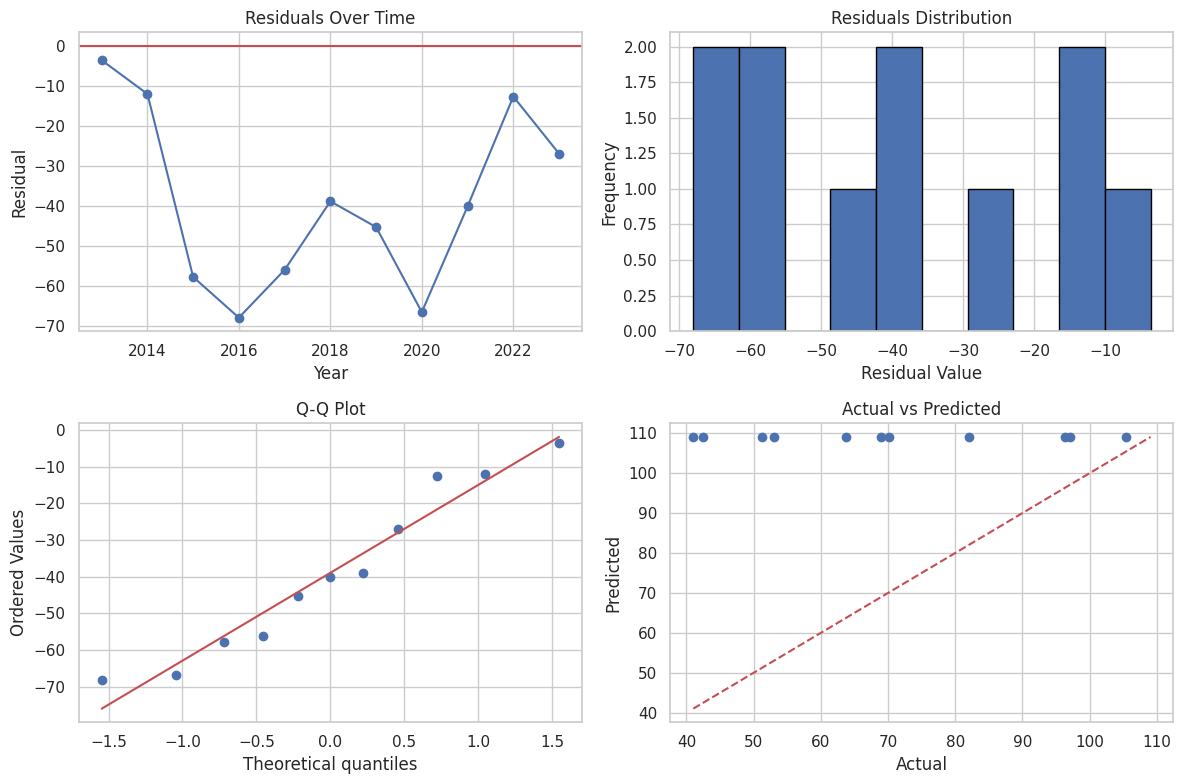


Simple LSTM Model Evaluation:


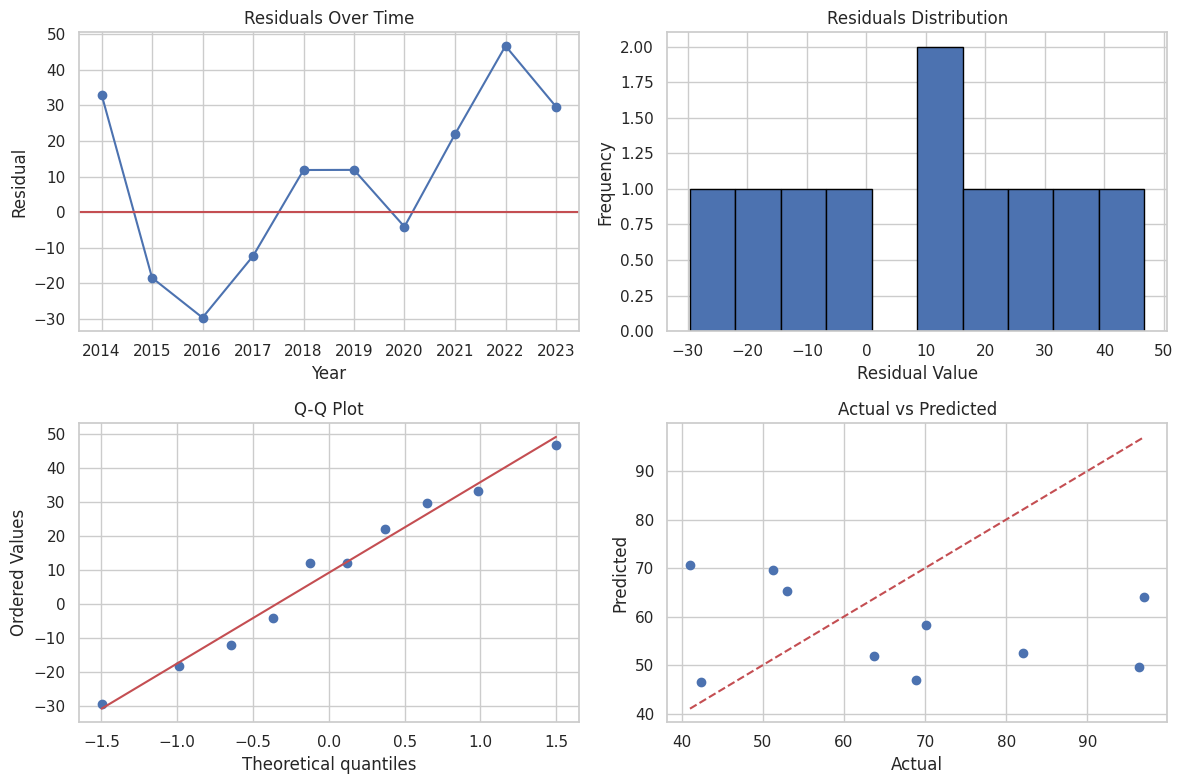


Tuned LSTM Model Evaluation:


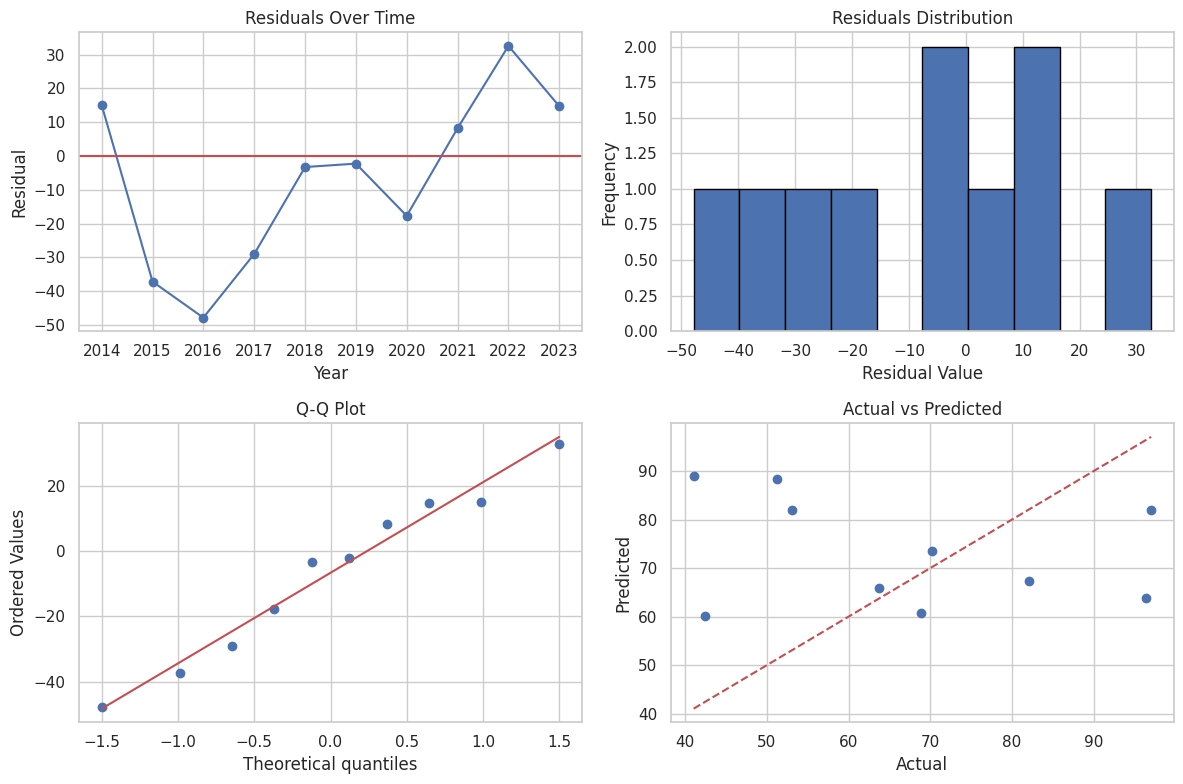


Simple GRU Model Evaluation:


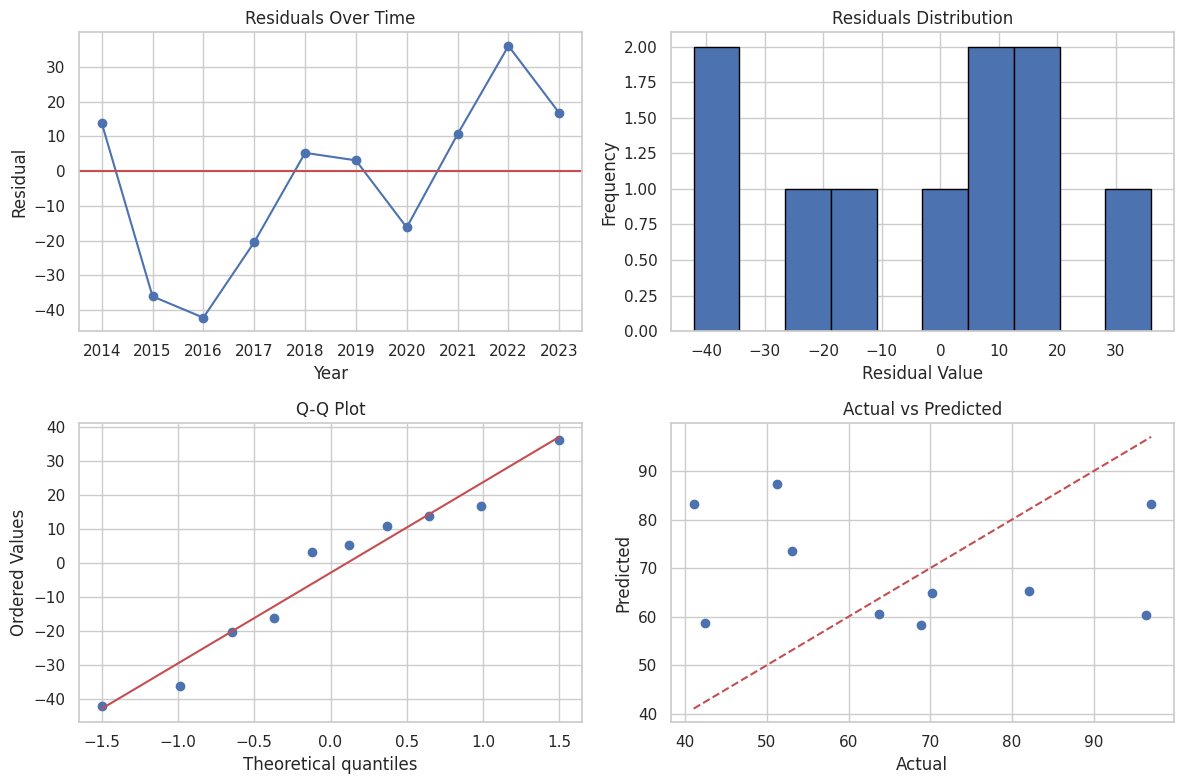


Tuned GRU Model Evaluation:


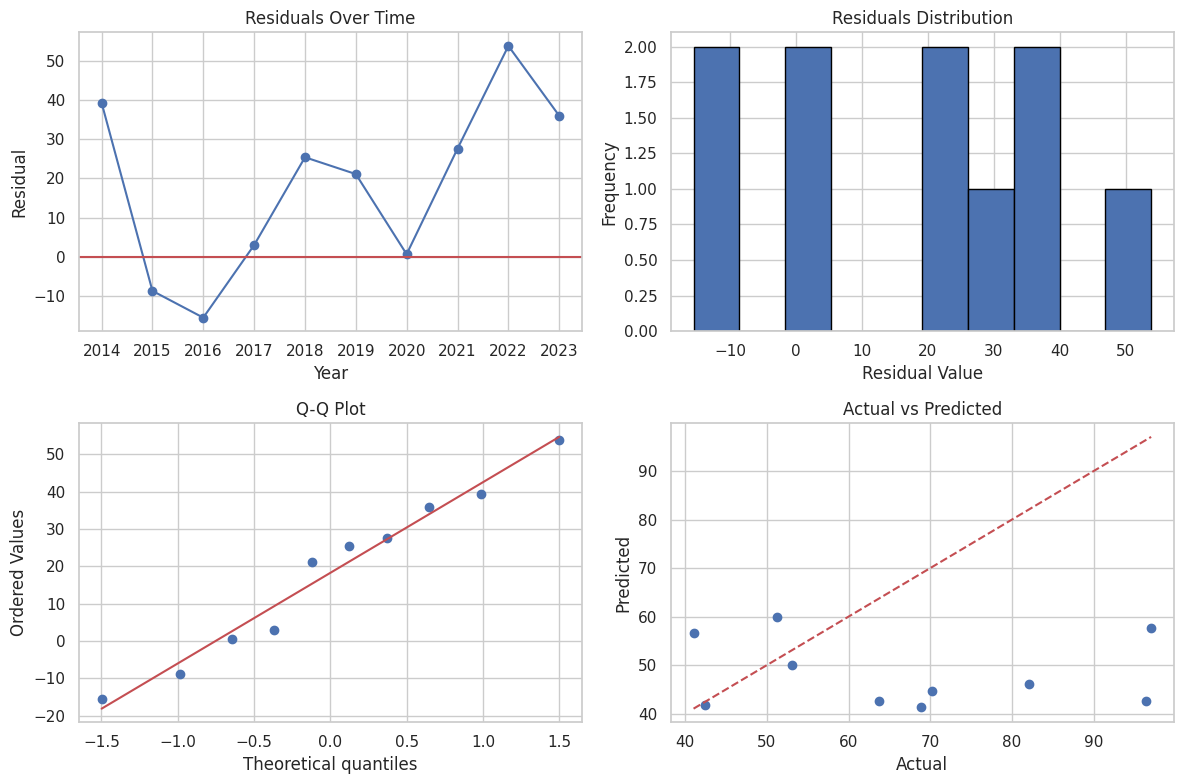


Generating forecasts with GRU Simple (best model)...
1/1 [==============================] - 0s 23ms/step

Forecasts for Dubai (5 years ahead):
            Dubai_Forecast  Dubai_Lower  Dubai_Upper
Year                                                
2024-01-01       68.724205    22.385883   115.062531
2025-01-01       70.376152    24.037830   116.714478
2026-01-01       72.343262    26.004940   118.681580
2027-01-01       71.663879    25.325558   118.002197
2028-01-01       69.068077    22.729755   115.406403


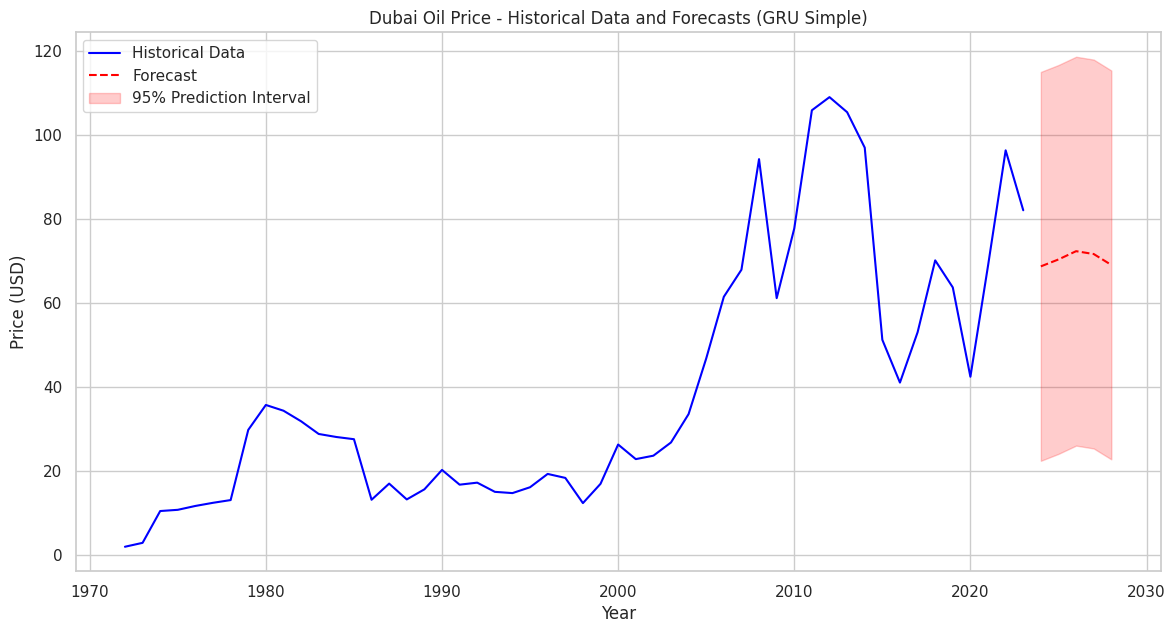


--------------------------------------------------
EVALUATING MODELS FOR Brent
--------------------------------------------------

ARIMA Model Evaluation:


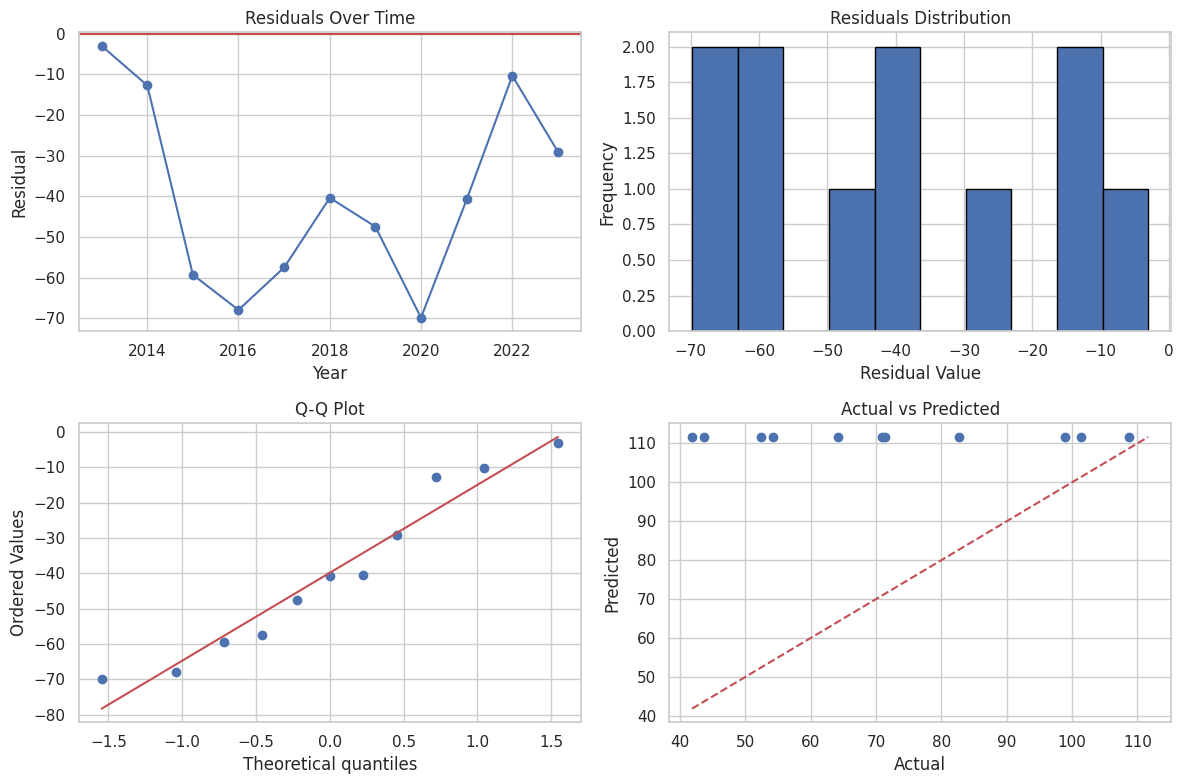


Simple LSTM Model Evaluation:


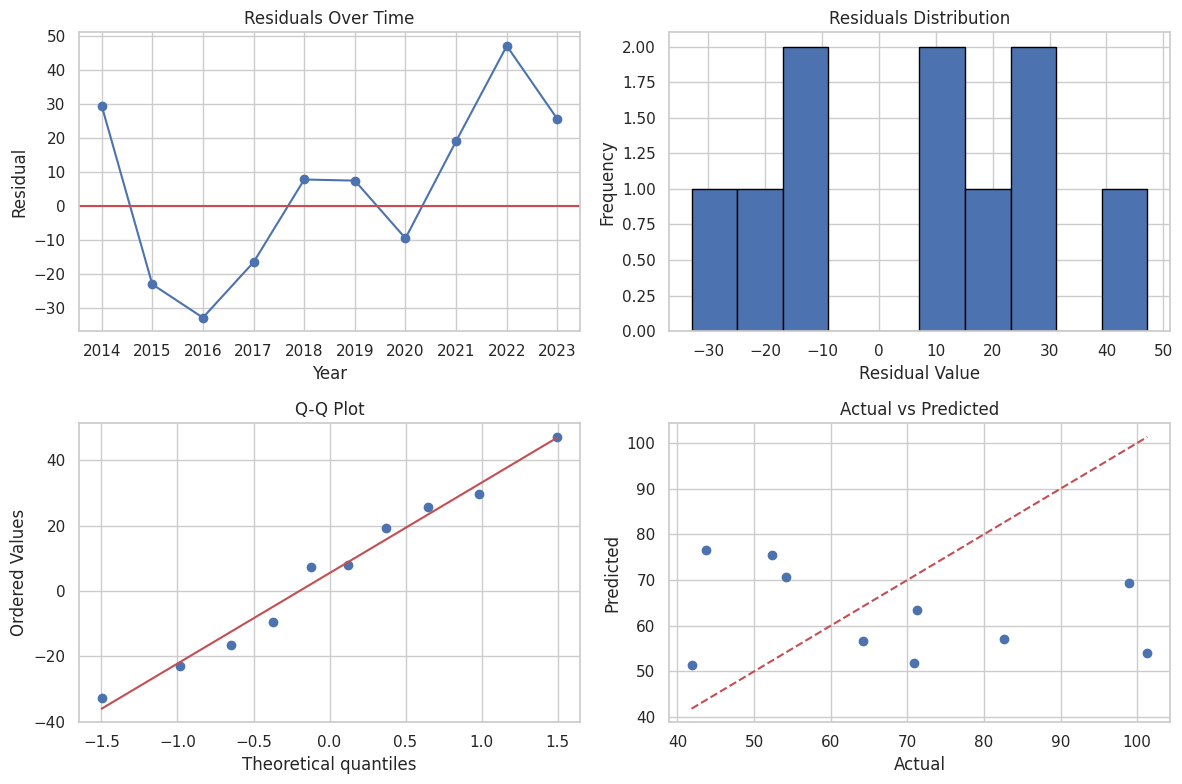


Tuned LSTM Model Evaluation:


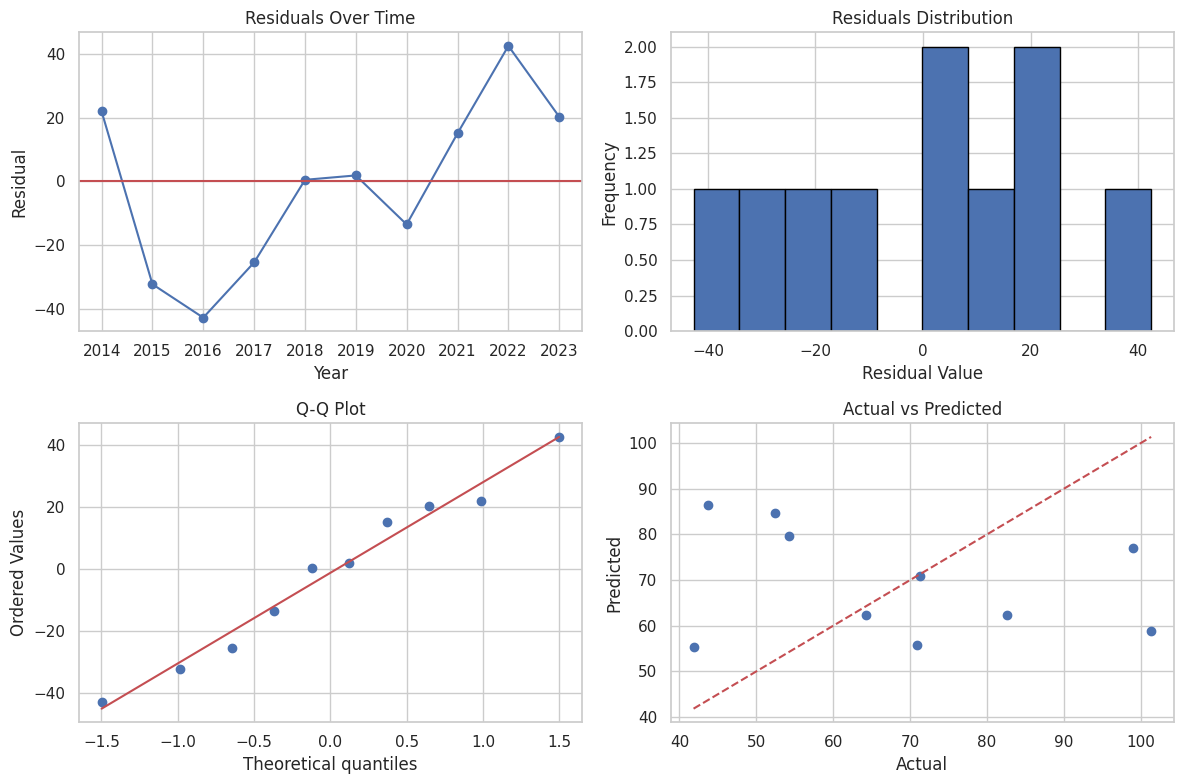


Simple GRU Model Evaluation:


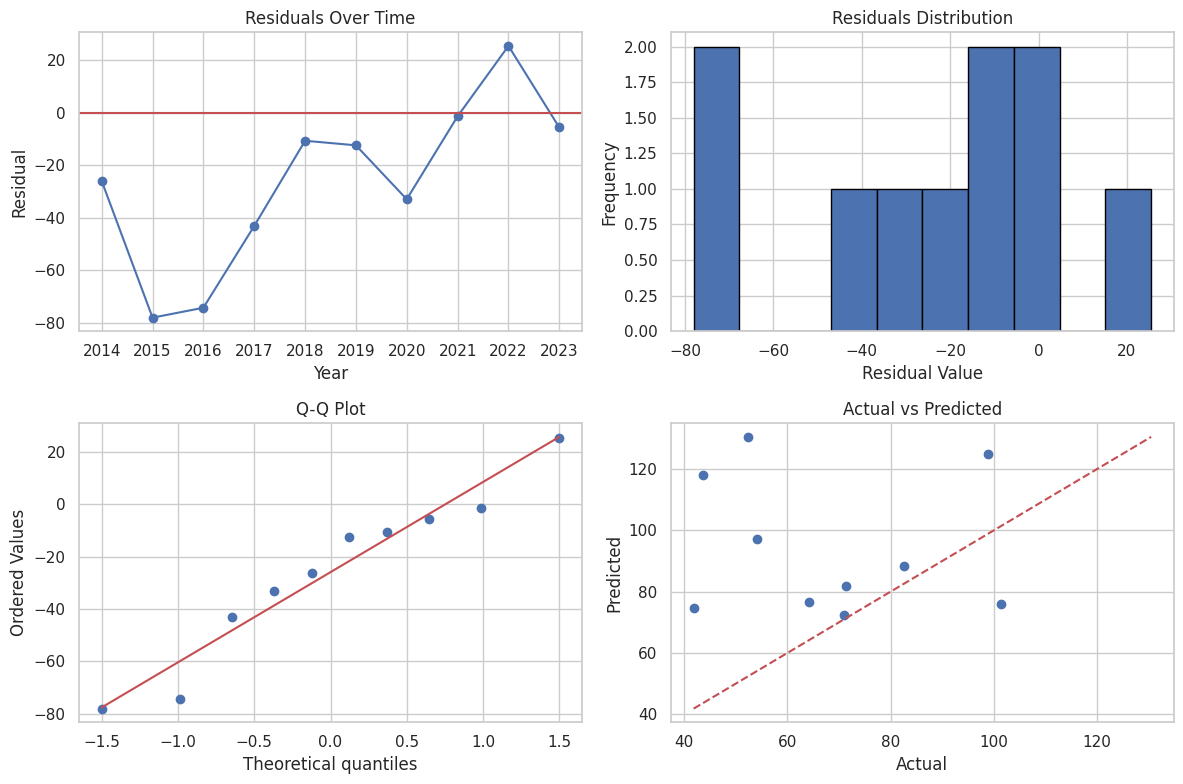


Tuned GRU Model Evaluation:


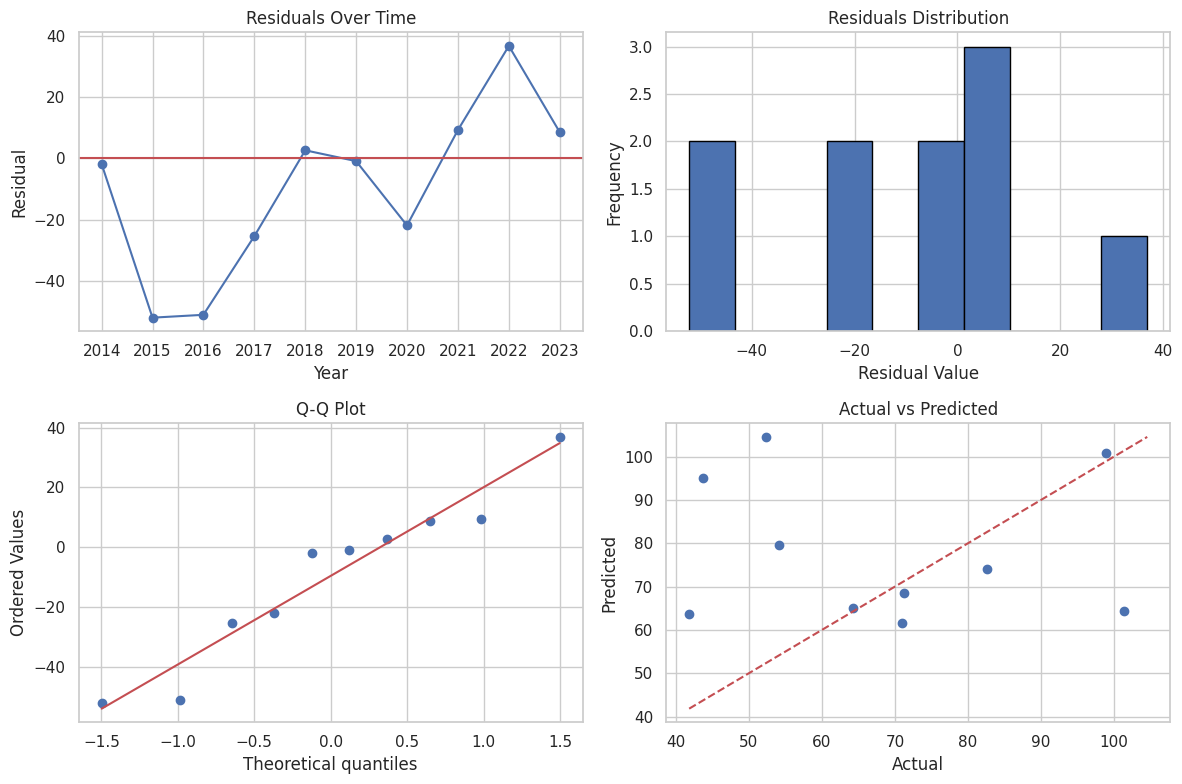


Generating forecasts with LSTM Simple (best model)...
1/1 [==============================] - 0s 23ms/step

Forecasts for Brent (5 years ahead):
            Brent_Forecast  Brent_Lower  Brent_Upper
Year                                                
2024-01-01       58.046684    10.334908   105.758461
2025-01-01       59.338760    11.626984   107.050537
2026-01-01       63.314419    15.602642   111.026199
2027-01-01       62.709229    14.997452   110.421005
2028-01-01       57.280323     9.568546   104.992096


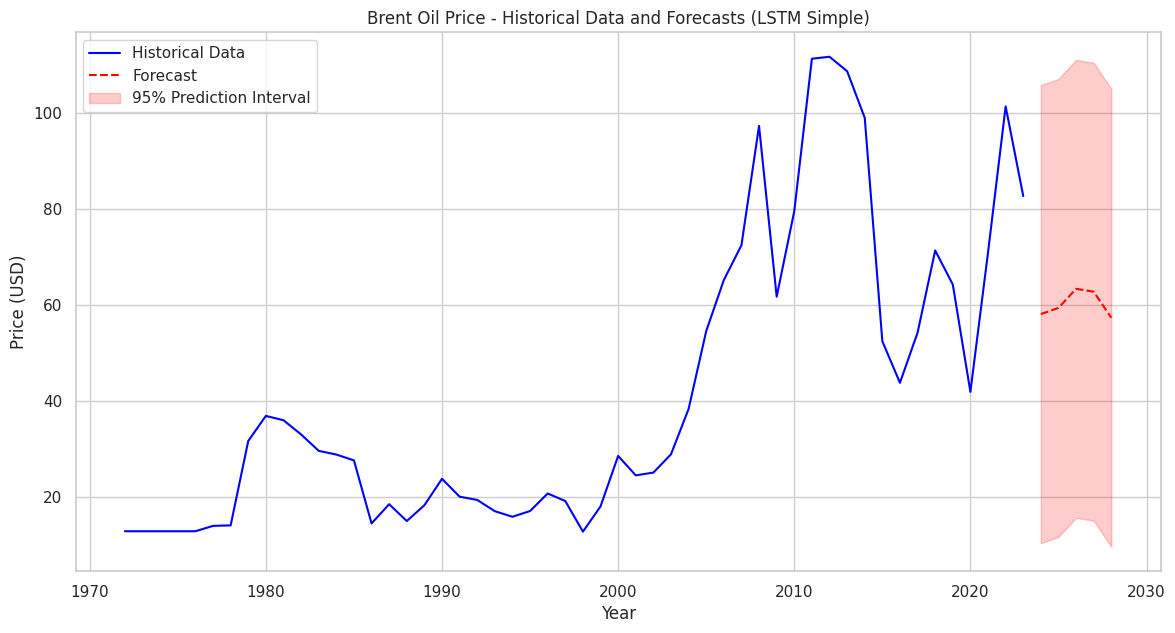


--------------------------------------------------
EVALUATING MODELS FOR Nigerian
--------------------------------------------------

ARIMA Model Evaluation:


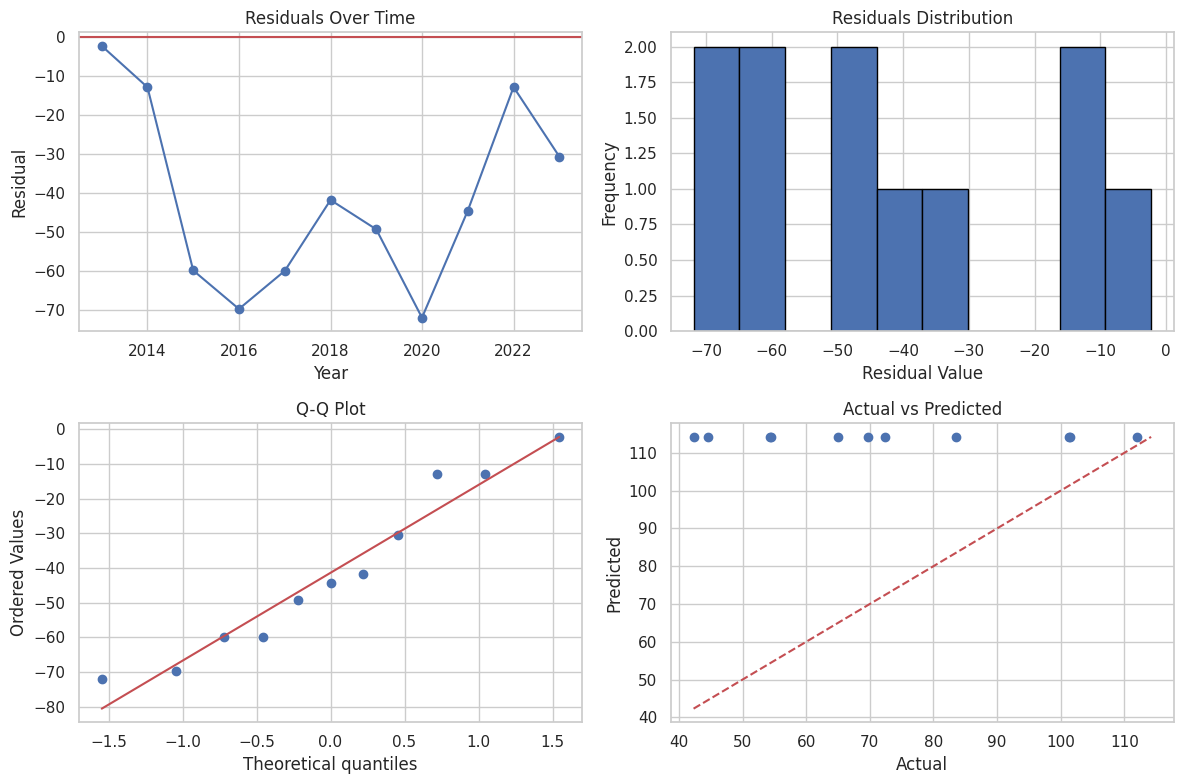


Simple LSTM Model Evaluation:


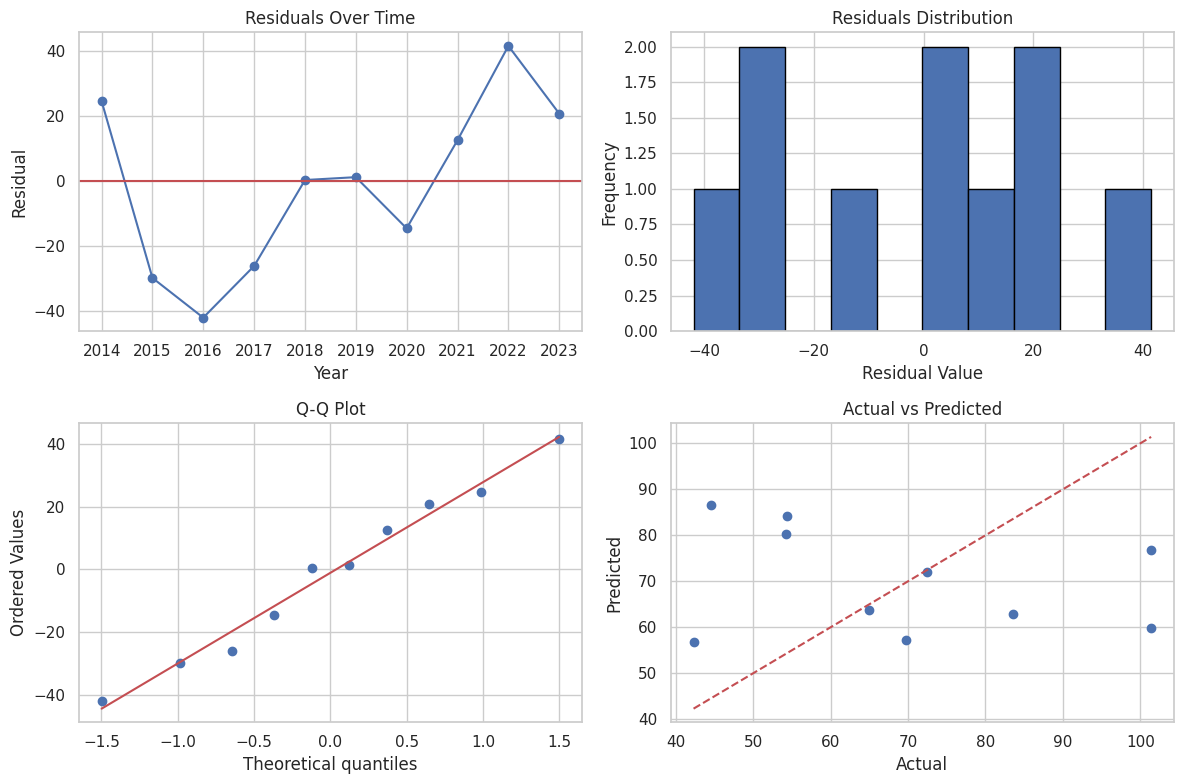


Tuned LSTM Model Evaluation:


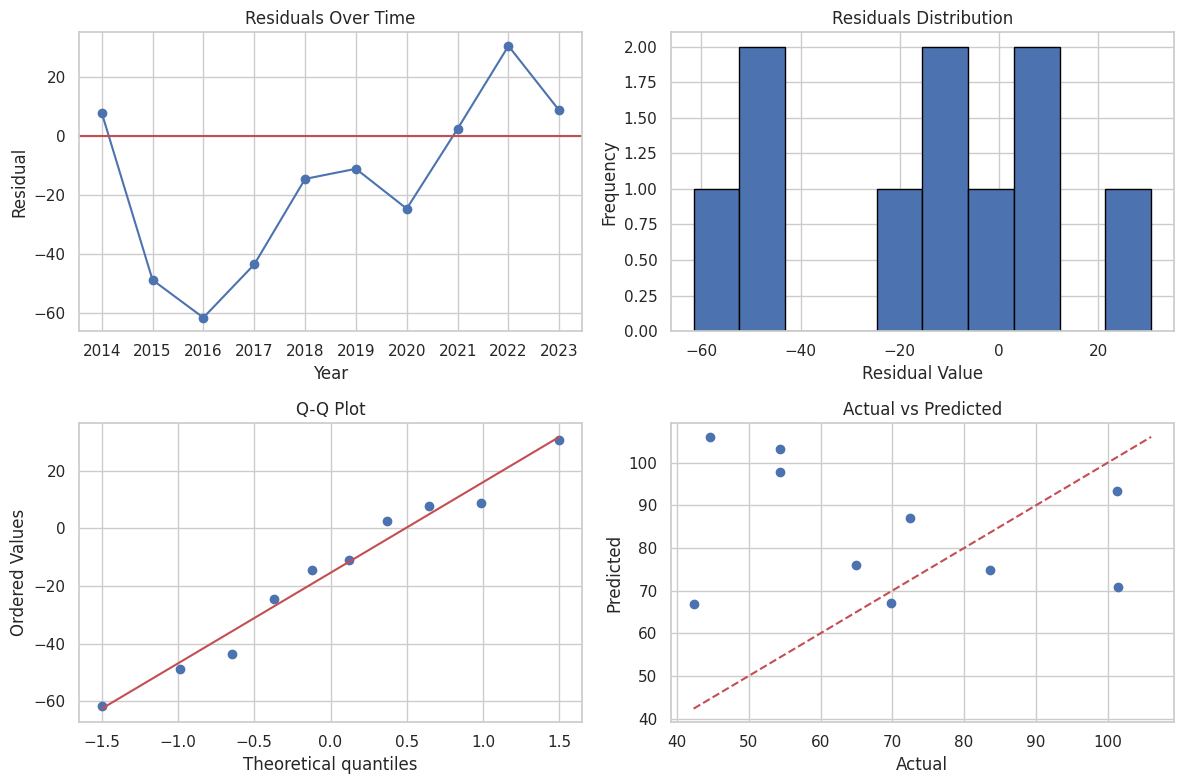


Simple GRU Model Evaluation:


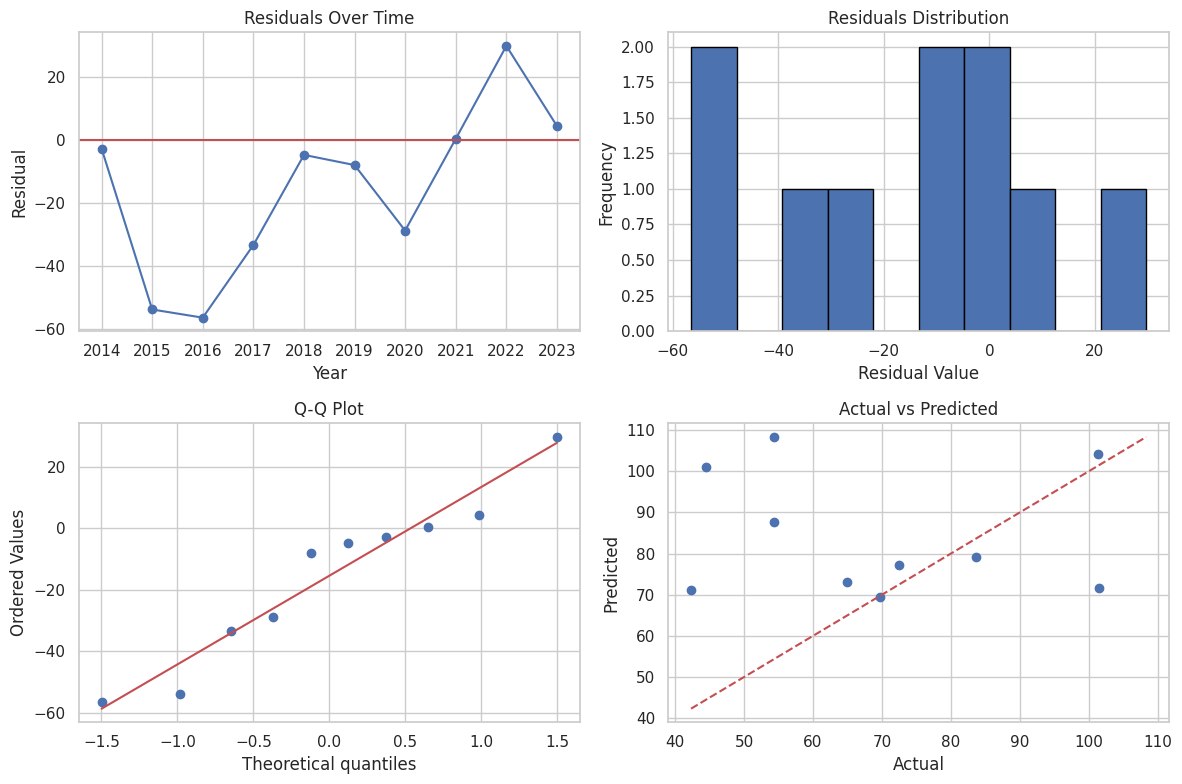


Tuned GRU Model Evaluation:


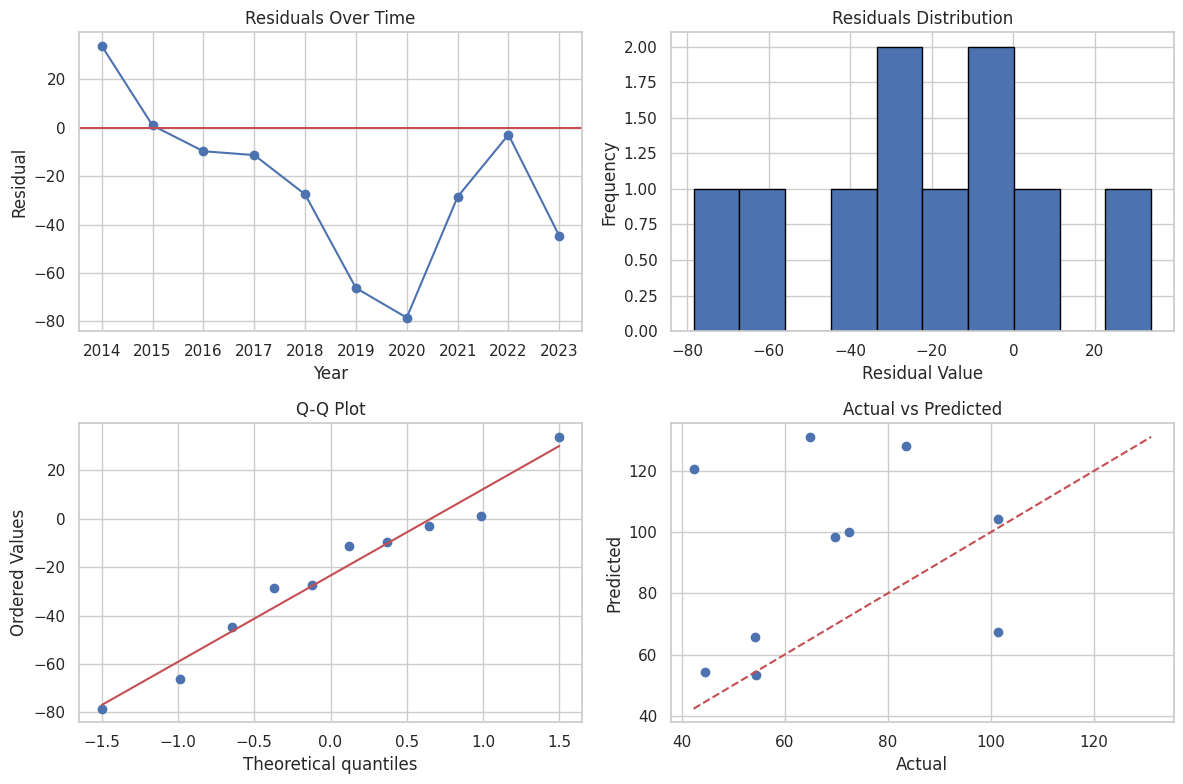


Generating forecasts with LSTM Simple (best model)...
1/1 [==============================] - 0s 24ms/step

Forecasts for Nigerian (5 years ahead):
            Nigerian_Forecast  Nigerian_Lower  Nigerian_Upper
Year                                                         
2024-01-01          63.508980       13.779922      113.238037
2025-01-01          65.229492       15.500435      114.958549
2026-01-01          70.808830       21.079773      120.537888
2027-01-01          71.426567       21.697510      121.155624
2028-01-01          66.112640       16.383583      115.841698


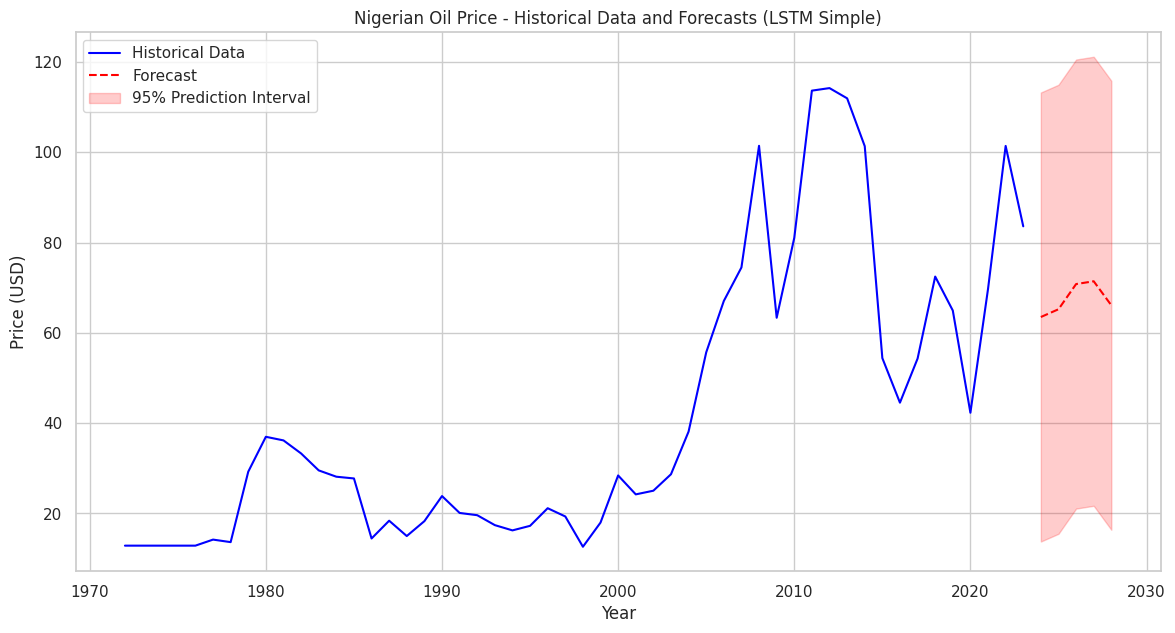


--------------------------------------------------
EVALUATING MODELS FOR WTI
--------------------------------------------------

ARIMA Model Evaluation:


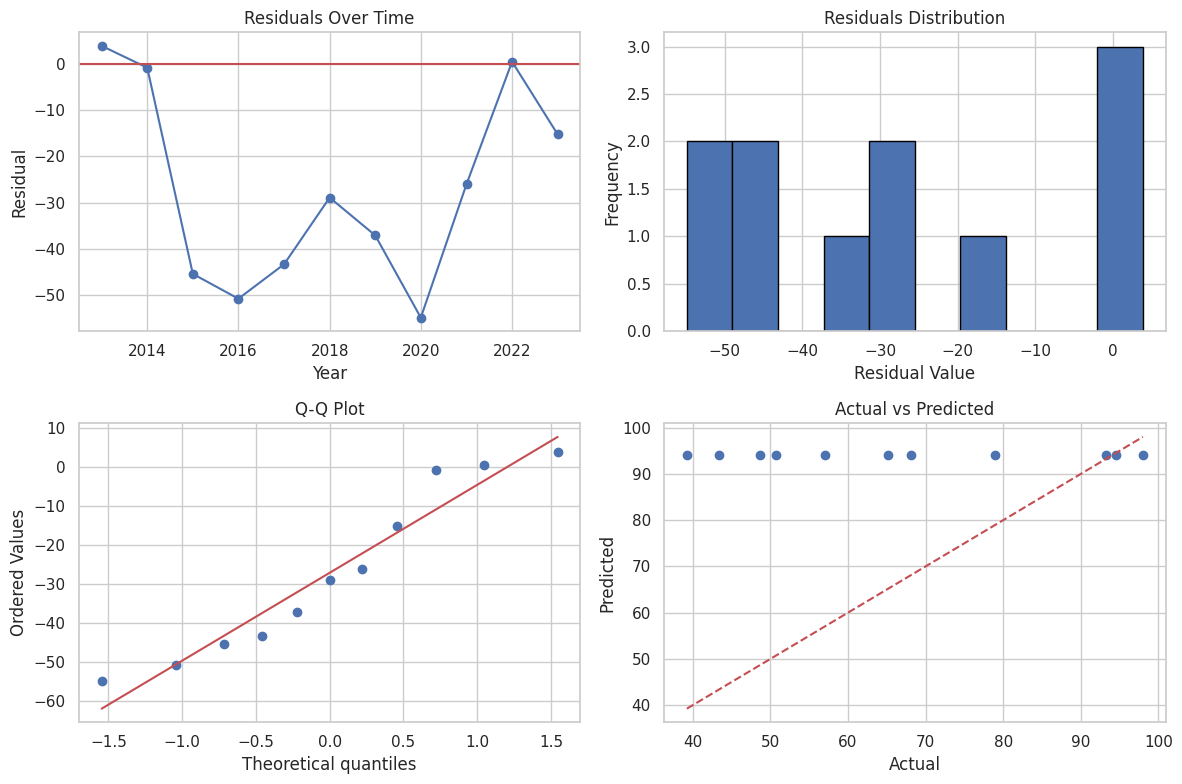


Simple LSTM Model Evaluation:


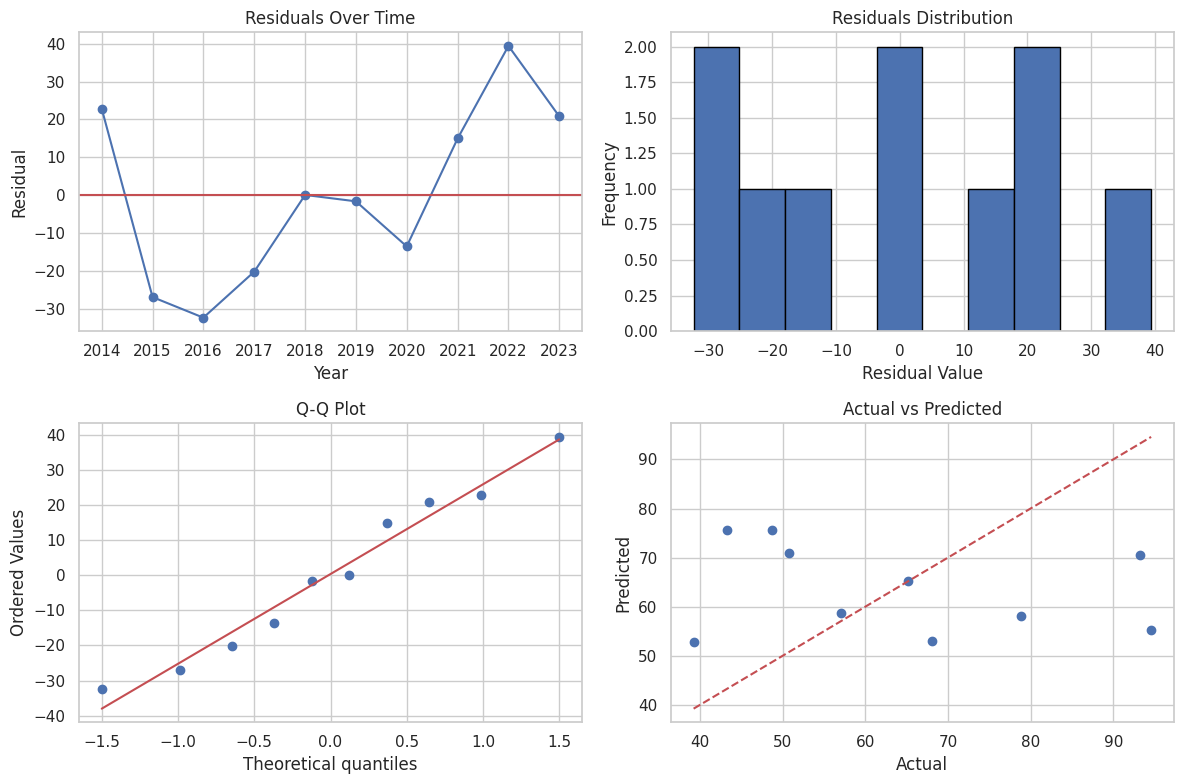


Tuned LSTM Model Evaluation:


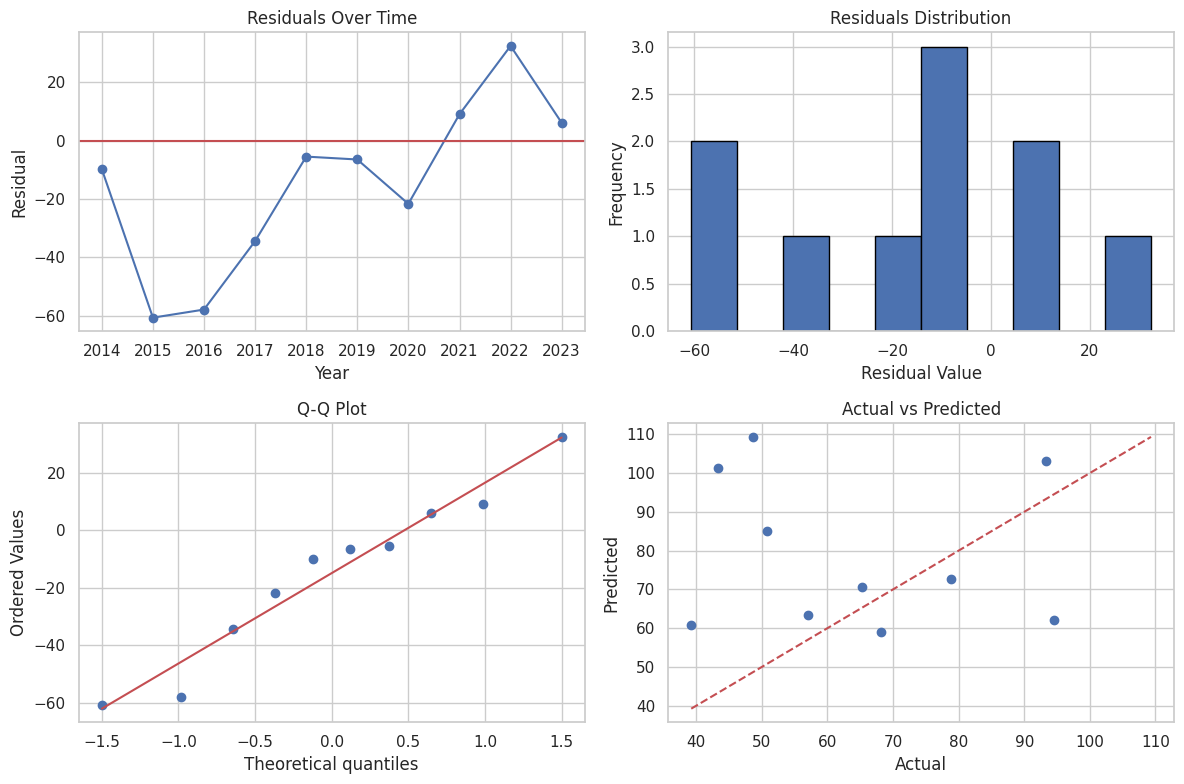


Simple GRU Model Evaluation:


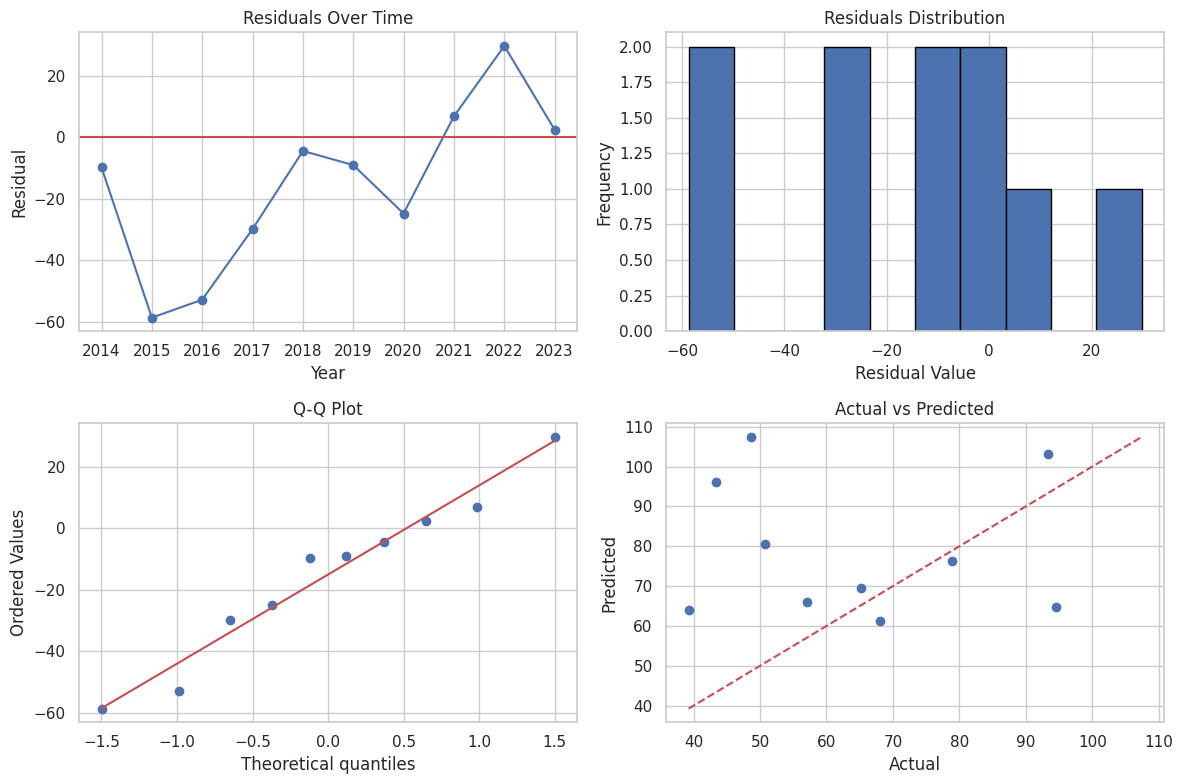


Tuned GRU Model Evaluation:


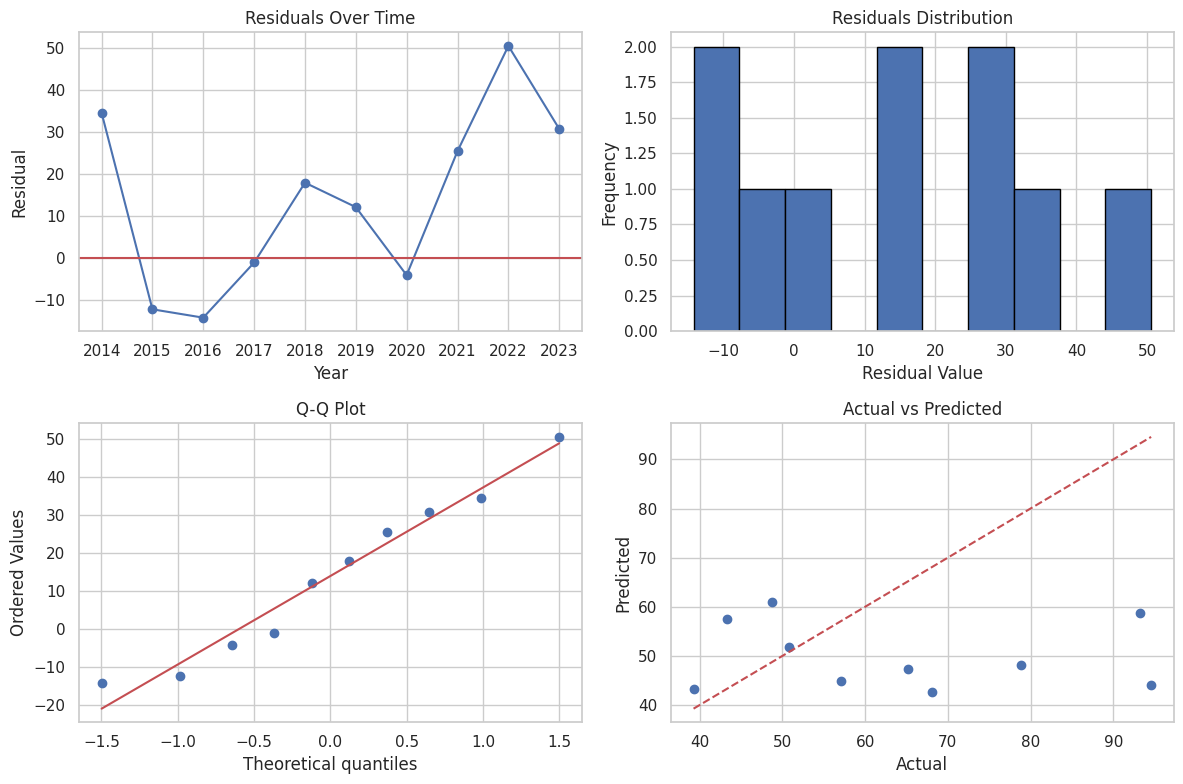


Generating forecasts with LSTM Simple (best model)...
1/1 [==============================] - 0s 32ms/step

Forecasts for WTI (5 years ahead):
            WTI_Forecast  WTI_Lower   WTI_Upper
Year                                           
2024-01-01     59.447830  15.220325  103.675339
2025-01-01     61.679237  17.451733  105.906738
2026-01-01     66.470383  22.242878  110.697891
2027-01-01     66.394714  22.167210  110.622223
2028-01-01     61.775108  17.547604  106.002609


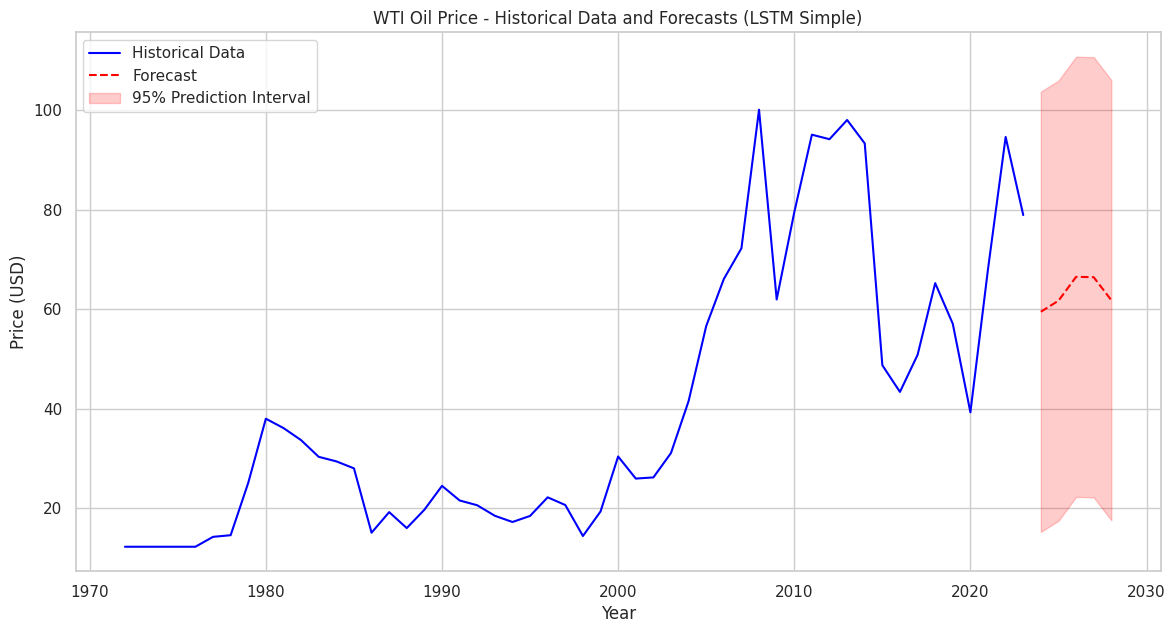

In [ ]:
# List untuk menyimpan figure
saved_figures = []

# Generate forecasts and evaluate for each region
for region, results in all_results.items():
    print(f"\n{'-'*50}")
    print(f"EVALUATING MODELS FOR {region}")
    print(f"{'-'*50}")

    # Evaluate all models
    print("\nARIMA Model Evaluation:")
    arima_metrics = evaluate_model_performance_arima(results['arima'], df_clean, region)
    print("\nSimple LSTM Model Evaluation:")
    simple_metrics = evaluate_model_performance(results['simple'], df_clean, region)
    print("\nTuned LSTM Model Evaluation:")
    tuned_metrics = evaluate_model_performance(results['hyper'], df_clean, region)
    print("\nSimple GRU Model Evaluation:")
    simple_gru_metrics = evaluate_model_performance(results['simple_gru'], df_clean, region)
    print("\nTuned GRU Model Evaluation:")
    tuned_gru_metrics = evaluate_model_performance(results['tuned_gru'], df_clean, region)

    # Determine best model based on RMSE
    model_candidates = {
        'arima': results['arima']['test_metrics']['RMSE'],
        'simple': results['simple']['test_metrics']['RMSE'],
        'hyper': results['hyper']['test_metrics']['RMSE'],
        'simple_gru': results['simple_gru']['test_metrics']['RMSE'],
        'tuned_gru': results['tuned_gru']['test_metrics']['RMSE']
    }
    best_model_key = min(model_candidates, key=model_candidates.get)
    best_model_name = {
        'arima': 'ARIMA',
        'simple': 'LSTM Simple',
        'hyper': 'LSTM Hyper',
        'simple_gru': 'GRU Simple',
        'tuned_gru': 'GRU Tuned'
    }[best_model_key]

    print(f"\nGenerating forecasts with {best_model_name} (best model)...")

    # Generate forecasts
    if best_model_key == 'arima':
        forecast_df = forecast_future_arima(results['arima'], df_clean, region, forecast_years)
    else:
        forecast_df = create_prediction_intervals(results[best_model_key], df_clean, region, forecast_years)

    print(f"\nForecasts for {region} ({forecast_years} years ahead):")
    print(forecast_df)

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df_clean.index, df_clean[region], label='Historical Data', color='blue')

    ax.plot(forecast_df.index, forecast_df[f'{region}_Forecast'],
            label='Forecast', color='red', linestyle='--')
    ax.fill_between(forecast_df.index,
                    forecast_df[f'{region}_Lower'],
                    forecast_df[f'{region}_Upper'],
                    color='red', alpha=0.2, label='95% Prediction Interval')

    ax.set_title(f'{region} Oil Price - Historical Data and Forecasts ({best_model_name})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.grid(True)

    plt.show()
    saved_figures.append(fig)

### ⦿ Overall Comparison

In [ ]:
comparison_results = compare_models(all_results, df_clean, include_arima=True, show_plot=False)

In [ ]:
print("\nComparison of all models across regions:")
comparison_results


Comparison of all models across regions:


Region        Model        MAE          MSE       RMSE        R²  \
0      Dubai  Simple LSTM  21.956071   630.320792  25.106190 -0.686003   
1      Dubai   Tuned LSTM  20.785470   641.546031  25.328759 -0.716029   
2      Dubai   Simple GRU  20.038721   567.538902  23.823075 -0.518072   
3      Dubai    Tuned GRU  23.114296   791.500520  28.133619 -1.117132   
4      Dubai        ARIMA  38.929925  1980.292388  44.500476 -3.260954   
5      Brent  Simple LSTM  21.895262   622.539740  24.950746 -0.547247   
6      Brent   Tuned LSTM  21.573475   660.386680  25.697990 -0.641311   
7      Brent   Simple GRU  30.979520  1617.621154  40.219661 -3.020401   
8      Brent    Tuned GRU  21.097556   800.301827  28.289606 -0.989053   
9      Brent        ARIMA  39.837788  2088.444803  45.699506 -3.165265   
10  Nigerian  Simple LSTM  21.319098   645.020300  25.397250 -0.581854   
11  Nigerian   Tuned LSTM  25.361989  1006.820499  31.730435 -1.469136   
12  Nigerian   Simple GRU  22.294594   905.379309  30.089522 -1.220360   
13  Nigerian    Tuned GRU  30.412227  1549.339777  39.361654 -2.799615   
14  Nigerian        ARIMA  41.390680  2236.949295  47.296398 -3.270936   
15       WTI  Simple LSTM  19.264248   509.305408  22.567796 -0.443368   
16       WTI   Tuned LSTM  24.382883  1000.913218  31.637213 -1.836581   
17       WTI   Simple GRU  22.866141   888.900905  29.814441 -1.519139   
18       WTI    Tuned GRU  20.317871   619.203643  24.883803 -0.754819   
19       WTI        ARIMA  27.897906  1151.840780  33.938780 -1.763889   

         MAPE  
0   32.716139  
1   37.311774  
2   34.967705  
3   31.170628  
4   71.664320  
5   32.979168  
6   35.144181  
7   57.135473  
8   38.298778  
9   71.856876  
10  34.146545  
11  45.489761  
12  41.273239  
13  50.037506  
14  73.430248  
15  32.147601  
16  46.629571  
17  44.241298  
18  28.635140  
19  55.260186

### ⦿ Forecast Comparison

1/1 [==============================] - 0s 23ms/step


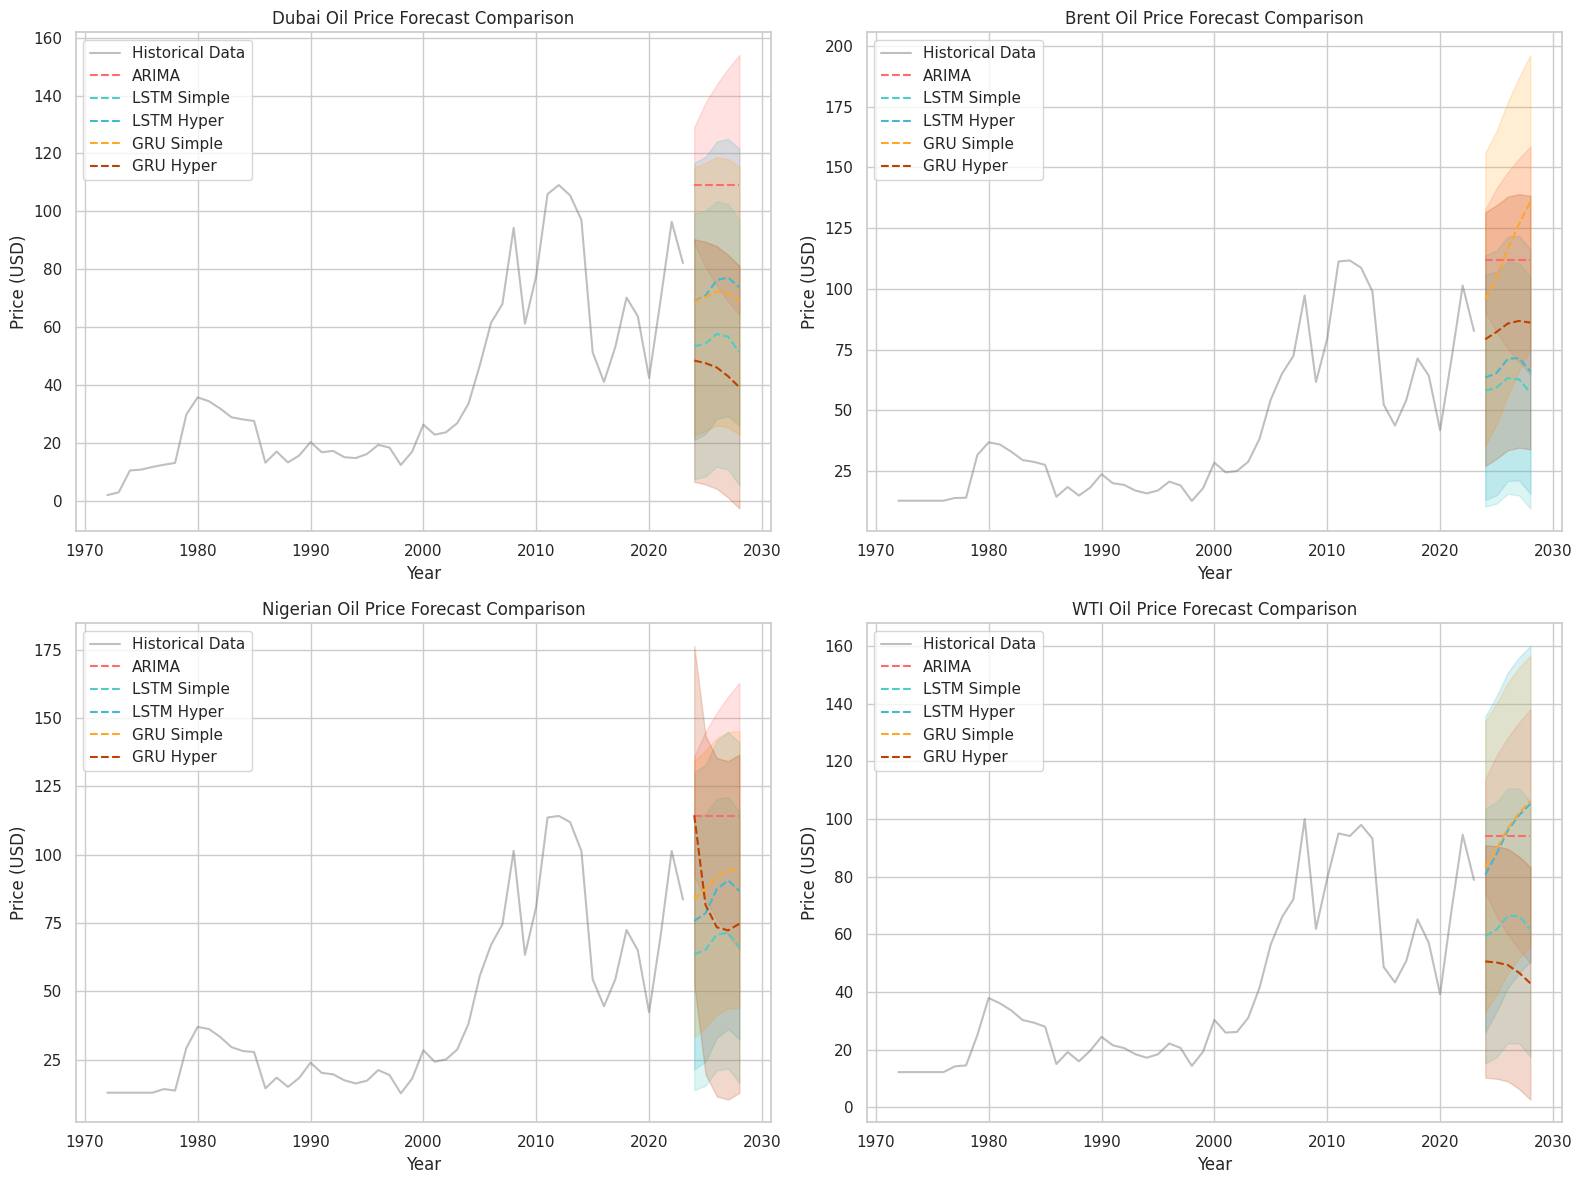

In [ ]:
# Plot komparasi model untuk semua region
plt.figure(figsize=(16, 12))

# Warna yang konsisten untuk setiap model
colors = {
    'ARIMA': '#FF6B6B',
    'LSTM Simple': '#4ECDC4',
    'LSTM Hyper': '#45B7D1',
    'GRU Simple': '#FFA62B',  # Orange color for Simple GRU
    'GRU Hyper': '#C04000'    # Dark orange/brown for Tuned GRU
}

for i, (region, results) in enumerate(all_results.items(), 1):
    plt.subplot(2, 2, i)

    # Plot data historis
    plt.plot(df_clean.index, df_clean[region], label='Historical Data', color='gray', alpha=0.5)

    # Forecast ARIMA
    arima_forecast = forecast_future_arima(results['arima'], df_clean, region, forecast_years)
    plt.plot(arima_forecast.index, arima_forecast[f'{region}_Forecast'],
             label='ARIMA', color=colors['ARIMA'], linestyle='--')
    plt.fill_between(arima_forecast.index,
                     arima_forecast[f'{region}_Lower'],
                     arima_forecast[f'{region}_Upper'],
                     color=colors['ARIMA'], alpha=0.2)

    # Forecast LSTM Simple
    lstm_simple_forecast = create_prediction_intervals(results['simple'], df_clean, region, forecast_years)
    plt.plot(lstm_simple_forecast.index, lstm_simple_forecast[f'{region}_Forecast'],
             label='LSTM Simple', color=colors['LSTM Simple'], linestyle='--')
    plt.fill_between(lstm_simple_forecast.index,
                     lstm_simple_forecast[f'{region}_Lower'],
                     lstm_simple_forecast[f'{region}_Upper'],
                     color=colors['LSTM Simple'], alpha=0.2)

    # Forecast LSTM Hyper
    lstm_hyper_forecast = create_prediction_intervals(results['hyper'], df_clean, region, forecast_years)
    plt.plot(lstm_hyper_forecast.index, lstm_hyper_forecast[f'{region}_Forecast'],
             label='LSTM Hyper', color=colors['LSTM Hyper'], linestyle='--')
    plt.fill_between(lstm_hyper_forecast.index,
                     lstm_hyper_forecast[f'{region}_Lower'],
                     lstm_hyper_forecast[f'{region}_Upper'],
                     color=colors['LSTM Hyper'], alpha=0.2)

    # Forecast GRU Simple
    gru_simple_forecast = create_prediction_intervals(results['simple_gru'], df_clean, region, forecast_years)
    plt.plot(gru_simple_forecast.index, gru_simple_forecast[f'{region}_Forecast'],
             label='GRU Simple', color=colors['GRU Simple'], linestyle='--')
    plt.fill_between(gru_simple_forecast.index,
                     gru_simple_forecast[f'{region}_Lower'],
                     gru_simple_forecast[f'{region}_Upper'],
                     color=colors['GRU Simple'], alpha=0.2)

    # Forecast GRU Hyper
    gru_hyper_forecast = create_prediction_intervals(results['tuned_gru'], df_clean, region, forecast_years)
    plt.plot(gru_hyper_forecast.index, gru_hyper_forecast[f'{region}_Forecast'],
             label='GRU Hyper', color=colors['GRU Hyper'], linestyle='--')
    plt.fill_between(gru_hyper_forecast.index,
                     gru_hyper_forecast[f'{region}_Lower'],
                     gru_hyper_forecast[f'{region}_Upper'],
                     color=colors['GRU Hyper'], alpha=0.2)

    plt.title(f'{region} Oil Price Forecast Comparison')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create comparison visualizations
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

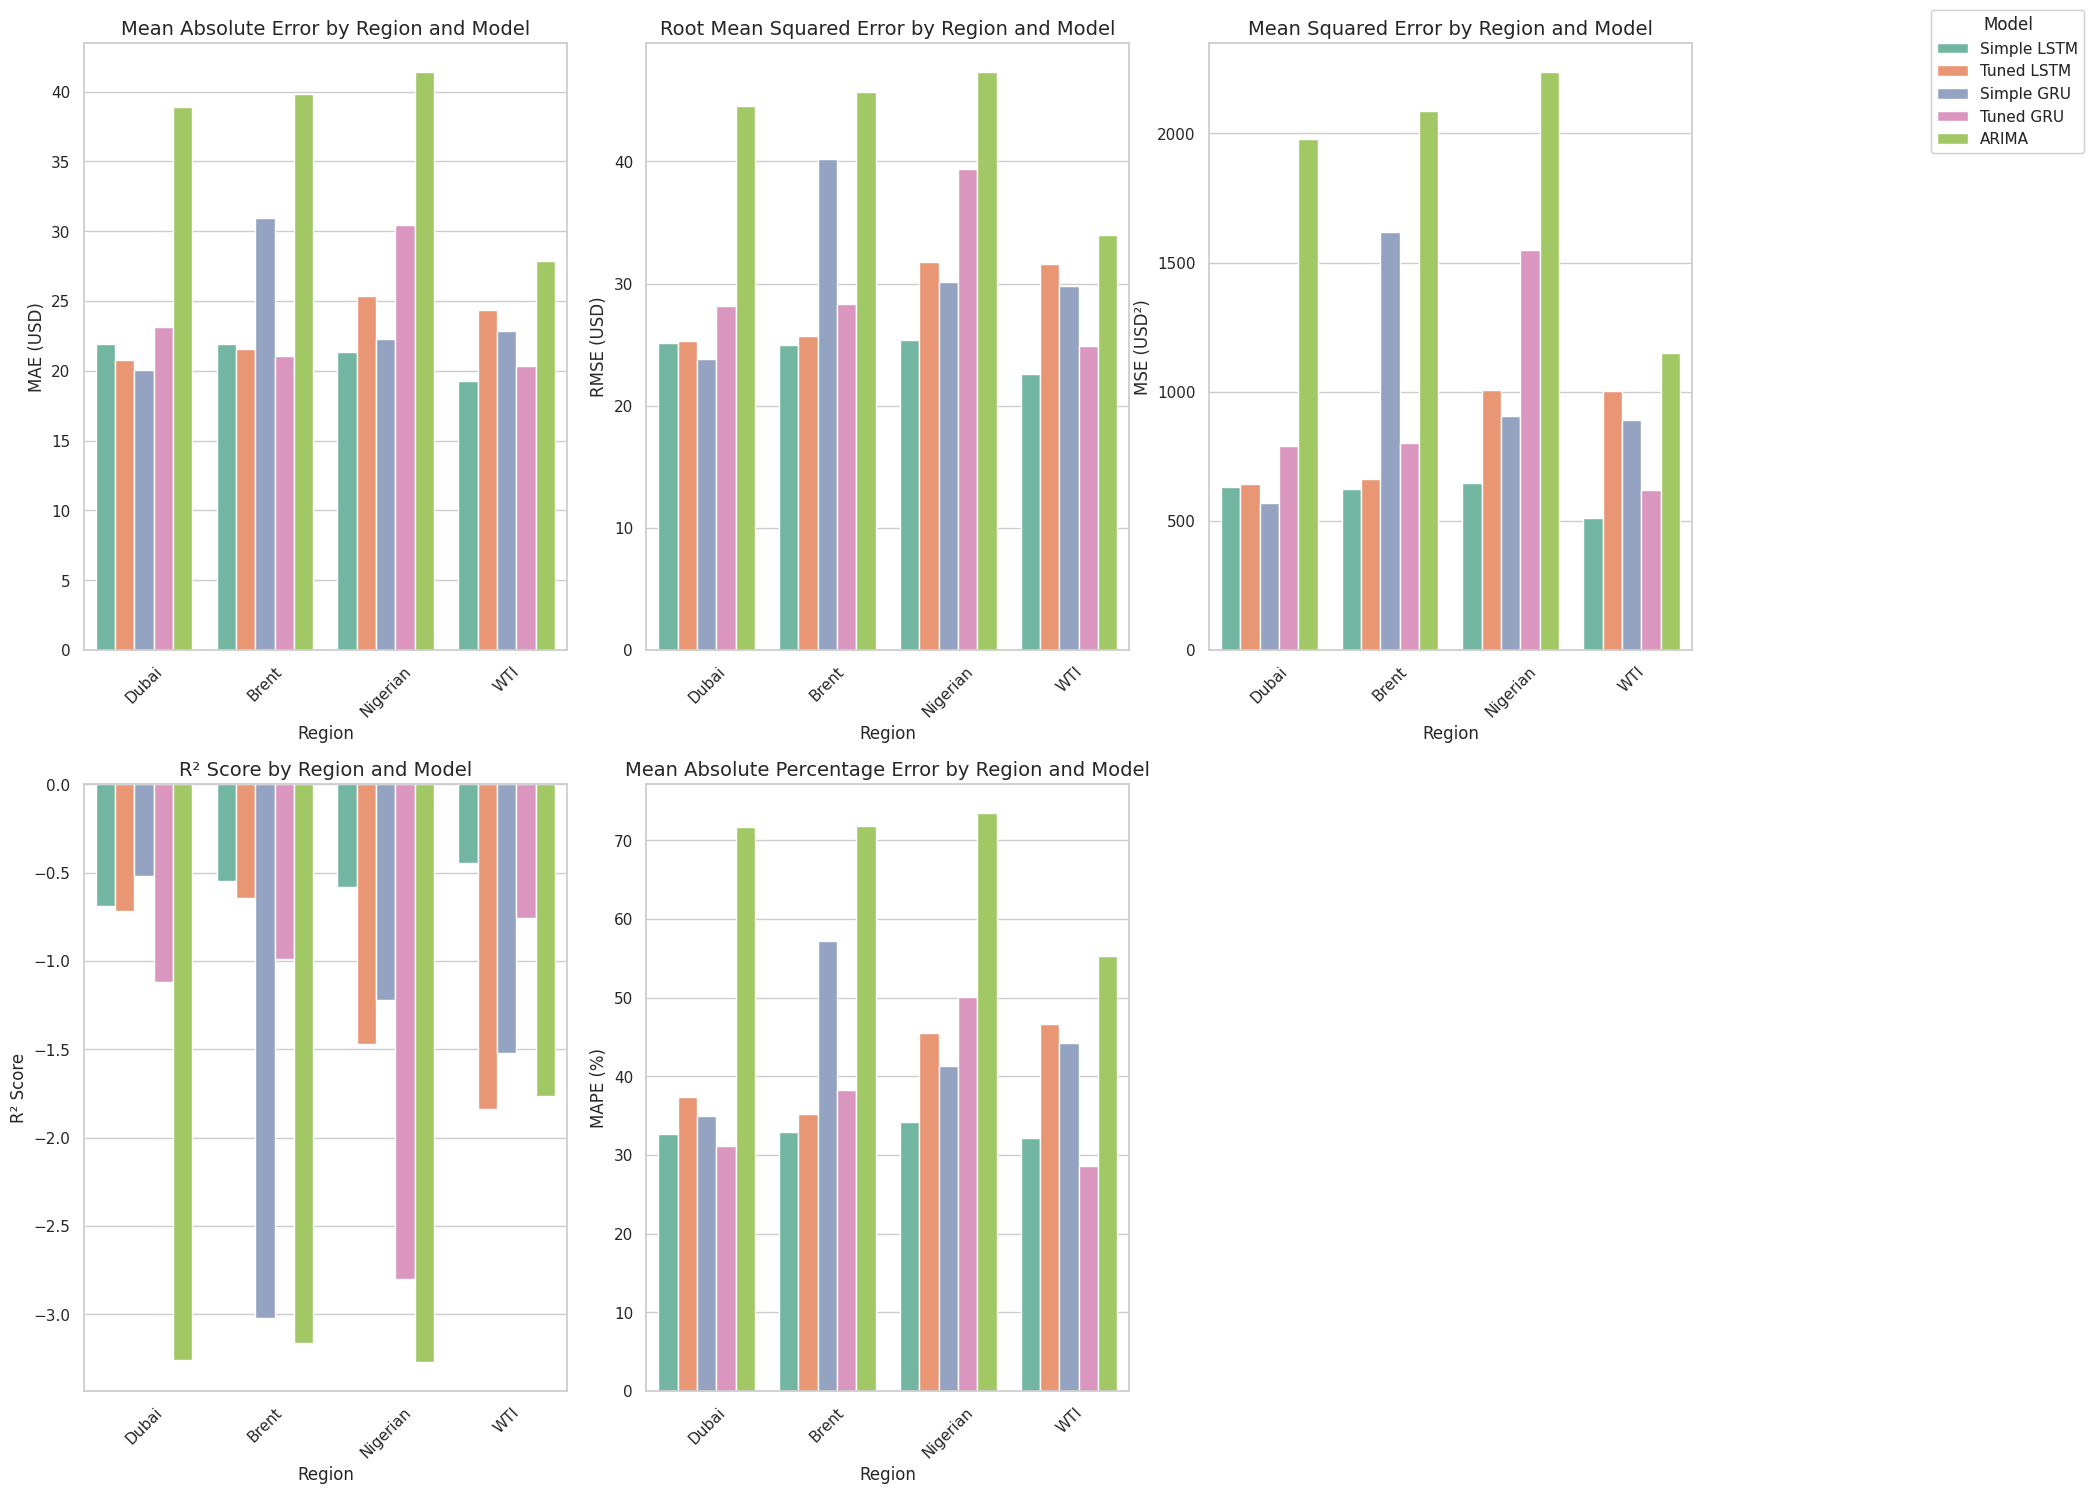

In [ ]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(20, 15))  # Use 'fig' to control legend later

# MAE Plot
ax1 = plt.subplot(2, 3, 1)
sns.barplot(x='Region', y='MAE', hue='Model', data=comparison_results, palette='Set2', ax=ax1)
ax1.set_title('Mean Absolute Error by Region and Model', fontsize=14)
ax1.set_ylabel('MAE (USD)', fontsize=12)
ax1.set_xlabel('Region', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='y')

# RMSE Plot
ax2 = plt.subplot(2, 3, 2)
sns.barplot(x='Region', y='RMSE', hue='Model', data=comparison_results, palette='Set2', ax=ax2)
ax2.set_title('Root Mean Squared Error by Region and Model', fontsize=14)
ax2.set_ylabel('RMSE (USD)', fontsize=12)
ax2.set_xlabel('Region', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y')

# MSE Plot
ax3 = plt.subplot(2, 3, 3)
sns.barplot(x='Region', y='MSE', hue='Model', data=comparison_results, palette='Set2', ax=ax3)
ax3.set_title('Mean Squared Error by Region and Model', fontsize=14)
ax3.set_ylabel('MSE (USD²)', fontsize=12)
ax3.set_xlabel('Region', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, axis='y')

# R² Plot
ax4 = plt.subplot(2, 3, 4)
sns.barplot(x='Region', y='R²', hue='Model', data=comparison_results, palette='Set2', ax=ax4)
ax4.set_title('R² Score by Region and Model', fontsize=14)
ax4.set_ylabel('R² Score', fontsize=12)
ax4.set_xlabel('Region', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, axis='y')

# MAPE Plot
ax5 = plt.subplot(2, 3, 5)
sns.barplot(x='Region', y='MAPE', hue='Model', data=comparison_results, palette='Set2', ax=ax5)
ax5.set_title('Mean Absolute Percentage Error by Region and Model', fontsize=14)
ax5.set_ylabel('MAPE (%)', fontsize=12)
ax5.set_xlabel('Region', fontsize=12)
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, axis='y')

# Only add legend from one of the axes, place it outside the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1), title='Model')

# Remove per-plot legends
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.get_legend().remove()

# Add shared legend to the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1), title='Model')

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# Find best model for each region
best_models = []
for region in ['Dubai', 'Brent', 'Nigerian', 'WTI']:
    region_data = comparison_results[comparison_results['Region'] == region]
    best_model_row = region_data.loc[region_data['RMSE'].idxmin()]
    best_models.append({
        'Region': region,
        'Best Model': best_model_row['Model'],
        'RMSE': best_model_row['RMSE'],
        'R²': best_model_row['R²'],
        'MAPE': best_model_row['MAPE'],
        'MAE': best_model_row['MAE'],
        'MSE': best_model_row['MSE']
    })

In [ ]:
best_models_df = pd.DataFrame(best_models)
print("\nBest model for each region:")
best_models_df


Best model for each region:


Region   Best Model       RMSE        R²       MAPE        MAE  \
0     Dubai   Simple GRU  23.823075 -0.518072  34.967705  20.038721   
1     Brent  Simple LSTM  24.950746 -0.547247  32.979168  21.895262   
2  Nigerian  Simple LSTM  25.397250 -0.581854  34.146545  21.319098   
3       WTI  Simple LSTM  22.567796 -0.443368  32.147601  19.264248   

          MSE  
0  567.538902  
1  622.539740  
2  645.020300  
3  509.305408

### ⦿ All in One Final Forecast (All Model)

In [ ]:
def plot_forecast_all_models_all_regions(df, all_results, forecast_years=5):
    import matplotlib.pyplot as plt

    regions = ['Dubai', 'Brent', 'Nigerian', 'WTI']
    models = {
        'arima': 'ARIMA',
        'simple': 'Simple LSTM',
        'hyper': 'Tuned LSTM',
        'simple_gru': 'Simple GRU',
        'tuned_gru': 'Tuned GRU'
    }

    # Color per region
    region_colors = {
        'Dubai': 'red',
        'Brent': 'blue',
        'Nigerian': 'green',
        'WTI': 'orange'
    }

    # Line style per model
    model_styles = {
        'ARIMA': 'solid',
        'Simple LSTM': 'dashed',
        'Tuned LSTM': 'dotted',
        'Simple GRU': (0, (3, 1, 1, 1)),
        'Tuned GRU': (0, (5, 2))
    }

    plt.figure(figsize=(16, 10))

    # Plot historical data first
    for region in regions:
        plt.plot(df.index, df[region], label=f'{region} (Historical)', color=region_colors[region], linewidth=2)

    # Plot forecast from each model per region
    for region in regions:
        for key, label in models.items():
            result = all_results[region][key]
            if key == 'arima':
                forecast_df = forecast_future_arima(result, df, region, forecast_years)
            else:
                forecast_df = create_prediction_intervals(result, df, region, forecast_years)

            plt.plot(
                forecast_df.index,
                forecast_df[f'{region}_Forecast'],
                label=f'{region} - {label}',
                color=region_colors[region],
                linestyle=model_styles[label],
                linewidth=1.8
            )

    plt.title('Forecast of All Regions Using All Models', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Oil Price (USD)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 24ms/step


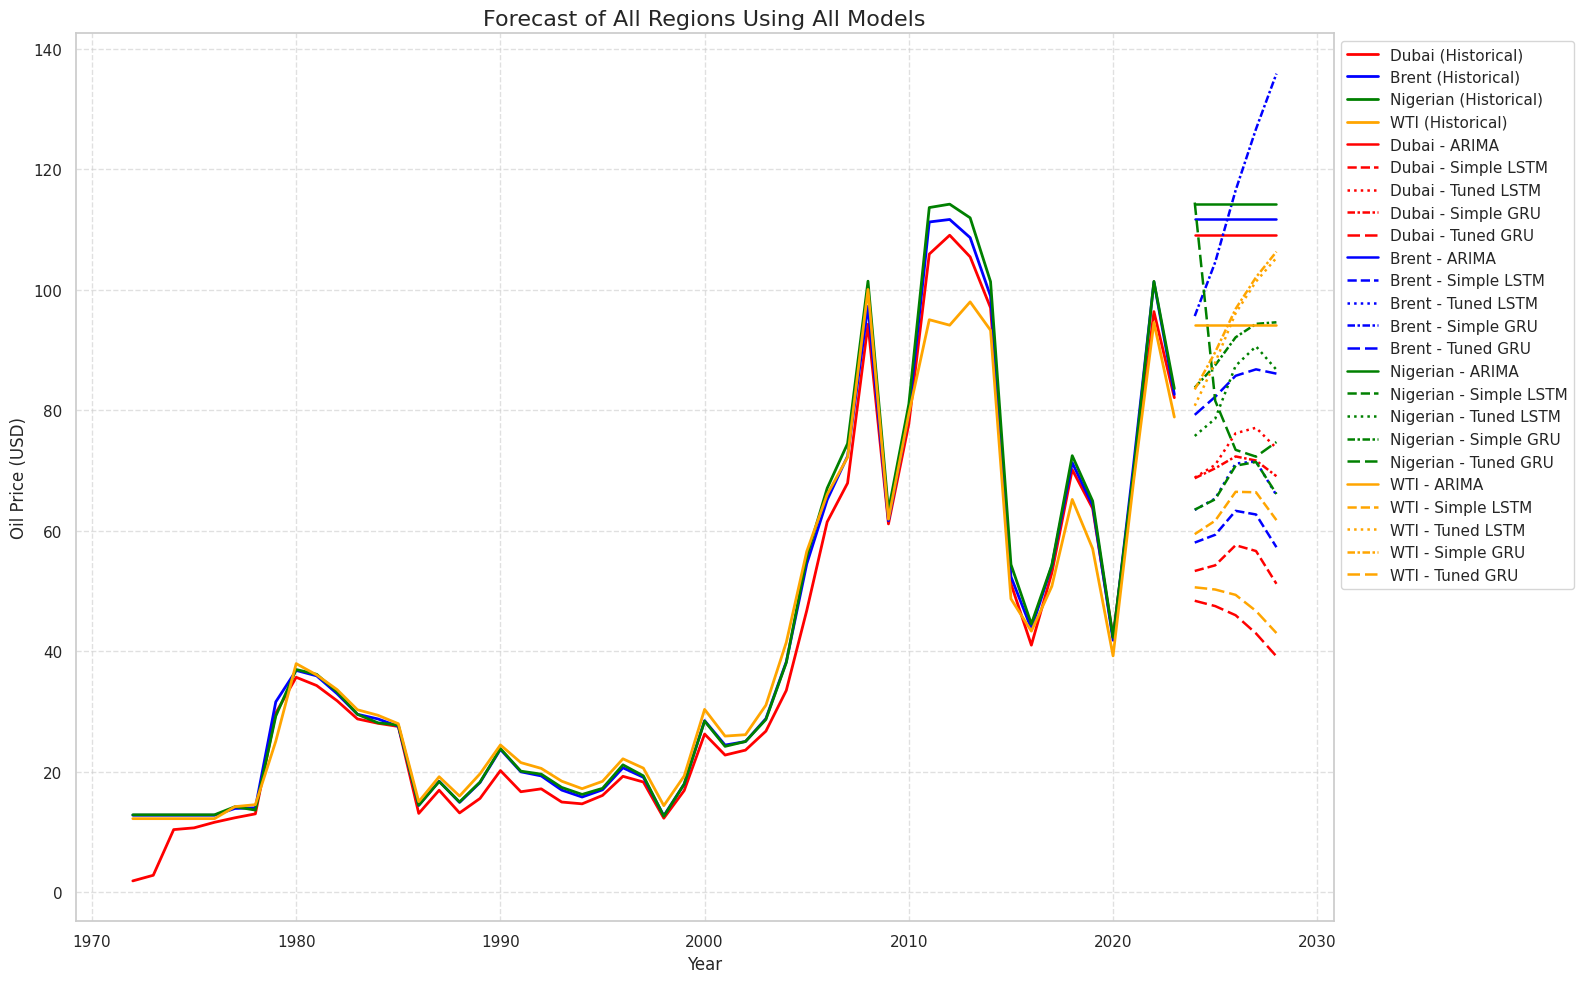

In [ ]:
plot_forecast_all_models_all_regions(df_clean, all_results, forecast_years=5)

### ⦿ All in One Final Forecast (Best Model)

In [ ]:
def plot_forecast_all_regions_combined(df, all_results, best_models_df, forecast_years=5):
    plt.figure(figsize=(14, 7))

    colors = {
        'Dubai': 'red',
        'Brent': 'blue',
        'Nigerian': 'green',
        'WTI': 'orange'
    }

    model_key_map = {
        'Simple LSTM': 'simple',
        'Tuned LSTM': 'hyper',
        'Simple GRU': 'simple_gru',
        'Tuned GRU': 'tuned_gru',
        'ARIMA': 'arima'
    }

    # Plot historical data
    for region in ['Dubai', 'Brent', 'Nigerian', 'WTI']:
        plt.plot(df.index, df[region], label=f'{region} (Historical)', color=colors[region], linestyle='-')

    # Plot forecast using best model per region
    for region in ['Dubai', 'Brent', 'Nigerian', 'WTI']:
        best_model = best_models_df[best_models_df['Region'] == region]['Best Model'].values[0]
        model_key = model_key_map[best_model]

        if model_key == 'arima':
            forecast_df = forecast_future_arima(all_results[region][model_key], df, region, forecast_years)
        else:
            forecast_df = create_prediction_intervals(all_results[region][model_key], df, region, forecast_years)

        plt.plot(forecast_df.index, forecast_df[f'{region}_Forecast'],
                 label=f'{region} (Forecast)', color=colors[region], linestyle='--')

    plt.title('Forecast Comparison Across Regions (Best Model per Region)')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 22ms/step


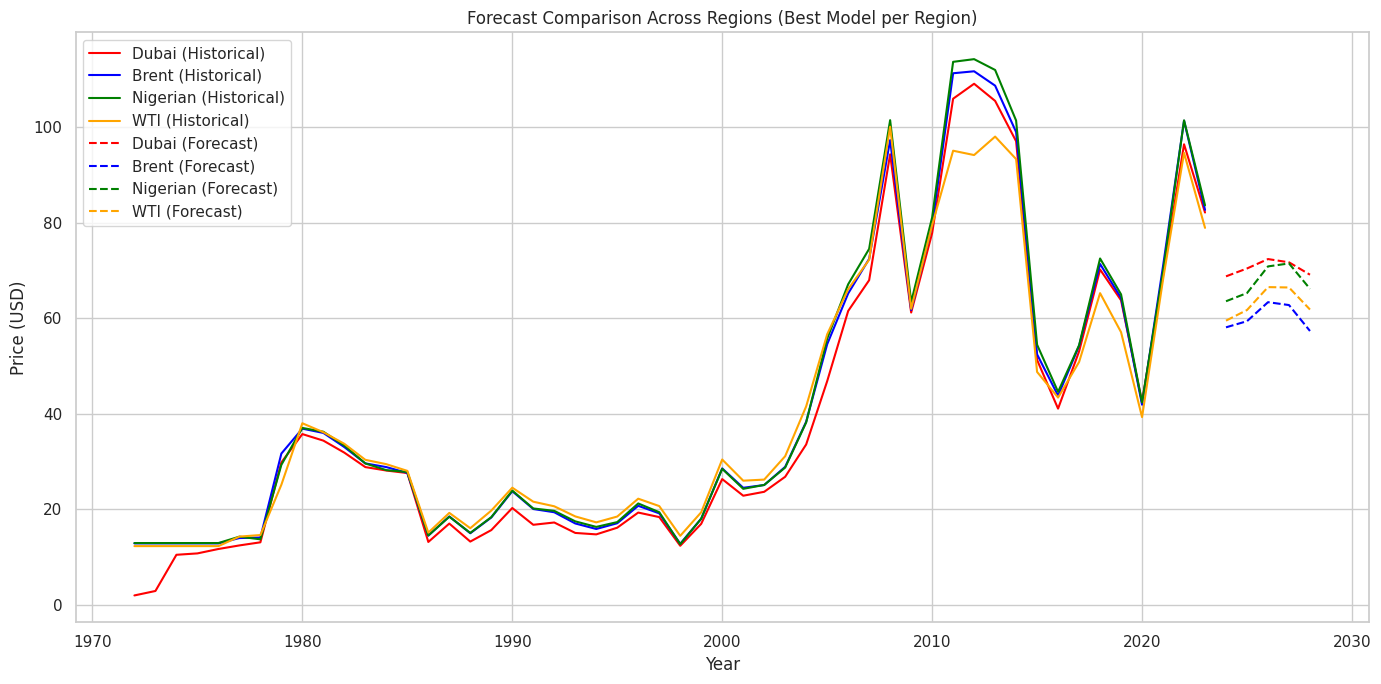

In [ ]:
plot_forecast_all_regions_combined(df_clean, all_results, best_models_df, forecast_years=5)


### ⦿ Export Results

In [ ]:
# Export forecasts to CSV
all_forecasts = pd.DataFrame()

model_key_map = {
    'Simple LSTM': 'simple',
    'Tuned LSTM': 'hyper',
    'Simple GRU': 'simple_gru',
    'Tuned GRU': 'tuned_gru',
    'ARIMA': 'arima'
}

for region, results in all_results.items():
    # Use the best model for each region
    region_best = best_models_df[best_models_df['Region'] == region]['Best Model'].values[0]
    model_key = model_key_map[region_best]

    # Generate forecasts
    if model_key == 'arima':
        forecast_df = forecast_future_arima(results['arima'], df_clean, region, forecast_years)
    else:
        forecast_df = create_prediction_intervals(results[model_key], df_clean, region, forecast_years)

    # Rename columns to include region
    forecast_df = forecast_df.rename(columns={
        f'{region}_Forecast': f'{region}_Forecast',
        f'{region}_Lower': f'{region}_Lower_95',
        f'{region}_Upper': f'{region}_Upper_95'
    })

    # Merge with all forecasts
    if all_forecasts.empty:
        all_forecasts = forecast_df
    else:
        all_forecasts = pd.concat([all_forecasts, forecast_df], axis=1)

# Export to CSV
all_forecasts.to_csv('oil_price_forecasts.csv')
print("\nForecasts exported to 'oil_price_forecasts.csv'")

1/1 [==============================] - 0s 23ms/step

Forecasts exported to 'oil_price_forecasts.csv'
